In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.9 MB/s eta 0:00:00


In [ ]:
#importing useful libraries/modules for this project

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as mpl
import math
import os, glob
from matplotlib import style
import warnings

#decomposition and kpss from statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler


mpl.rcParams['figure.figsize'] = (16,12)
style.use('ggplot')
np.warnings = warnings
np.warnings.filterwarnings('ignore')

In [ ]:
#load data
from google.colab import files


uploaded = files.upload()

Saving Investor_data.xlsx to Investor_data.xlsx


In [ ]:
df_f = pd.read_excel('Investor_data.xlsx',
                       sheet_name = None,
                       parse_dates=['Date'],
                       index_col = 'Date',
                       skipfooter=1)

In [ ]:
#Breakdown pages in excel sheet
print(f'Excel spreadsheet has {len(df_f.keys())} sheets')

Excel spreadsheet has 8 sheets


In [ ]:
#select first page as a reference
#print the name of first page
print(f'First sheet is : {list(df_f.keys())[0]}')
df1 = df_f[list(df_f.keys())[0]]
df2 = df_f[list(df_f.keys())[1]]
df3 = df_f[list(df_f.keys())[2]]
df4 = df_f[list(df_f.keys())[3]]
df5 = df_f[list(df_f.keys())[4]]
df6 = df_f[list(df_f.keys())[5]]
df7 = df_f[list(df_f.keys())[6]]
df8 = df_f[list(df_f.keys())[7]]
df1.head(), df1.tail()

First sheet is : Russia - Sberbank Rossii PAO (S


(             Price    Open    High     Low    Vol.  Change %
 Date                                                        
 2021-03-31  291.02  294.00  294.42  290.26  47.00M   -0.0076
 2021-03-30  293.25  294.86  295.72  291.50  38.81M   -0.0002
 2021-03-29  293.30  289.72  294.09  289.26  43.68M    0.0071
 2021-03-26  291.22  288.63  292.75  288.32  56.07M    0.0159
 2021-03-25  286.66  286.50  287.03  283.85  35.22M    0.0030,
              Price    Open    High     Low    Vol.  Change %
 Date                                                        
 2020-01-10  258.19  257.86  259.25  256.88  18.85M    0.0008
 2020-01-09  257.99  259.40  261.76  257.01  38.33M   -0.0045
 2020-01-08  259.15  253.57  259.15  253.03  40.82M    0.0207
 2020-01-06  253.90  254.75  254.84  251.40  22.35M   -0.0043
 2020-01-03  255.00  255.99  258.19  253.70  35.85M    0.0010)

In [ ]:
df1.shape, df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311 entries, 2021-03-31 to 2020-01-03
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     311 non-null    float64
 1   Open      311 non-null    float64
 2   High      311 non-null    float64
 3   Low       311 non-null    float64
 4   Vol.      311 non-null    object 
 5   Change %  311 non-null    float64
dtypes: float64(5), object(1)
memory usage: 17.0+ KB


((311, 6), None)

In [ ]:
#there are different objects in spreadsheet such as M ( million) and K ( kilo) and we need to transfer it to digit/float
def convert_volume(v):
    if v[-1]=='M':
        return float(v[:-1])*1000000
    elif v[-1]=='K':
        return float(v[:-1])*1000
    else:
        return 0

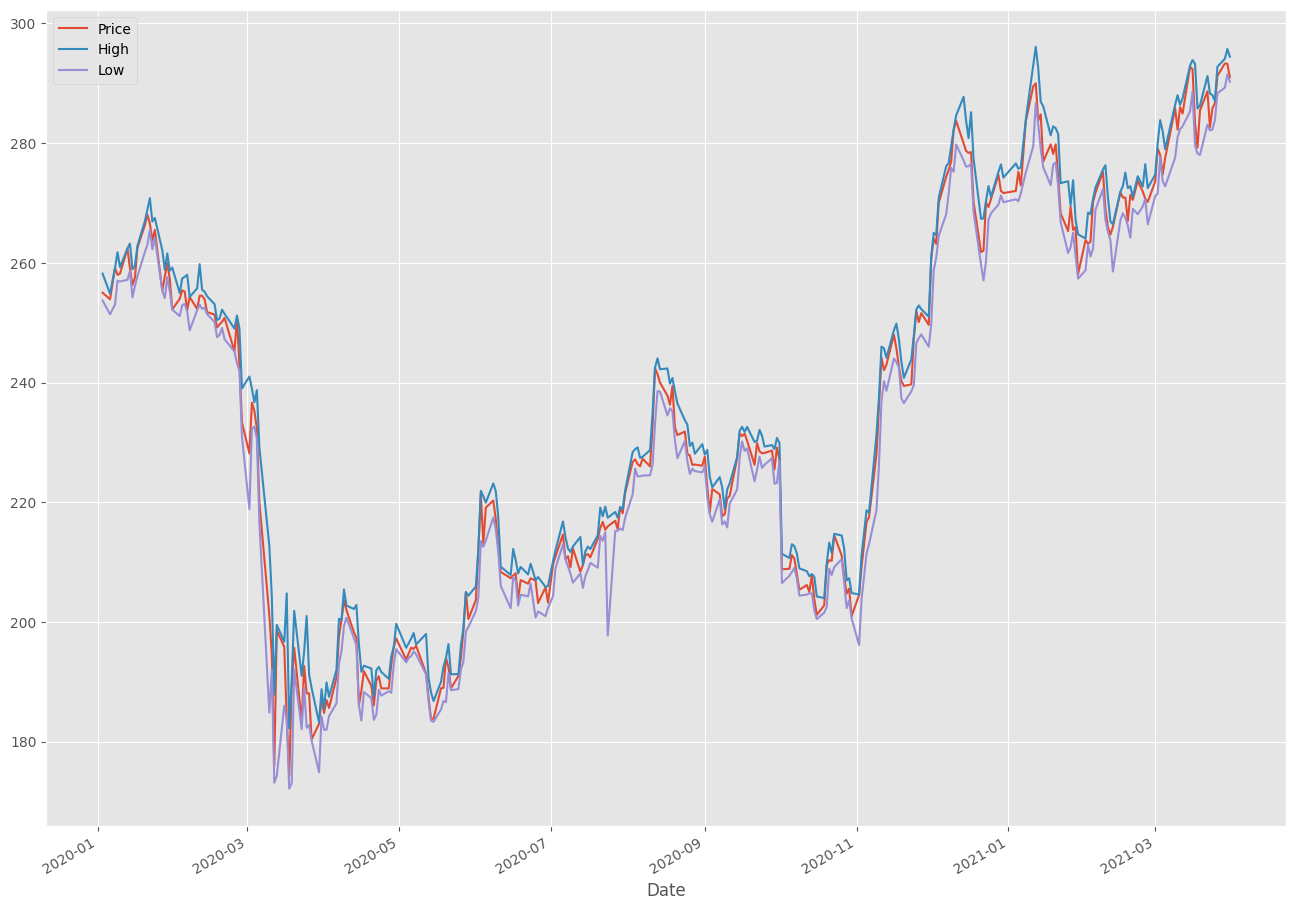

In [ ]:
df1[['Price','High', 'Low']].plot()
mpl.show()

Based on presented graph, the price vs time series has no stationarity nor seasionality

Decomposition can be used to check that

<Axes: xlabel='Date'>

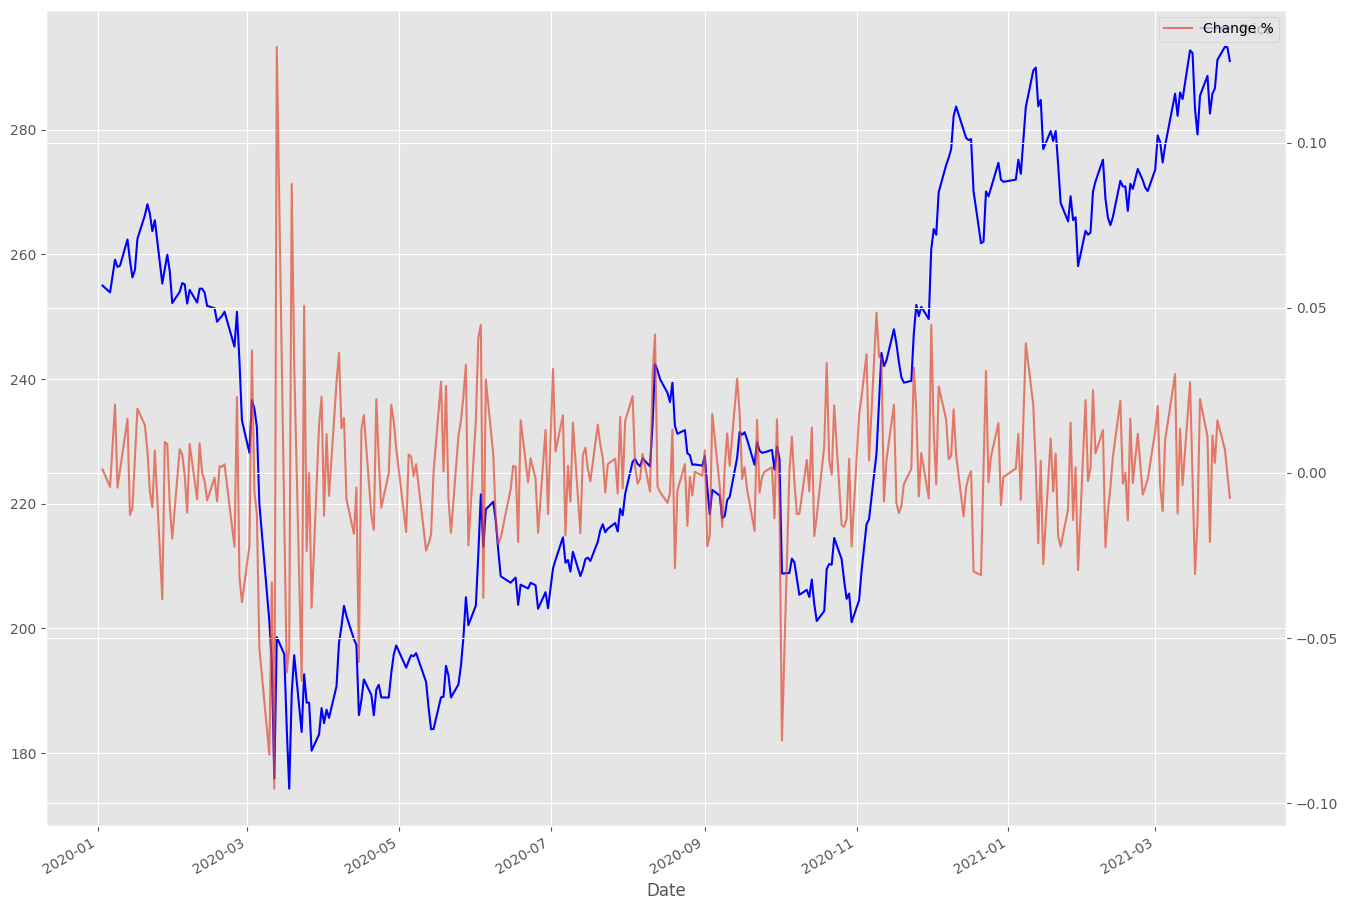

In [ ]:
fig, ax1 = mpl.subplots()
df1['Price'].plot(ax = ax1, color = 'blue', legend = 'Price')

ax2 = ax1.twinx()
df1['Change %'].plot(ax = ax2, alpha = 0.7, legend = " Change %")

Since all stocks are plot in one chart, we can look if there is any common trend among them.

As they different prices, we can upscale them using max-min scaler function

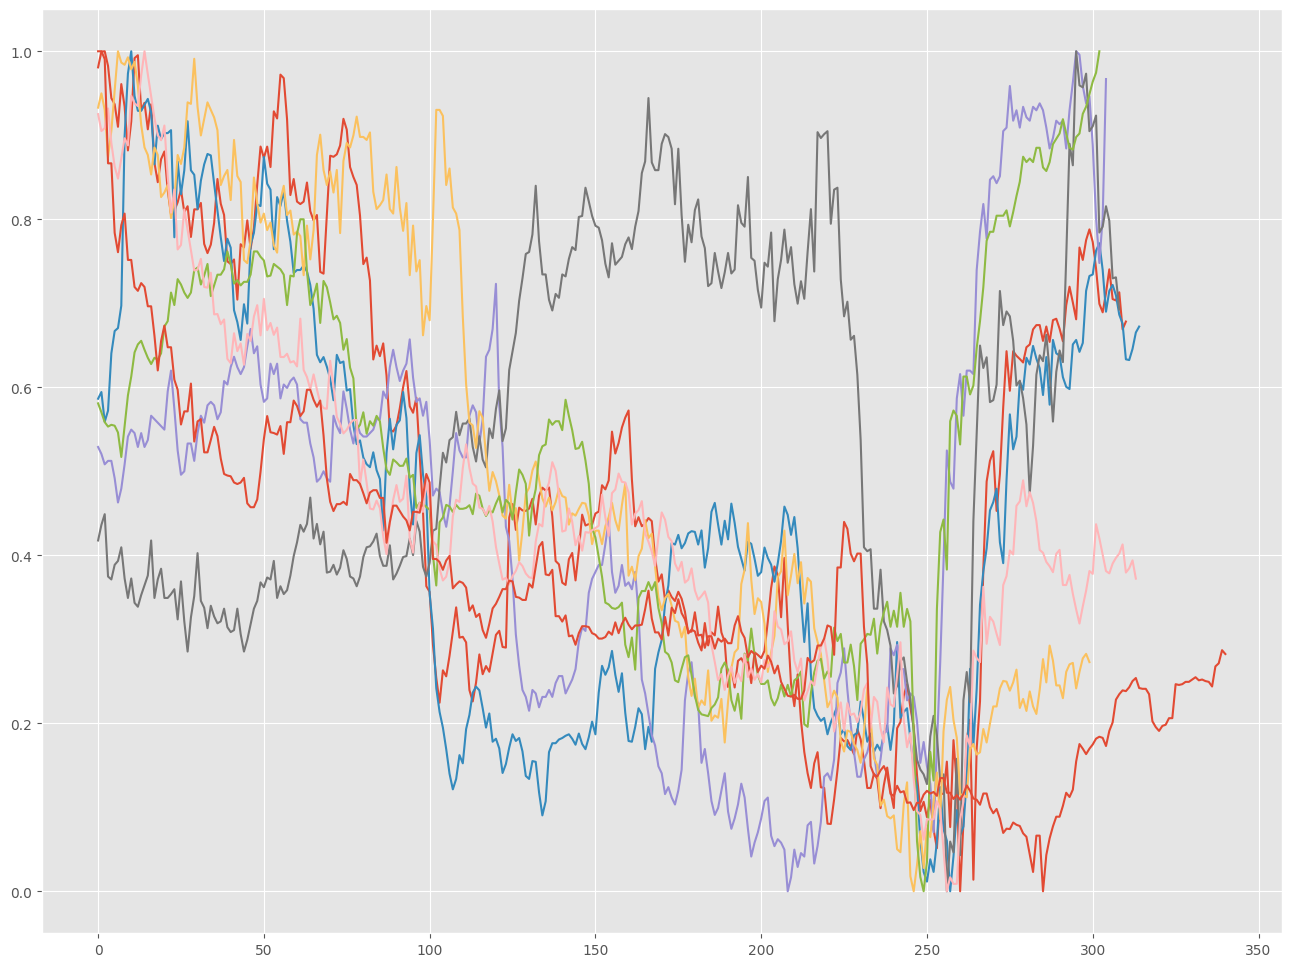

In [ ]:
for k in df_f.keys():
  scaler = MinMaxScaler()
  y_t = scaler.fit_transform(np.array(df_f[k][['Price']]))
  mpl.plot(y_t)

mpl.show()

conclusion :

There is no common trend among them.

additionally, some of them drop after march 2020 when pandemic started while some increased a lot

***Selected dataset : Sberbank Rossii PAO (s)***

# **Decomposition**

This section allows to check if there is any seasonal fluctuation in time series ( seasionality)

It breaks down to 3 categories :


1.   Trend : Overall direction where data is travelling
2.   Seasionality : cycle pattern of data
3.   Noise : random varies

If dataset can be decomposed, hence it should have a defined frequency. The dataset does not have any frequency however we can introduce it

In [ ]:
print(df1.index.freq)

None


The selected frequency is 'B' which is business days. Since we are not omitting, the holidays, then we can use business days to get the closest to the dataset

In [ ]:
#reSampling with B and call it dfB
dfB = df1.resample('B').apply(lambda x: x.astype(str).str.replace('M', '').astype(float).mean())
print(dfB.isna().sum())

Price       14
Open        14
High        14
Low         14
Vol.        14
Change %    14
dtype: int64


14 new row added. The values are assigned as NAN using foward filled method, as in stock the price of added day is equal to precious day

However the values for "change % " and "Vol." should be float

which needs to be assigned to 0

In [ ]:

dfB.head()

Price    Open    High     Low   Vol.  Change %
Date                                                       
2020-01-03  255.00  255.99  258.19  253.70  35.85    0.0010
2020-01-06  253.90  254.75  254.84  251.40  22.35   -0.0043
2020-01-07     NaN     NaN     NaN     NaN    NaN       NaN
2020-01-08  259.15  253.57  259.15  253.03  40.82    0.0207
2020-01-09  257.99  259.40  261.76  257.01  38.33   -0.0045

In [ ]:
dfB.fillna(method = 'ffill', inplace = True)

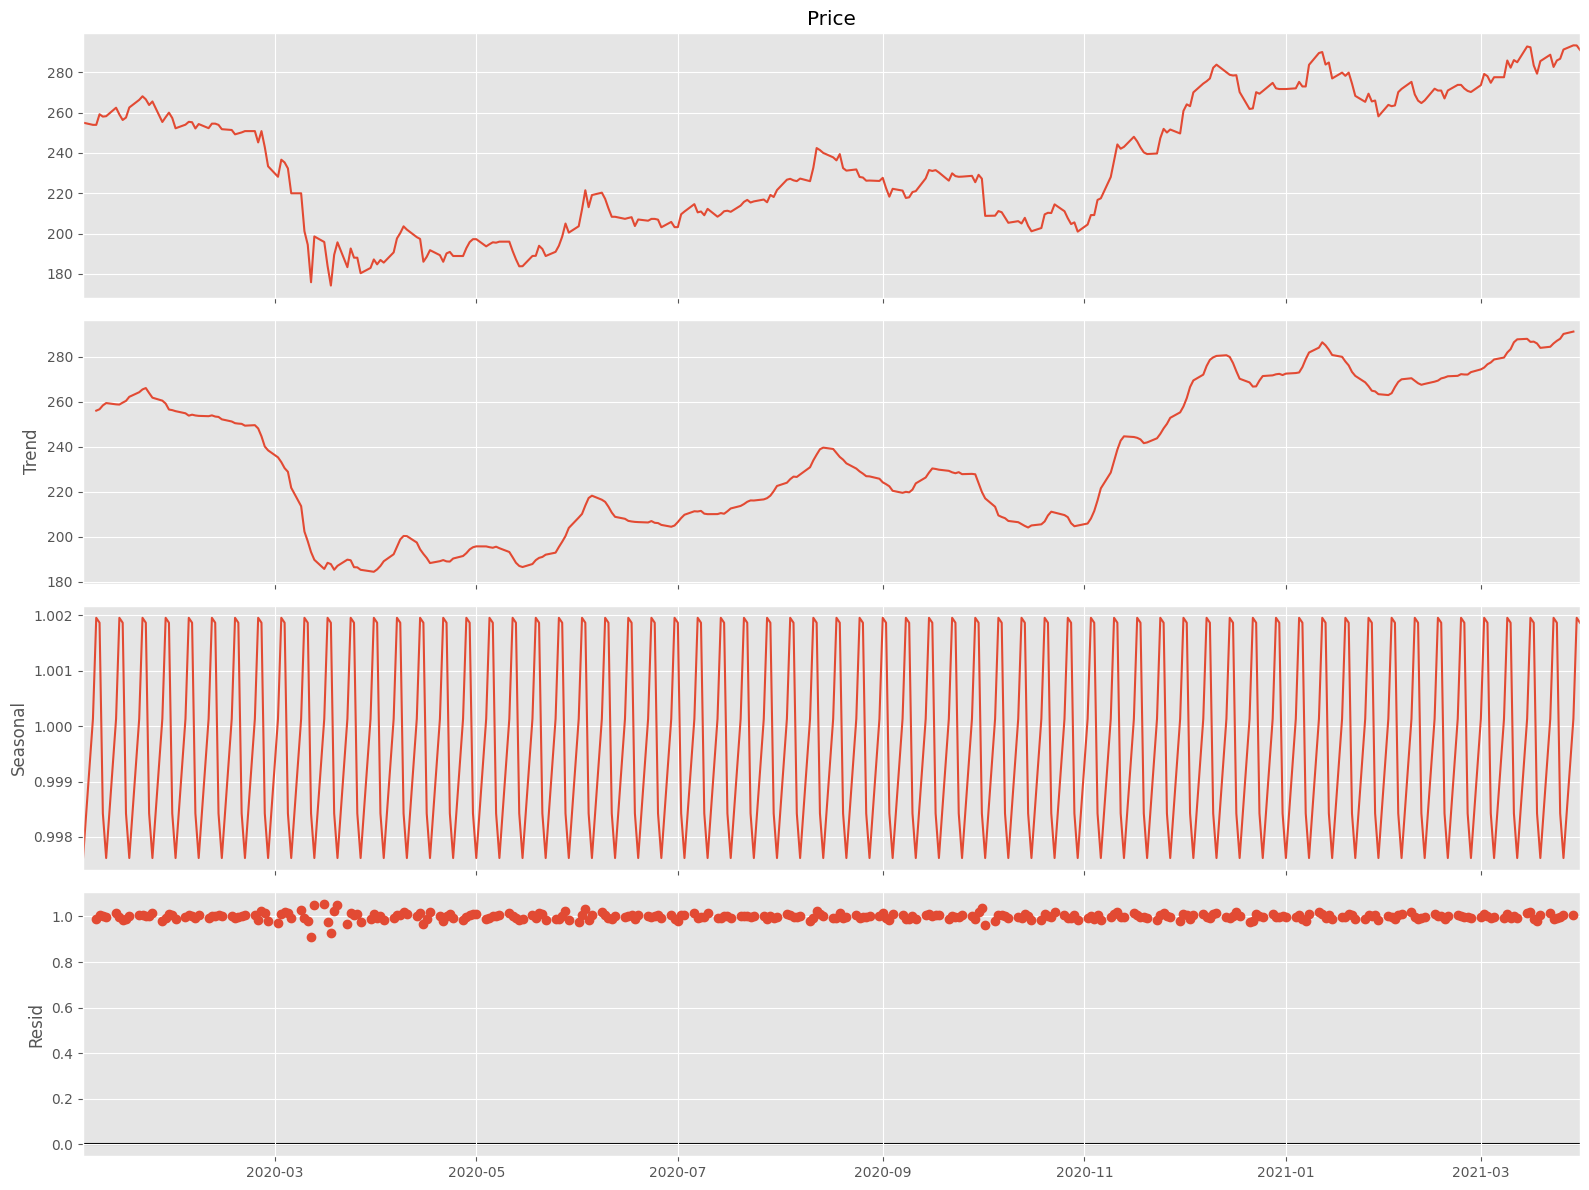

In [ ]:
decom = seasonal_decompose(dfB['Price'], model = 'multiplicative')
decom.plot()
mpl.show()

Seasonal_decomposed function in statsmodels used to quantify the component part in dataset.

multiplicative model selected as there is a flunctuation in certain percentage of price in stock( not in fixed one)

we are mainly focusing on "price" column as we can train model with that dataset

# **SARIMAX ARIMA**

We want to apply ARIMA model however initially we need to check for stationatiy. Time series datasets are stationity if its statiscial features does not change over time. ( mean, variance and converaince needs to be consistent in a time period)

Based on above graphs, the mean is not constant. To check we can use KPSS

Hypothesis : model is in stationary mode if p-value is less than significance level ( 0.05 is the common one), we reject the null and consider data is NON-stationary

In [ ]:
#assign price column as a variable

C1 = df1['Price']

In [ ]:
def get_kpss_stat(C1) :
  kpss_result = kpss(C1)

  print(f'KPSS statistic: {kpss_result[0]}')
  print(f'p-value: {kpss_result[1]}')
  print(f'# lags : {kpss_result[2]}')

get_kpss_stat(C1)

KPSS statistic: 1.248468852376087
p-value: 0.01
# lags : 11


In this case, p-value is less than 0.05, hence null hypothesis rejecteded and model is non-stationary


Now we need to make mean constant to make it stationary


We can do it by differentiating the dataset. To do so, we need to create a new time series comprising the difference b/w the value in original dataset


diff() function is useful,

<Axes: xlabel='Date'>

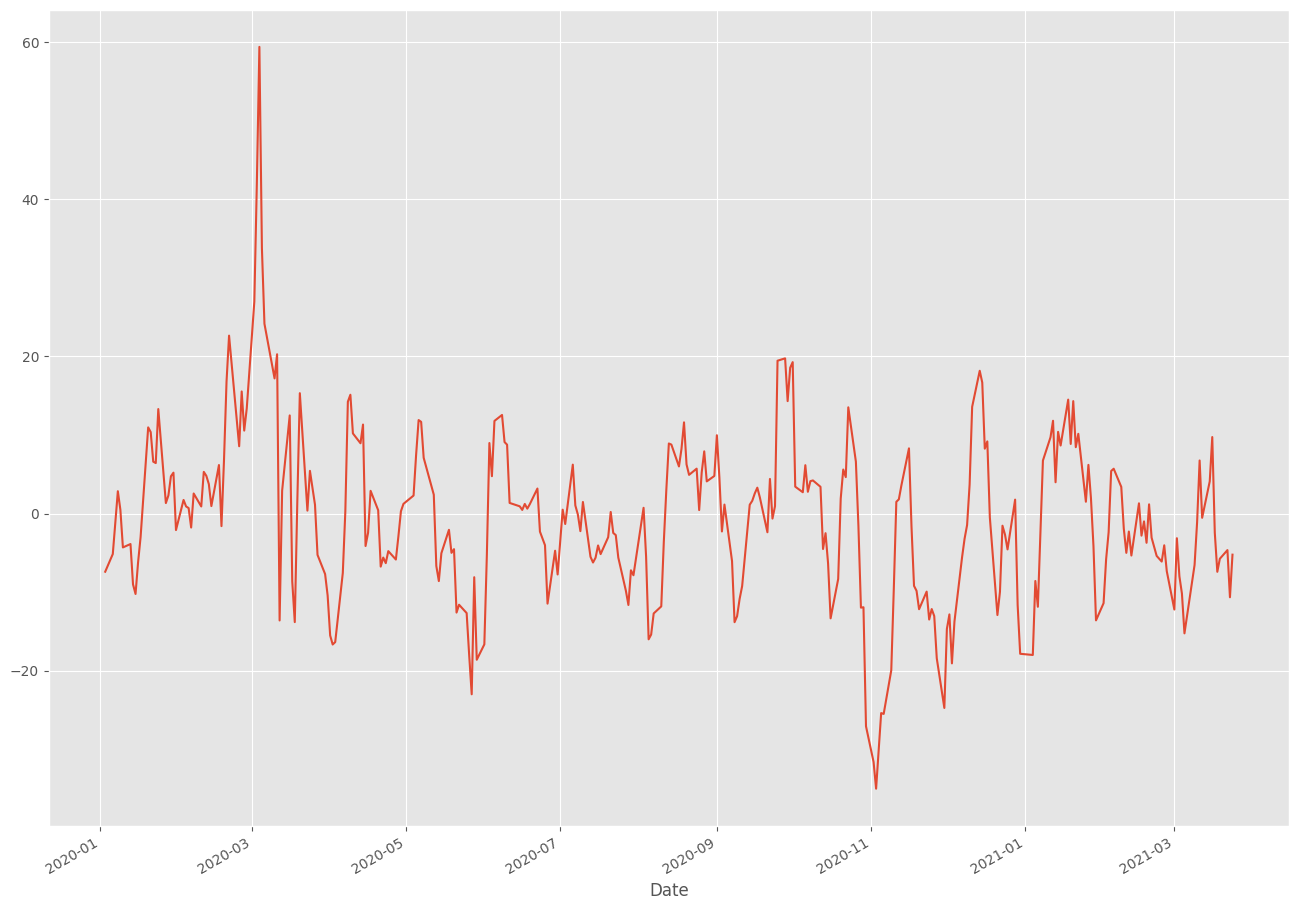

In [ ]:
C_d1 = C1.diff(5).dropna()
C_d1.plot()

In [ ]:
#check p-value again
get_kpss_stat(C_d1)

KPSS statistic: 0.35328499779642797
p-value: 0.09729094922567759
# lags : 9


Now the p-value increased and goes higher thank 0.05 hence it is stationary.

#**DATA SPLIT**

As question asked us to split data non-random, hence I break it down

2020 data --> training

2021 data --> test

In [ ]:
test_len = (C1.index.year==2021).sum()
C_train1 = C1[test_len:]
C_test1 = C1[:test_len]


test_len_d = (C_d1.index.year==2021).sum()
C_d_train1 = C_d1[test_len_d:]
C_d_test1 = C_d1[:test_len_d]

In [ ]:
C_d_train1

Date
2020-12-30   -17.84
2020-12-29   -11.64
2020-12-28     1.77
2020-12-25    -4.56
2020-12-24    -2.68
              ...  
2020-01-10    -4.31
2020-01-09     0.48
2020-01-08     2.84
2020-01-06    -5.15
2020-01-03    -7.40
Name: Price, Length: 250, dtype: float64

In [ ]:
C_d_test1

Date
2021-03-24    -5.23
2021-03-23   -10.65
2021-03-22    -4.65
2021-03-19    -5.75
2021-03-18    -7.41
2021-03-17    -2.44
2021-03-16     9.73
2021-03-15     4.09
2021-03-12    -0.54
2021-03-11     6.75
2021-03-10    -1.11
2021-03-09    -6.54
2021-03-05   -15.24
2021-03-04   -10.18
2021-03-03    -7.99
2021-03-02    -3.14
2021-03-01   -12.21
2021-02-26    -7.33
2021-02-25    -4.04
2021-02-24    -6.11
2021-02-22    -5.39
2021-02-20    -3.07
2021-02-19     1.17
2021-02-18    -3.72
2021-02-17    -1.00
2021-02-16    -2.81
2021-02-15     1.30
2021-02-12    -5.34
2021-02-11    -2.29
2021-02-10    -5.00
2021-02-09    -1.92
2021-02-08     3.39
2021-02-05     5.70
2021-02-04     5.41
2021-02-03    -2.37
2021-02-02    -5.83
2021-02-01   -11.40
2021-01-29   -13.59
2021-01-28    -4.15
2021-01-27     1.97
2021-01-26     6.19
2021-01-25     1.50
2021-01-22    10.14
2021-01-21     8.44
2021-01-20    14.30
2021-01-19     8.85
2021-01-18    14.49
2021-01-15     8.65
2021-01-14    10.39
2021-01-13     

For applying SARIMAX model, we need, p, d and q parameter. To evaluate these parameters y_diff needs to be feed to ARIMA model amd calculate their RMS.

In [ ]:
pdq_ARIMA = auto_arima(C_d_train1, trace = True)
p,d,q = pdq_ARIMA.order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1656.707, Time=2.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1673.915, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1675.911, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1675.909, Time=1.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1671.924, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1675.590, Time=1.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1677.563, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1623.473, Time=0.68 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1674.681, Time=0.11 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1642.842, Time=0

In [ ]:
total_len1 = C1.shape[0]
train_len1 = (C1.index.year==2020).sum()
model = SARIMAX(C_train1, order = (p,d+1,q), seasonal_order= (p,d+1,q,10))
model = model.fit()
C_pred1 = model.predict(start = train_len1, end = total_len1-1)
model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Price   No. Observations:                  250
Model:             SARIMAX(4, 2, 5)x(4, 2, 5, 10)   Log Likelihood                -732.539
Date:                            Mon, 05 Aug 2024   AIC                           1503.078
Time:                                    23:31:58   BIC                           1568.236
Sample:                                         0   HQIC                          1529.367
                                            - 250                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.1601      0.325     -6.636      0.000      -2.798      -1.522
ar.L2         -2.3216      0.719     -3.228      0.001      -3.731      -0.912
ar.L3         -1.3664      0.679     -2.013      0.044      -2.697      -0.036
ar.L4         -0.4257      0.290     -1.467      0.142      -0.994       0.143
ma.L1          1.1874      0.351      3.386      0.001       0.500       1.875
ma.L2          0.1117      0.507      0.220      0.826      -0.882       1.106
ma.L3         -1.0819      0.274     -3.944      0.000      -1.619      -0.544
ma.L4         -0.8999      0.485     -1.856      0.063      -1.850       0.050
ma.L5         -0.2751      0.350     -0.786      0.432      -0.961       0.411
ar.S.L10      -1.6044      0.312     -5.148      0.000      -2.215      -0.994
ar.S.L20      -1.6401      0.414     -3.960      0.000      -2.452      -0.828
ar.S.L30      -1.2070      0.344     -3.504      0.000      -1.882      -0.532
ar.S.L40      -0.2606      0.137     -1.902      0.057      -0.529       0.008
ma.S.L10      -0.3645      0.901     -0.405      0.686      -2.130       1.401
ma.S.L20      -0.4312      0.933     -0.462      0.644      -2.259       1.397
ma.S.L30      -0.3943      0.695     -0.567      0.571      -1.757       0.968
ma.S.L40      -0.5185      0.963     -0.538      0.590      -2.406       1.369
ma.S.L50       0.7652      0.626      1.223      0.221      -0.461       1.991
sigma2        23.8784     13.204      1.808      0.071      -2.002      49.758
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                24.09
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.13   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).

In [ ]:
C_train1

Date
2020-12-30    271.65
2020-12-29    272.00
2020-12-28    274.70
2020-12-25    270.64
2020-12-24    269.32
               ...  
2020-01-10    258.19
2020-01-09    257.99
2020-01-08    259.15
2020-01-06    253.90
2020-01-03    255.00
Name: Price, Length: 250, dtype: float64

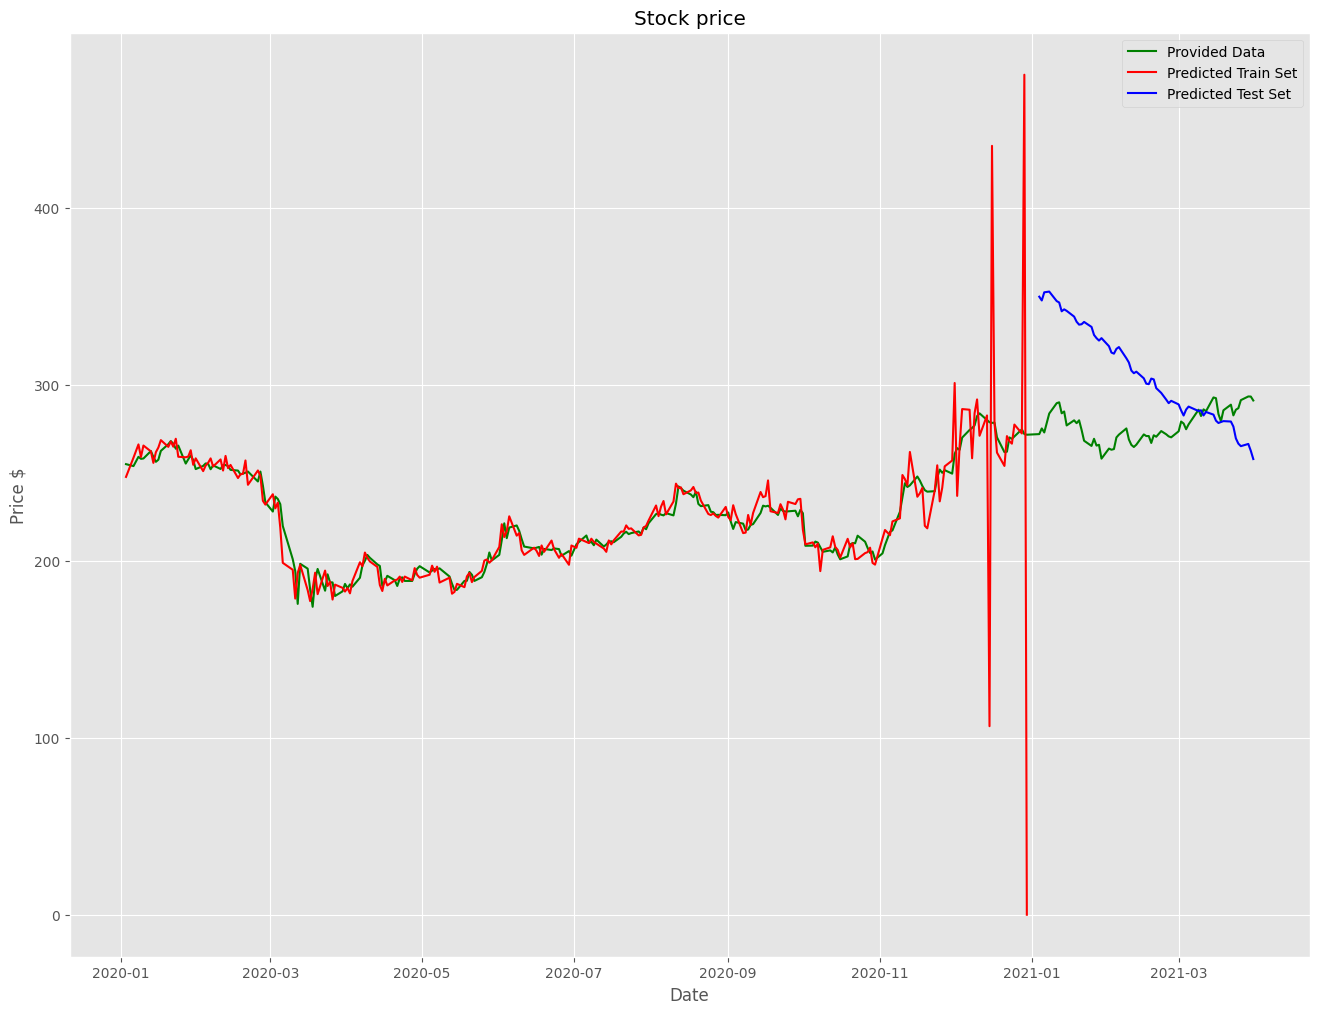

In [ ]:
#plot of showing prediced data Vs. Actual data

mpl.plot(C1, color = 'g', label = 'Provided Data')
mpl.plot(model.predict(), color = 'r', label = 'Predicted Train Set')

C_pred1.index = C_test1.index
mpl.plot(C_pred1, color = 'b', label = 'Predicted Test Set')
mpl.xlabel('Date')
mpl.ylabel('Price $')
mpl.title('Stock price')
mpl.legend()
mpl.show()

#**BOLLINGER BANDS**

Bollinger bands is a popular method among stock trading. It consist 3 lines

1. price moveing avg for selected window
2. Upper bollinger band
3. lower bollinger band

using given function to this model

In [ ]:
def bollinger_bands(df, n):
    # takes dataframe on input
    # n = smoothing length

    df['mov_avg'] = df['predicted'].rolling(n).mean()
    df['mov_std'] = df['predicted'].rolling(n).std()
    df['upper'] = df['mov_avg'] + 2*df['mov_std']
    df['lower'] = df['mov_avg'] - 2*df['mov_std']
    df.dropna(inplace = True)
    return df

def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0

    for i in range(len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)

    return buy_price, sell_price, bb_signal

def plot_bollinger(df, buy_price, sell_price):
    df['predicted'].plot(label = 'Predicted Price', alpha = 0.3, color = 'blue')
    df['test_set'].plot(label = 'Actual Price', alpha = 0.3, color = 'red')
    df['upper'].plot(label = 'Upper BB', linestyle = '--', linewidth = 1, color = 'black')
    df['mov_avg'].plot(label = 'Middle BB', linestyle = '--', linewidth = 1.2, color = 'grey')
    df['lower'].plot(label = 'Lower BB', linestyle = '--', linewidth = 1, color = 'black')
    mpl.scatter(df.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 200)
    mpl.scatter(df.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
    mpl.title('Bollinger Band Strategy Trading Signals')
    mpl.legend(loc = 'upper left')
    mpl.show()


def calculate_return(buy_price, sell_price, y_test):
    i = 0
    result =0
    bp = None
    initial = None
    while i < len(buy_price) and math.isnan(buy_price[i]):
        i+=1
    if i < len(buy_price) and buy_price[i]>0:
        initial = buy_price[i]
    while i < len(buy_price):
        if buy_price[i]>0:
            bp = buy_price[i]
        elif sell_price[i]>0:
            if bp:
                result += (sell_price[i]-bp)
                bp = None
        i+=1
    if initial:
        result = (result/initial)*100
    do_nothing = (y_test[-1]/y_test[0] -1)*100
    print(f'Return using Bollinger Band Strategy is {round(result,2)}%.\nReturn from do nothing strategy is {round(do_nothing,2)}%')


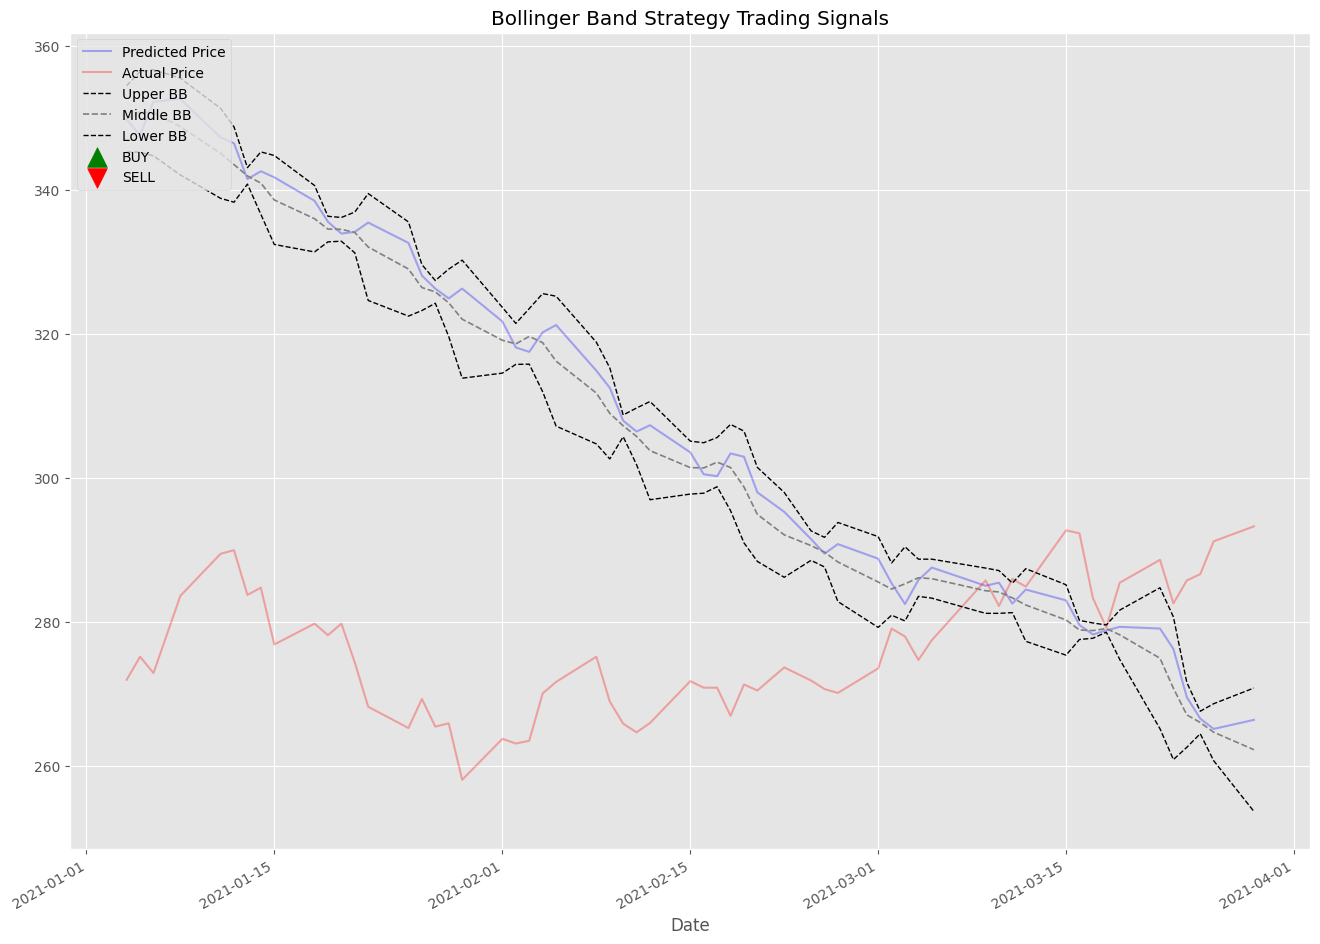

Return using Bollinger Band Strategy is 0%.
Return from do nothing strategy is -6.54%


In [ ]:
#graph

df_pred = pd.DataFrame({'test_set':C_test1, 'predicted':C_pred1})
df_pred = bollinger_bands(df_pred, 3)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred['predicted'], df_pred['lower'], df_pred['upper'])
plot_bollinger(df_pred, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test1)

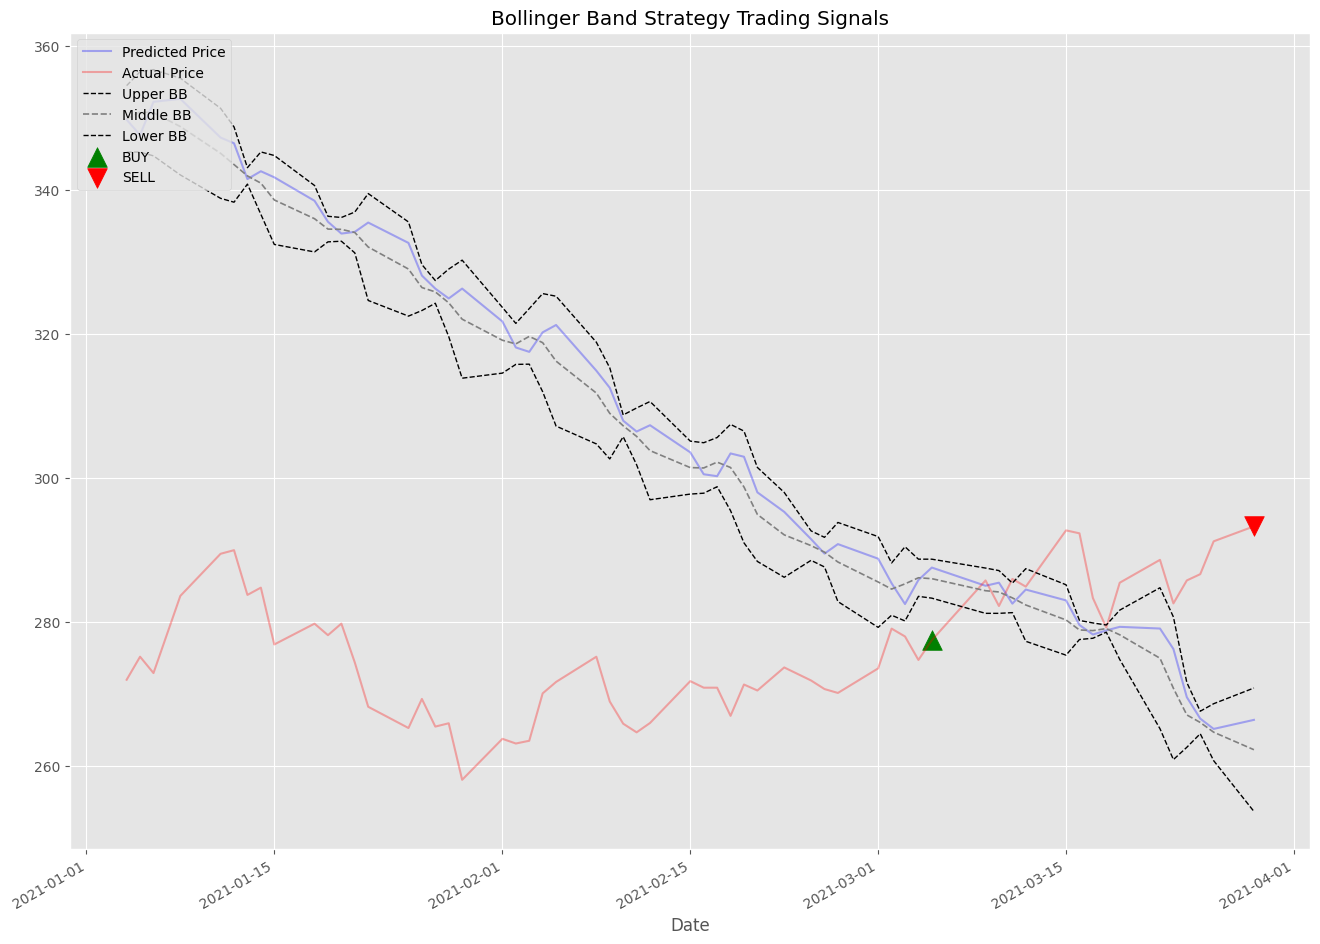

Return using Bollinger Band Strategy is 0.0%.
Return from do nothing strategy is -6.54%


In [ ]:
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred['test_set'], df_pred['lower'], df_pred['upper'])
plot_bollinger(df_pred, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test1)

#**Koc Holding AS**

In [ ]:
# Function to convert strings to numeric values
def convert_to_numeric(val):
    if 'M' in val:
        return float(val.replace('M', '')) * 1e6
    # Add more cases if needed (e.g., 'K' for thousands)
    if 'K' in val:
        return float(val.replace('K', '')) * 1e3
    if val == '-':
        return 0

    return float(val)


In [ ]:
# Apply the conversion function to the 'value' column
df2['Vol.'] = df2['Vol.'].apply(convert_to_numeric)

In [ ]:
df2.head(), df2.tail()

(            Price   Open   High    Low        Vol.  Change %
 Date                                                        
 2021-03-31  19.41  19.42  19.63  19.27  13140000.0   -0.0046
 2021-03-30  19.50  19.12  19.81  19.03  21050000.0    0.0209
 2021-03-29  19.10  19.24  19.67  19.10  16560000.0   -0.0078
 2021-03-26  19.25  20.28  20.36  19.10  21350000.0   -0.0385
 2021-03-25  20.02  20.50  20.86  20.02  15930000.0   -0.0148,
             Price   Open   High    Low       Vol.  Change %
 Date                                                       
 2020-01-08  19.94  19.89  19.95  19.66  2790000.0    0.0005
 2020-01-07  19.93  20.22  20.28  19.92  2890000.0   -0.0075
 2020-01-06  20.08  20.34  20.34  19.97  1940000.0   -0.0108
 2020-01-03  20.30  20.30  20.44  19.97  3310000.0   -0.0039
 2020-01-02  20.38  20.42  20.44  20.24  2530000.0    0.0030)

Turkey - Koc Holding AS (KCHOL)


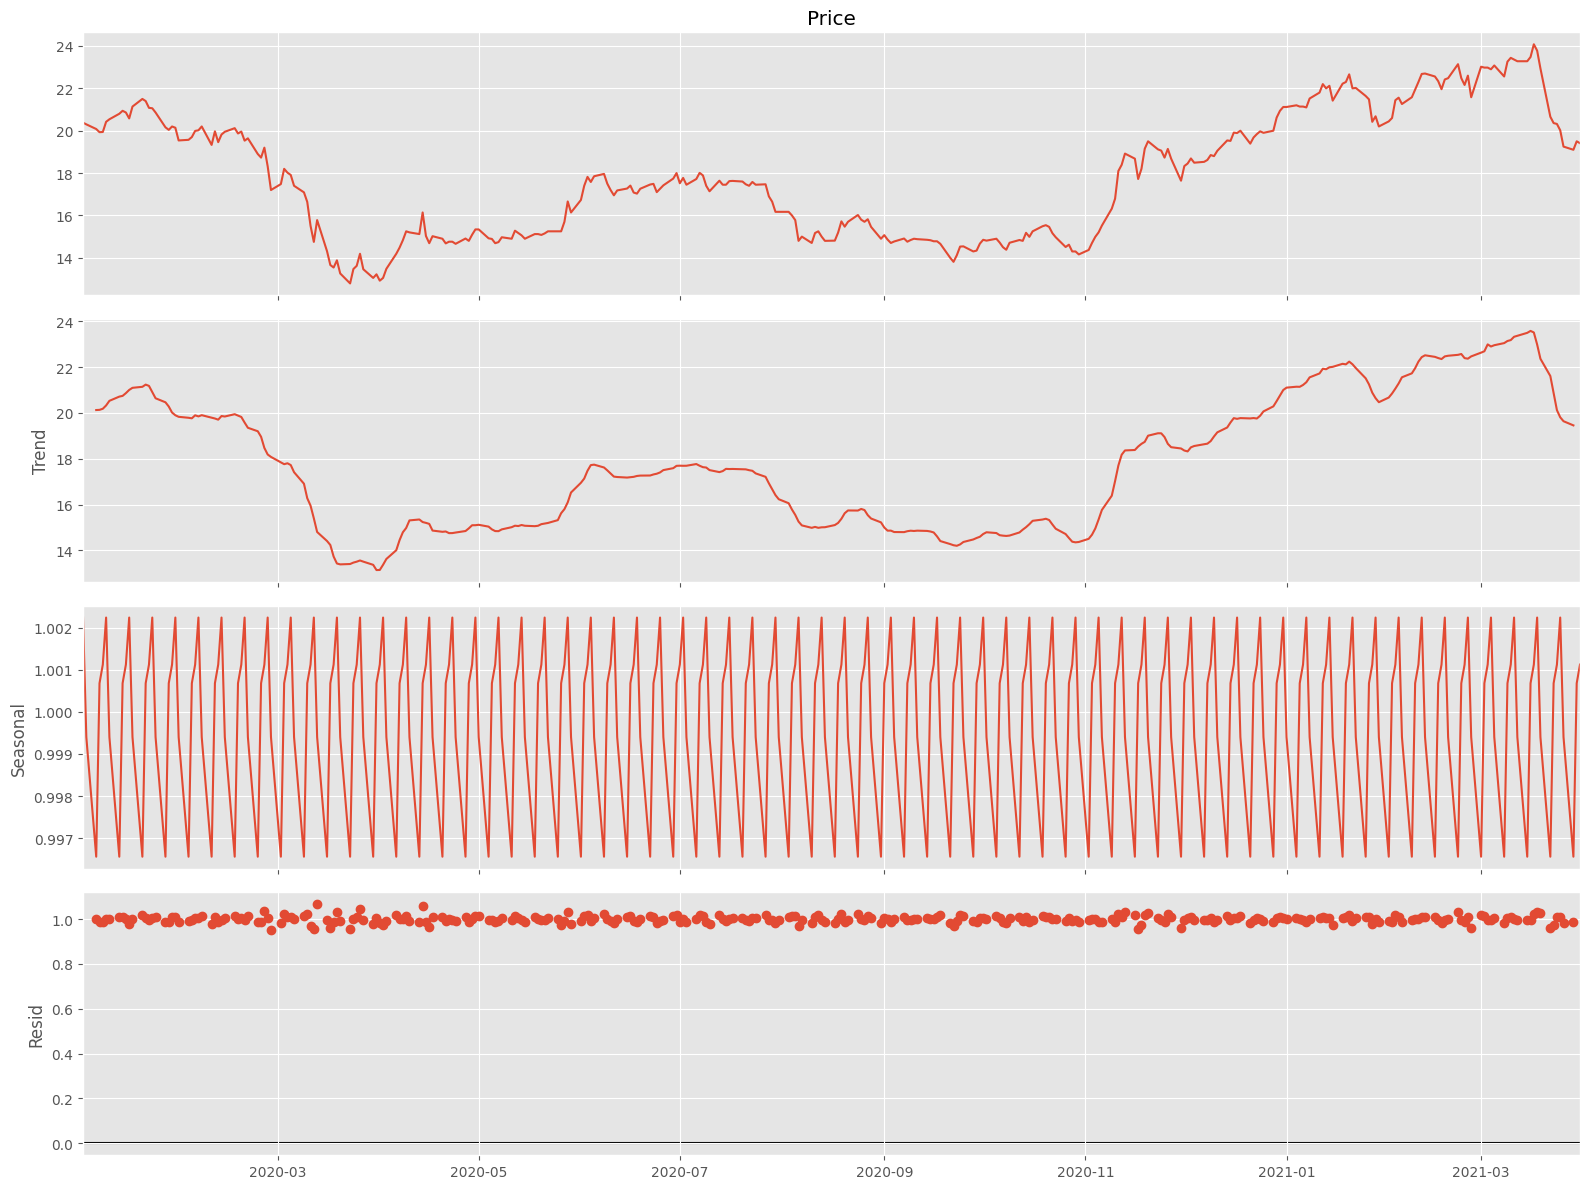

KPSS statistic: 0.8954433530037161
p-value: 0.01
# lags : 11
KPSS statistic: 0.19103534246220247
p-value: 0.1
# lags : 10


In [ ]:
from scipy.signal import cheb2ord
company = list(df_f.keys())[1]
print(company)
df2 = df_f[company]

# Convert 'Price' column to numeric, handling 'M' for millions
#if df2['Price'].dtype == object:
#  df2['Price'] = df2['Price'].str.replace('M', '').astype(float) * 1e6

# Resample the dataframe with new frequency and assign it to 'df2'
df2 = df2.resample('B').mean()
df2.fillna(method = 'ffill', inplace = True)

decomposition = seasonal_decompose(df2['Price'], model='multiplicative')
decomposition.plot()
mpl.show()
# Set y value
C2 = df2['Price']
# Check for stationarity
get_kpss_stat(C2)

C_d2 = C2.diff(5).dropna()
get_kpss_stat(C_d2)



In [ ]:
train_len2 = (C2.index.year==2020).sum()
C_train2 = C2[:train_len2]
C_test2 = C2[train_len2:]


train_len_d2 = (C_d2.index.year==2020).sum()
C_d_train2 = C_d2[:train_len_d2]
C_d_test2 = C_d2[train_len_d2:]

In [ ]:
C_d_train2

Date
2020-01-09    0.04
2020-01-10    0.24
2020-01-13    0.72
2020-01-14    1.01
2020-01-15    0.92
              ... 
2020-12-25   -0.10
2020-12-28    0.61
2020-12-29    0.94
2020-12-30    1.10
2020-12-31    1.15
Freq: B, Name: Price, Length: 256, dtype: float64

In [ ]:
pdq_ARIMA = auto_arima(C_d_train2, trace = True)
p,d,q = pdq_ARIMA.order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=374.438, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=419.547, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=421.193, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=421.118, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=417.564, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=423.523, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=424.831, Time=0.33 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=424.969, Time=0.81 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=423.491, Time=0.98 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.29 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.76 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 10.3

In [ ]:
total_len2= C2.shape[0]
train_len2 = (C2.index.year==2020).sum()
model = SARIMAX(C_train2, order = (p,d+1,q), seasonal_order= (p,d+1,q,5))
model = model.fit()
C_pred2 = model.predict(start = train_len2, end = total_len2-1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Price   No. Observations:                  261
Model:             SARIMAX(2, 2, 2)x(2, 2, 2, 5)   Log Likelihood                -155.407
Date:                           Tue, 06 Aug 2024   AIC                            328.813
Time:                                   02:34:46   BIC                            360.470
Sample:                               01-02-2020   HQIC                           341.556
                                    - 12-31-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9442      6.894     -0.137      0.891     -14.456      12.567
ar.L2          0.0554      0.377      0.147      0.883      -0.683       0.794
ma.L1         -0.0004   3.31e+04  -1.17e-08      1.000   -6.48e+04    6.48e+04
ma.L2         -0.9996    3.3e+04  -3.03e-05      1.000   -6.48e+04    6.48e+04
ar.S.L5       -0.0358      0.084     -0.425      0.671      -0.201       0.129
ar.S.L10      -0.2238      0.070     -3.198      0.001      -0.361      -0.087
ma.S.L5       -1.8531      2.192     -0.846      0.398      -6.148       2.442
ma.S.L10       0.8535      1.853      0.461      0.645      -2.778       4.485
sigma2         0.1587   5245.971   3.03e-05      1.000   -1.03e+04    1.03e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 6.87
Prob(Q):                              0.99   Prob(JB):                         0.03
Heteroskedasticity (H):               0.55   Skew:                             0.04
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

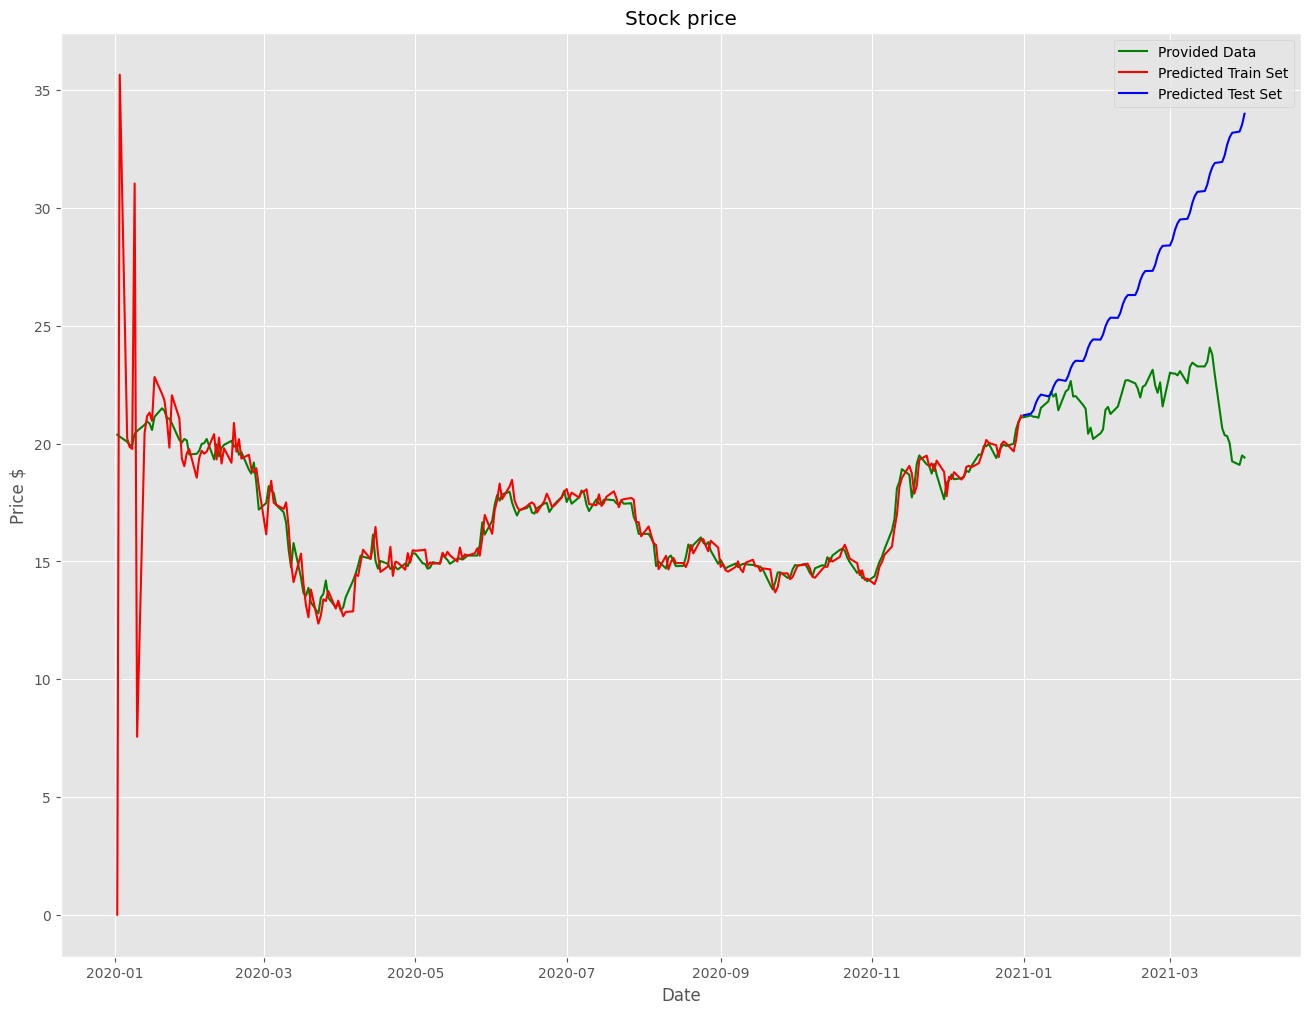

In [ ]:
#plot of showing prediced data Vs. Actual data

mpl.plot(C2, color = 'g', label = 'Provided Data')
mpl.plot(model.predict(), color = 'r', label = 'Predicted Train Set')

C_pred2.index = C_test2.index
mpl.plot(C_pred2, color = 'b', label = 'Predicted Test Set')
mpl.xlabel('Date')
mpl.ylabel('Price $')
mpl.title('Stock price')
mpl.legend()
mpl.show()

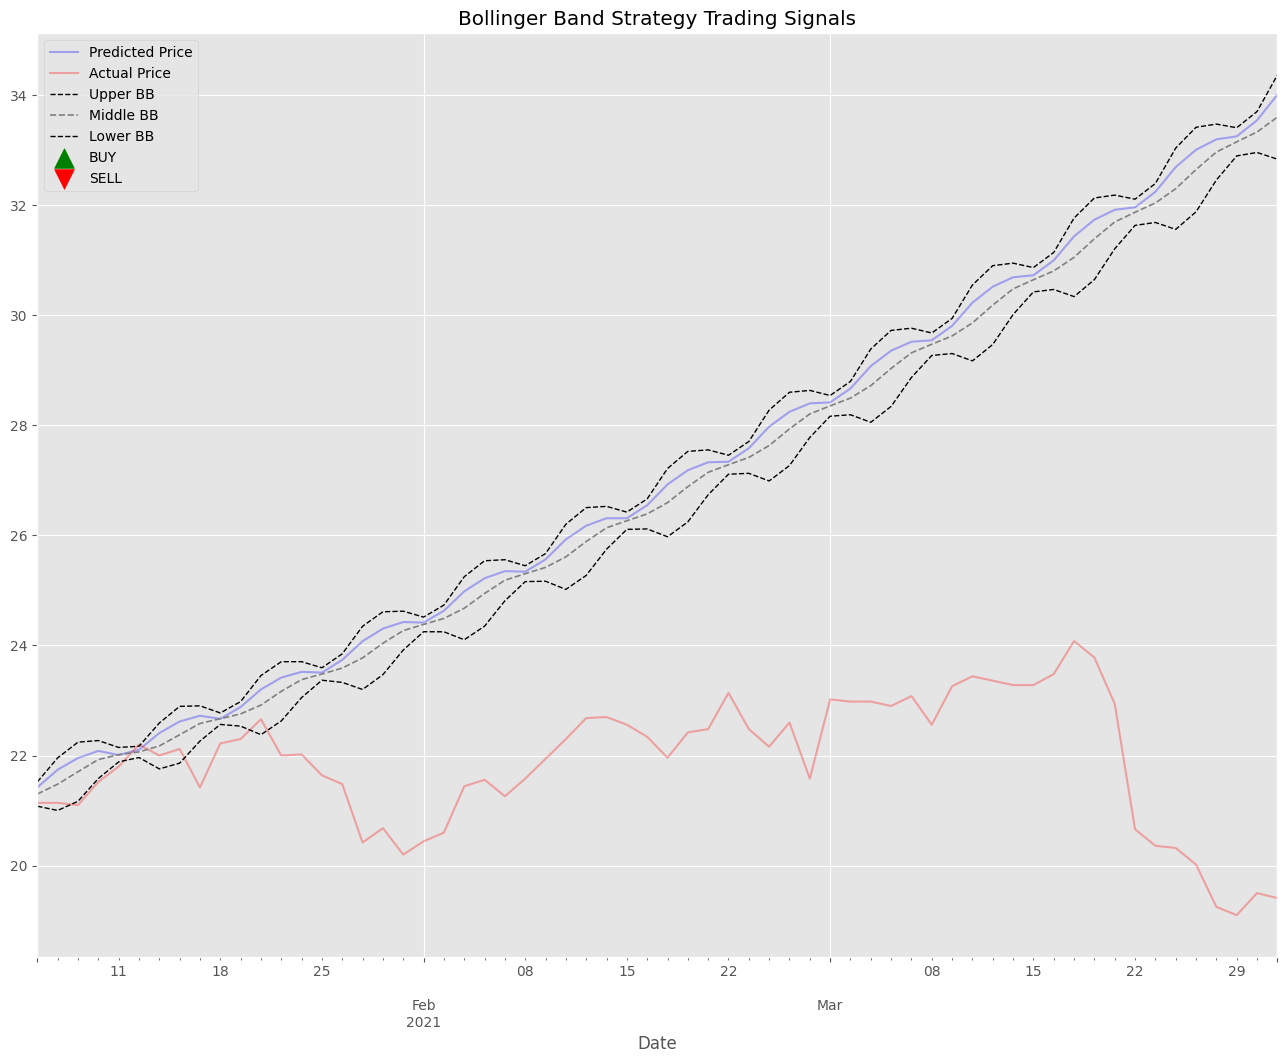

Return using Bollinger Band Strategy is 0%.
Return from do nothing strategy is -8.1%


In [ ]:
#graph

df_pred2 = pd.DataFrame({'test_set':C_test2, 'predicted':C_pred2})
df_pred2 = bollinger_bands(df_pred2, 3)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred2['predicted'], df_pred2['lower'], df_pred2['upper'])
plot_bollinger(df_pred2, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test2)

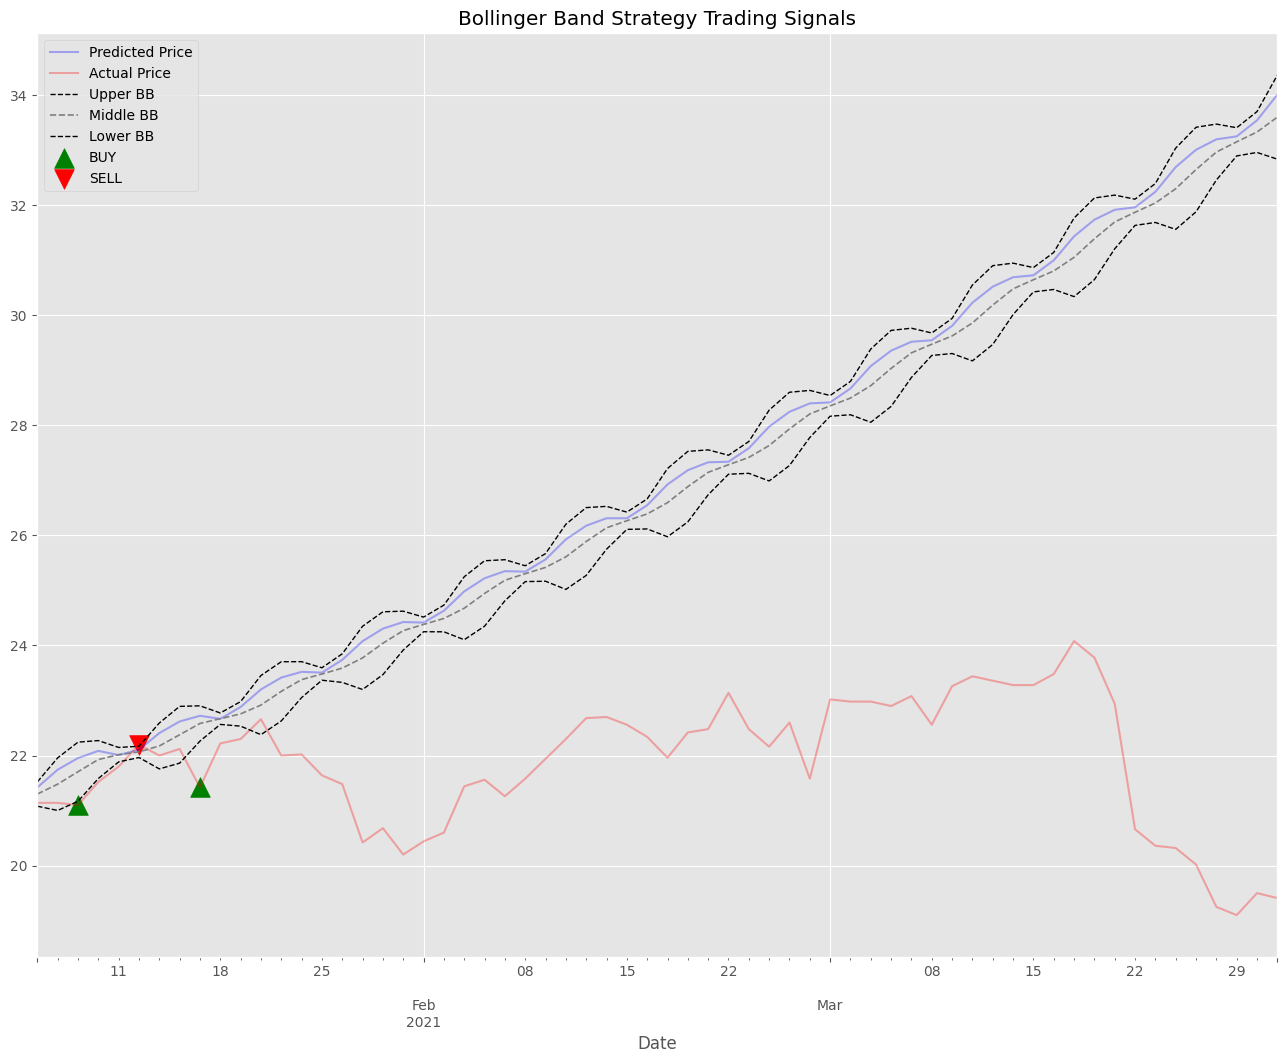

Return using Bollinger Band Strategy is 5.21%.
Return from do nothing strategy is -8.1%


In [ ]:
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred2['test_set'], df_pred2['lower'], df_pred2['upper'])
plot_bollinger(df_pred2, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test2)


# Medinet Nasr Housing (M)

In [ ]:
df3.head(), df3.tail()

(            Price  Open  High   Low   Vol.  Change %
 Date                                                
 2021-03-31   3.75  3.74  3.82  3.71  1.57M    0.0054
 2021-03-30   3.73  3.71  3.76  3.67  3.43M    0.0081
 2021-03-29   3.70  3.69  3.73  3.68  1.25M   -0.0027
 2021-03-28   3.71  3.76  3.76  3.68  2.34M    0.0000
 2021-03-25   3.71  3.62  3.78  3.59  2.50M    0.0137,
             Price  Open  High   Low     Vol.  Change %
 Date                                                  
 2020-01-09   4.62  4.55  4.70  4.55    2.09M    0.0476
 2020-01-08   4.41  4.19  4.59  4.15    3.52M    0.0304
 2020-01-06   4.28  4.16  4.44  4.12    2.52M   -0.0295
 2020-01-05   4.41  4.70  4.70  4.33    3.76M   -0.0832
 2020-01-02   4.81  4.81  4.87  4.78  241.60K   -0.0021)

In [ ]:
# Apply the conversion function to the 'value' column
df3['Vol.'] = df3['Vol.'].apply(convert_to_numeric)

Egypt - Medinet Nasr Housing (M


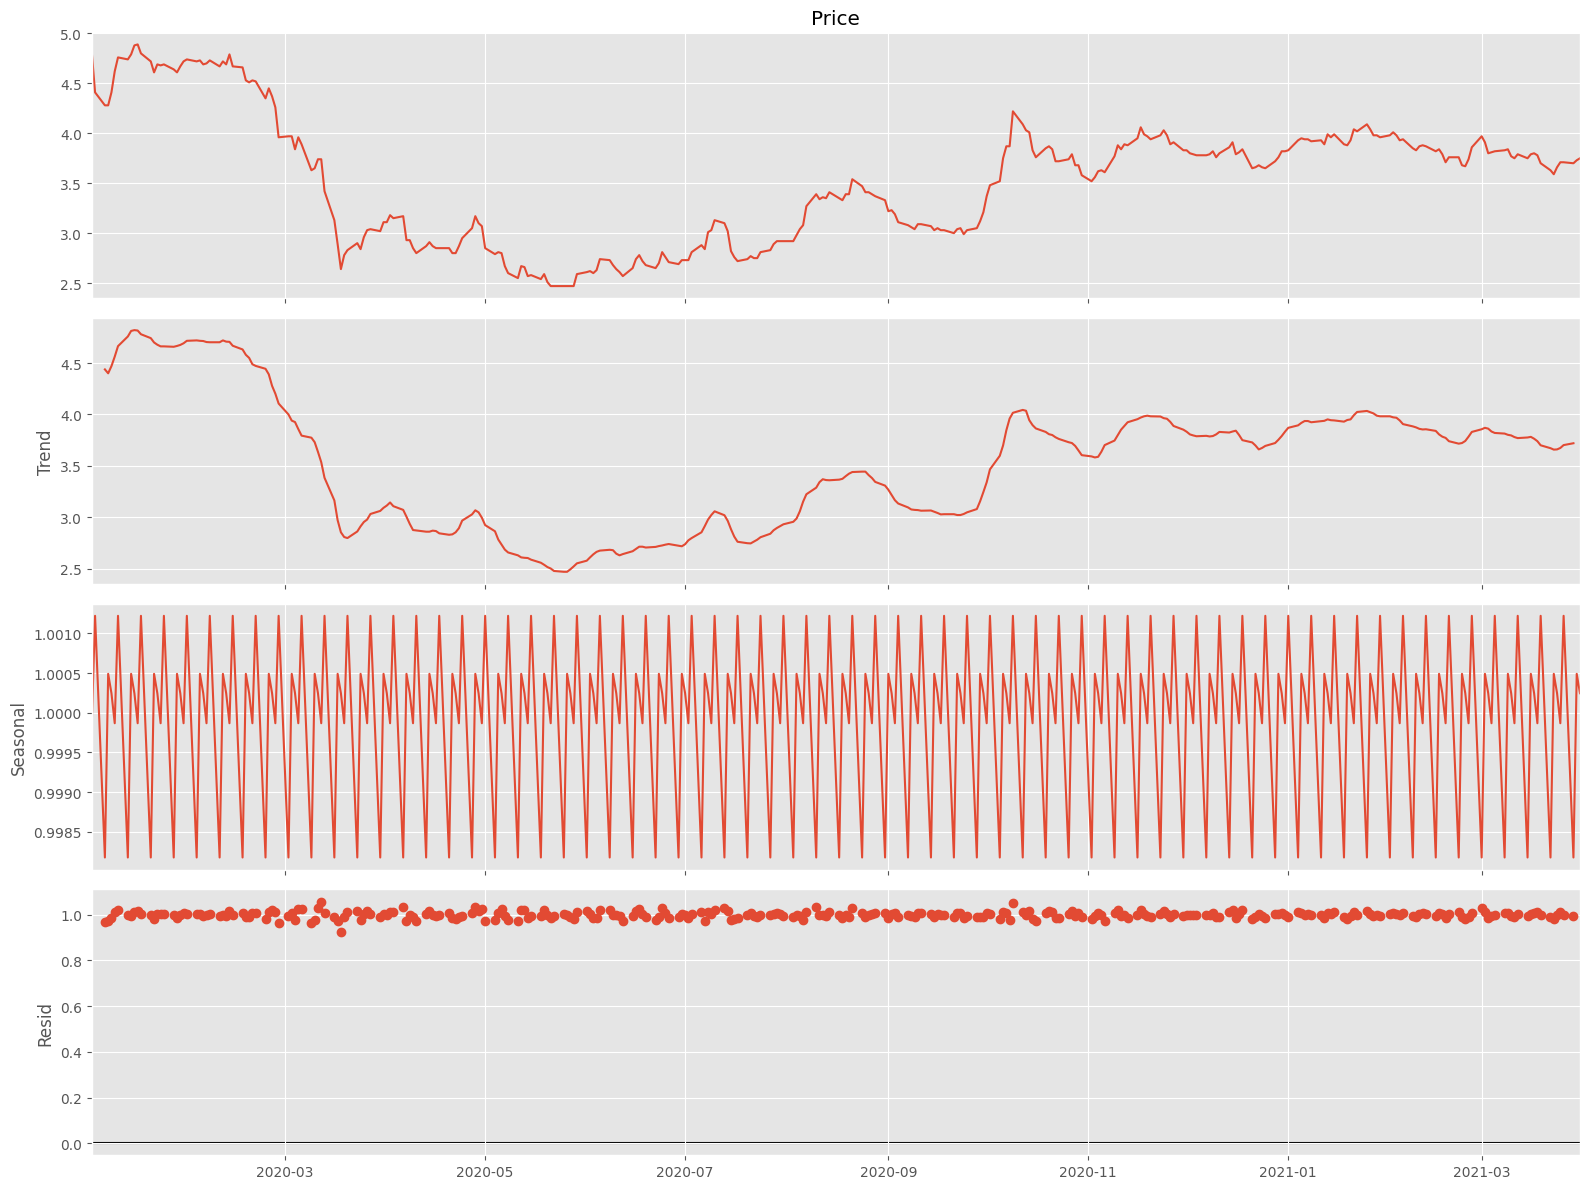

KPSS statistic: 0.4930959740595632
p-value: 0.04322162746406235
# lags : 11
KPSS statistic: 0.2579770647344528
p-value: 0.1
# lags : 10


In [ ]:
from pandas.core.arrays.period import c_dt64arr_to_periodarr
company = list(df_f.keys())[2]
print(company)
df3 = df_f[company]

df3 = df3.resample('B').mean()
df3.fillna(method = 'ffill', inplace = True)

decomposition = seasonal_decompose(df3['Price'], model='multiplicative')
decomposition.plot()
mpl.show()
# Set y value
C3 = df3['Price']
# Check for stationarity
get_kpss_stat(C3)

C_d3 = C3.diff(5).dropna()
get_kpss_stat(C_d3)

In [ ]:
train_len3 = (C3.index.year==2020).sum()
C_train3 = C3[:train_len3]
C_test3 = C3[train_len3:]


train_len_d3 = (C_d3.index.year==2020).sum()
C_d_train3 = C_d3[:train_len_d3]
C_d_test3 = C_d3[train_len_d3:]

In [ ]:
pdq_ARIMA = auto_arima(C_d_train3, trace = True)
p,d,q = pdq_ARIMA.order

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-385.946, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-4.220, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-354.682, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-193.663, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-5.416, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-366.827, Time=0.37 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-377.919, Time=0.44 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-410.888, Time=1.13 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-383.753, Time=0.74 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-373.841, Time=1.01 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-398.997, Time=1.40 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-418.637, Time=3.74 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-403.024, Time=0.48 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=-497.745, Time=0.94 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   :

In [ ]:
total_len3= C3.shape[0]
train_len3 = (C3.index.year==2020).sum()
model = SARIMAX(C_train3, order = (p,d+1,q), seasonal_order= (p,d+1,q,6))
model = model.fit()
C_pred3 = model.predict(start = train_len2, end = total_len2-1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Price   No. Observations:                  261
Model:             SARIMAX(1, 1, 4)x(1, 1, 4, 6)   Log Likelihood                 249.655
Date:                           Tue, 06 Aug 2024   AIC                           -477.311
Time:                                   02:44:58   BIC                           -438.400
Sample:                               01-02-2020   HQIC                          -461.658
                                    - 12-31-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2091      1.554      0.135      0.893      -2.837       3.255
ma.L1          0.0273      1.550      0.018      0.986      -3.011       3.066
ma.L2          0.0676      0.386      0.175      0.861      -0.690       0.825
ma.L3          0.0235      0.188      0.125      0.901      -0.346       0.393
ma.L4         -0.0518      0.089     -0.582      0.561      -0.226       0.123
ar.S.L6       -0.8043      0.803     -1.002      0.316      -2.377       0.769
ma.S.L6       -0.0782      0.810     -0.097      0.923      -1.665       1.508
ma.S.L12      -0.8112      0.748     -1.084      0.278      -2.278       0.656
ma.S.L18      -0.1051      0.093     -1.127      0.260      -0.288       0.078
ma.S.L24       0.0157      0.087      0.182      0.856      -0.154       0.186
sigma2         0.0076      0.002      4.986      0.000       0.005       0.011
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                41.09
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

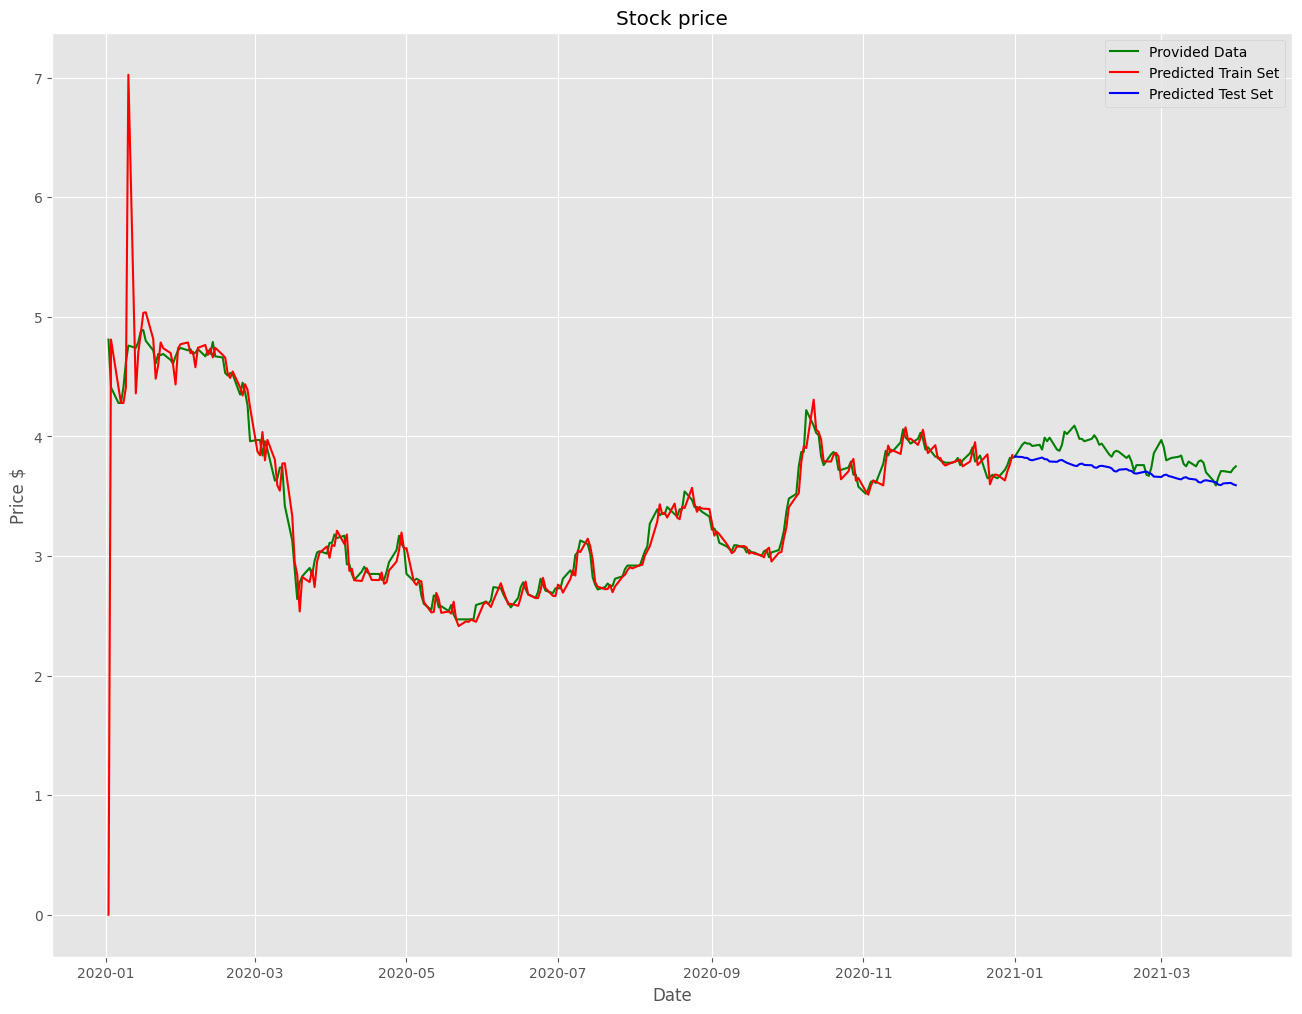

In [ ]:
#plot of showing prediced data Vs. Actual data

mpl.plot(C3, color = 'g', label = 'Provided Data')
mpl.plot(model.predict(), color = 'r', label = 'Predicted Train Set')

C_pred3.index = C_test3.index
mpl.plot(C_pred3, color = 'b', label = 'Predicted Test Set')
mpl.xlabel('Date')
mpl.ylabel('Price $')
mpl.title('Stock price')
mpl.legend()
mpl.show()

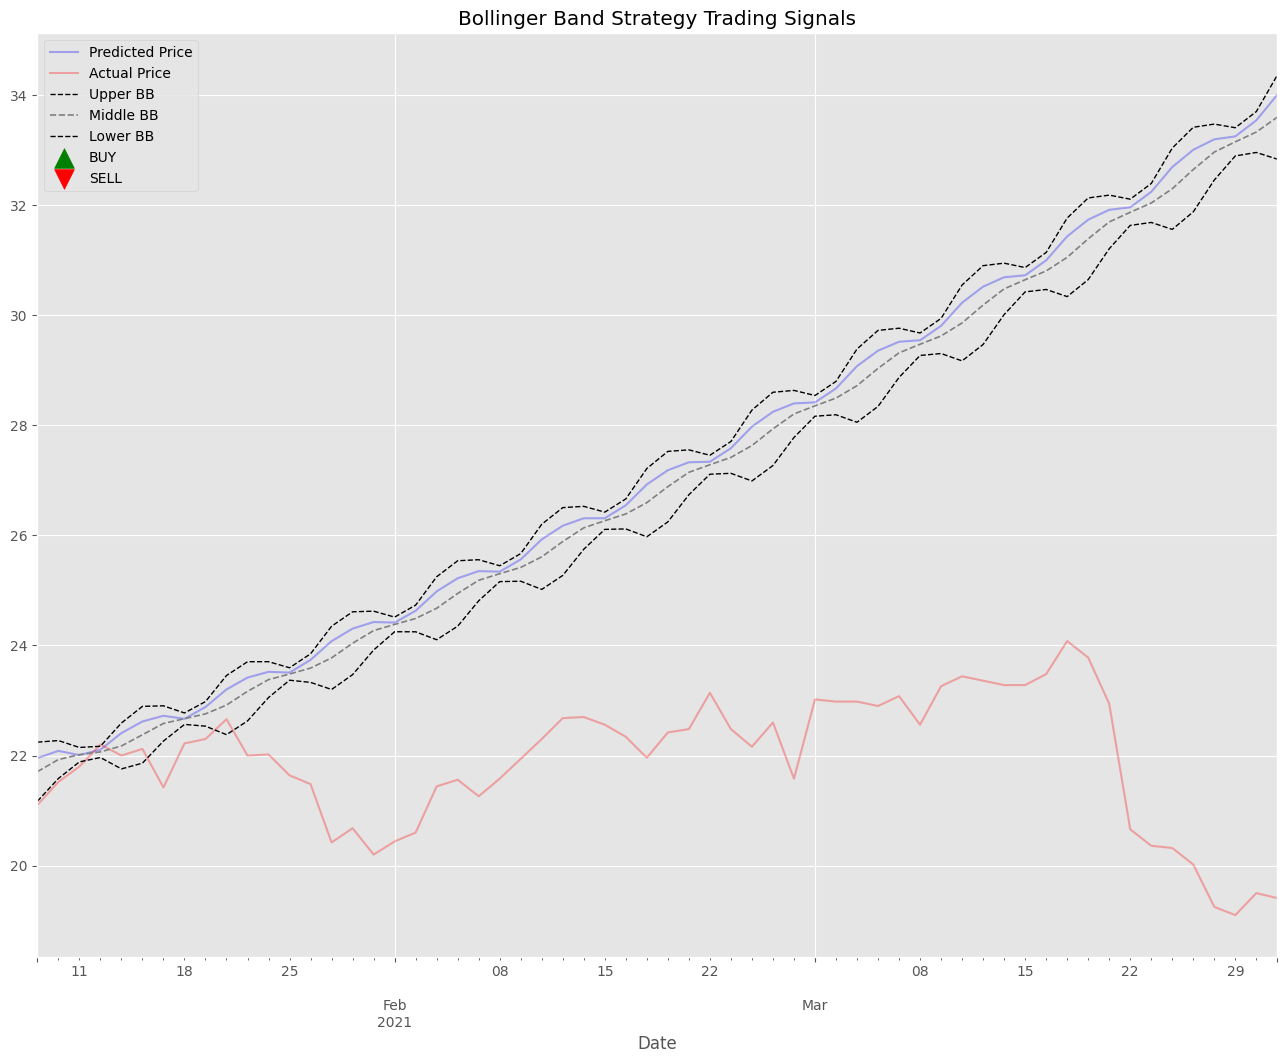

Return using Bollinger Band Strategy is 0%.
Return from do nothing strategy is -2.09%


In [ ]:
df_pred3 = pd.DataFrame({'test_set':C_test3, 'predicted':C_pred3})
df_pred3 = bollinger_bands(df_pred2, 3)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred3['predicted'], df_pred3['lower'], df_pred3['upper'])
plot_bollinger(df_pred3, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test3)

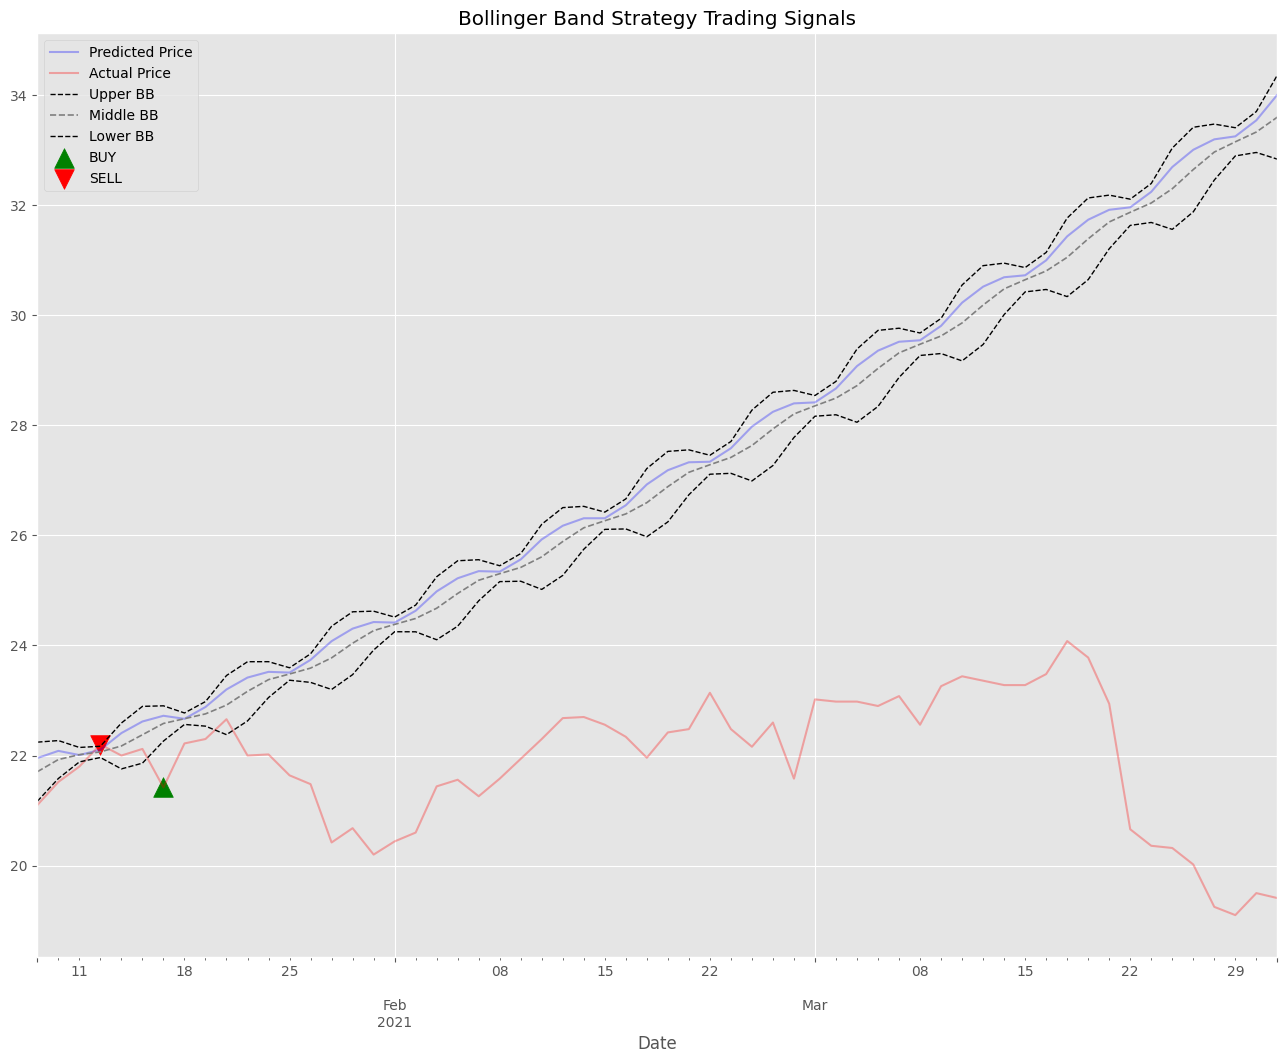

Return using Bollinger Band Strategy is 0.0%.
Return from do nothing strategy is -2.09%


In [ ]:
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred3['test_set'], df_pred3['lower'], df_pred3['upper'])
plot_bollinger(df_pred3, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test3)

# Minerva SABrazil (BEEF)

In [ ]:
df4.head(), df4.tail()

(            Price   Open   High    Low    Vol.  Change %
 Date                                                    
 2021-03-31  10.20  10.35  10.40  10.12   7.77M   -0.0154
 2021-03-30  10.36  10.41  10.62  10.30   9.93M   -0.0105
 2021-03-29  10.47   9.85  10.50   9.81  22.04M    0.0651
 2021-03-26   9.83   9.80   9.94   9.70   5.11M    0.0031
 2021-03-25   9.80  10.01  10.01   9.66   8.88M   -0.0151,
             Price   Open   High    Low   Vol.  Change %
 Date                                                   
 2020-01-08  13.63  13.50  13.68  13.18  6.18M    0.0111
 2020-01-07  13.48  13.03  13.48  13.03  8.20M    0.0458
 2020-01-06  12.89  12.90  12.91  12.57  4.17M   -0.0008
 2020-01-03  12.90  12.45  12.93  12.27  4.88M    0.0263
 2020-01-02  12.57  12.88  12.99  12.57  5.78M   -0.0210)

In [ ]:
# Apply the conversion function to the 'value' column
df4['Vol.'] = df4['Vol.'].apply(convert_to_numeric)

Brazil - Minerva SABrazil (BEEF


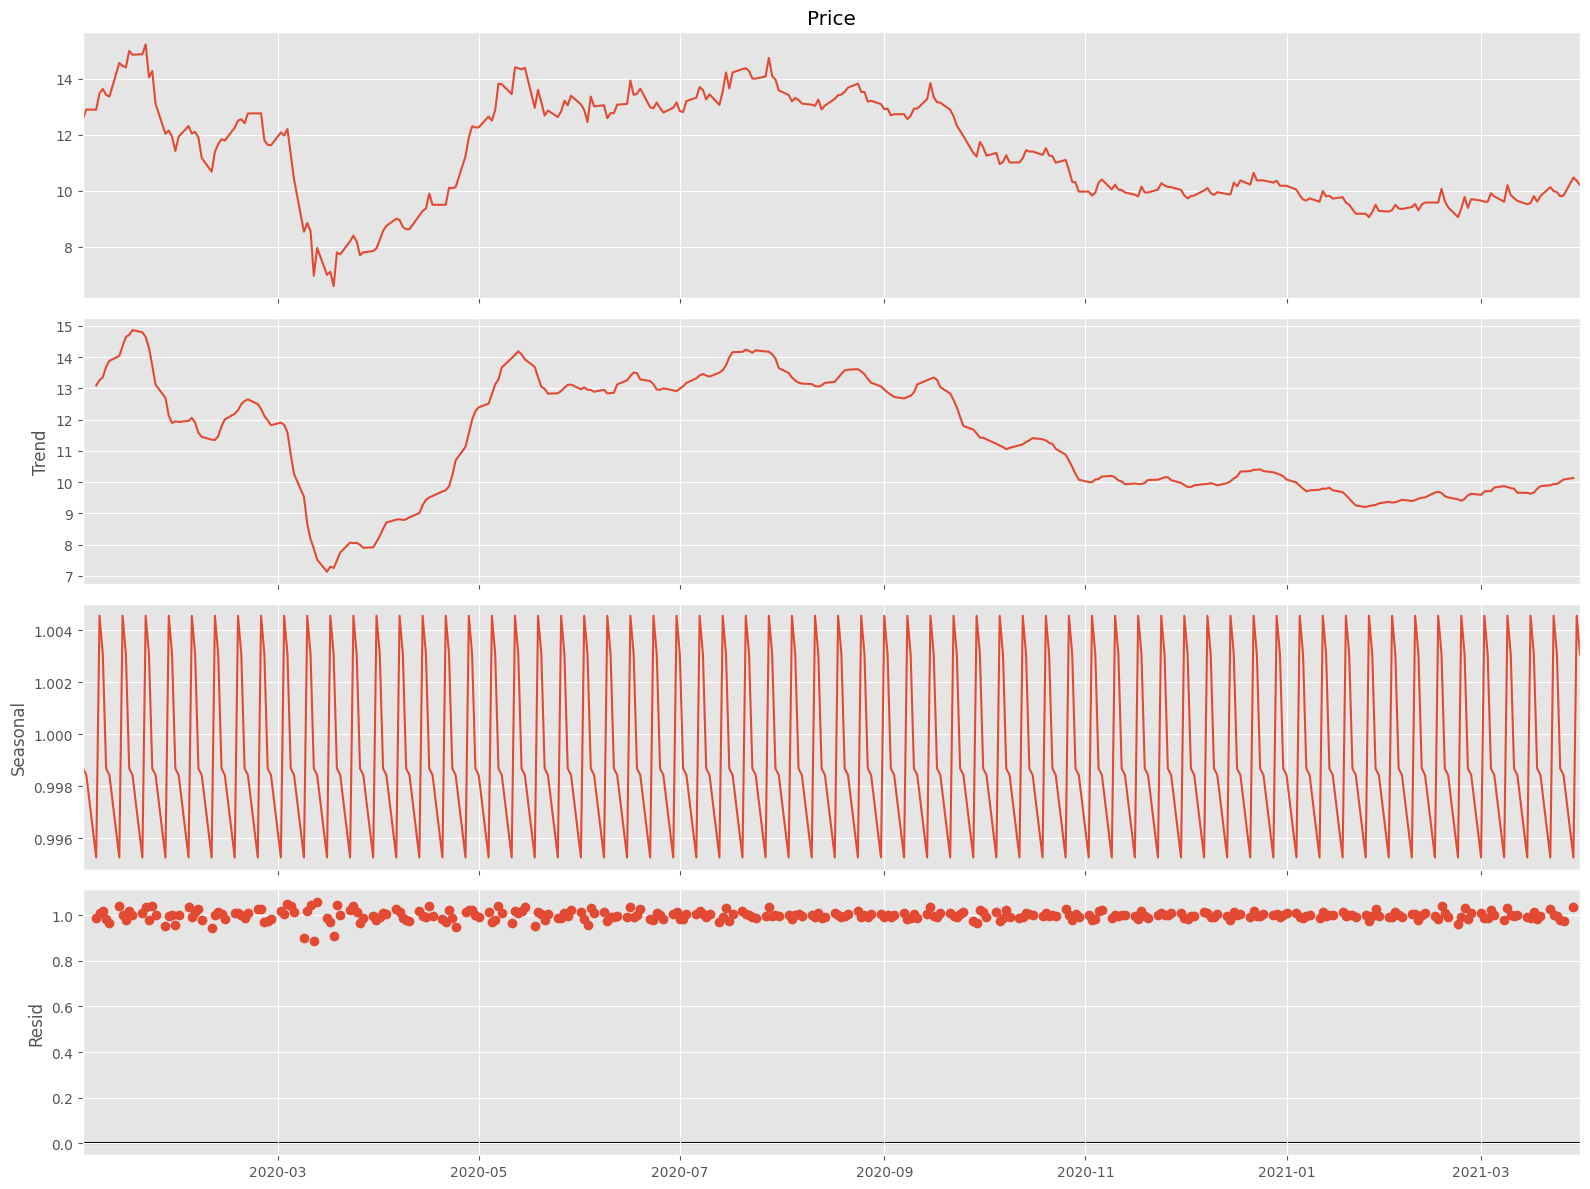

KPSS statistic: 0.6971989352500539
p-value: 0.01380009679544964
# lags : 11
KPSS statistic: 0.06407335315325179
p-value: 0.1
# lags : 10


In [ ]:
company = list(df_f.keys())[3]
print(company)
df4 = df_f[company]

df4 = df4.resample('B').mean()
df4.fillna(method = 'ffill', inplace = True)

decomposition = seasonal_decompose(df4['Price'], model='multiplicative')
decomposition.plot()
mpl.show()
# Set y value
C4 = df4['Price']
# Check for stationarity
get_kpss_stat(C4)

C_d4 = C4.diff(5).dropna()
get_kpss_stat(C_d4)

In [ ]:
train_len4 = (C4.index.year==2020).sum()
C_train4 = C4[:train_len4]
C_test4 = C4[train_len4:]


train_len_d4 = (C_d4.index.year==2020).sum()
C_d_train4 = C_d4[:train_len_d4]
C_d_test4 = C_d4[train_len_d4:]

In [ ]:
pdq_ARIMA = auto_arima(C_d_train4, trace = True)
p,d,q = pdq_ARIMA.order

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=438.986, Time=3.36 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=709.590, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=437.432, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=563.554, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=708.430, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=439.416, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=439.420, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=436.447, Time=0.52 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=432.841, Time=0.43 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=436.550, Time=0.15 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=429.653, Time=0.30 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=429.506, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=421.938, Time=0.23 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=401.756, Time=0.36 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=inf, 

In [ ]:
total_len4= C4.shape[0]
train_len4 = (C4.index.year==2020).sum()
model = SARIMAX(C_train4, order = (p,d+1,q), seasonal_order= (p,d+1,q,6))
model = model.fit()
C_pred4 = model.predict(start = train_len4, end = total_len4-1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Price   No. Observations:                  261
Model:             SARIMAX(5, 1, 1)x(5, 1, 1, 6)   Log Likelihood                -133.235
Date:                           Tue, 06 Aug 2024   AIC                            292.469
Time:                                   02:50:06   BIC                            338.455
Sample:                               01-02-2020   HQIC                           310.969
                                    - 12-31-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1215      2.800     -0.043      0.965      -5.609       5.366
ar.L2          0.1432      0.295      0.486      0.627      -0.434       0.720
ar.L3          0.1841      0.426      0.432      0.666      -0.652       1.020
ar.L4          0.0068      0.530      0.013      0.990      -1.031       1.045
ar.L5         -0.0854      0.060     -1.434      0.151      -0.202       0.031
ma.L1          0.0174      2.791      0.006      0.995      -5.452       5.487
ar.S.L6        0.0218      0.261      0.084      0.933      -0.489       0.533
ar.S.L12      -0.0060      0.073     -0.082      0.935      -0.149       0.137
ar.S.L18      -0.1238      0.075     -1.656      0.098      -0.270       0.023
ar.S.L24       0.0189      0.101      0.187      0.852      -0.179       0.217
ar.S.L30       0.0311      0.076      0.410      0.681      -0.117       0.180
ma.S.L6       -0.9968      0.975     -1.022      0.307      -2.907       0.914
sigma2         0.1529      0.144      1.061      0.289      -0.130       0.435
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                33.64
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

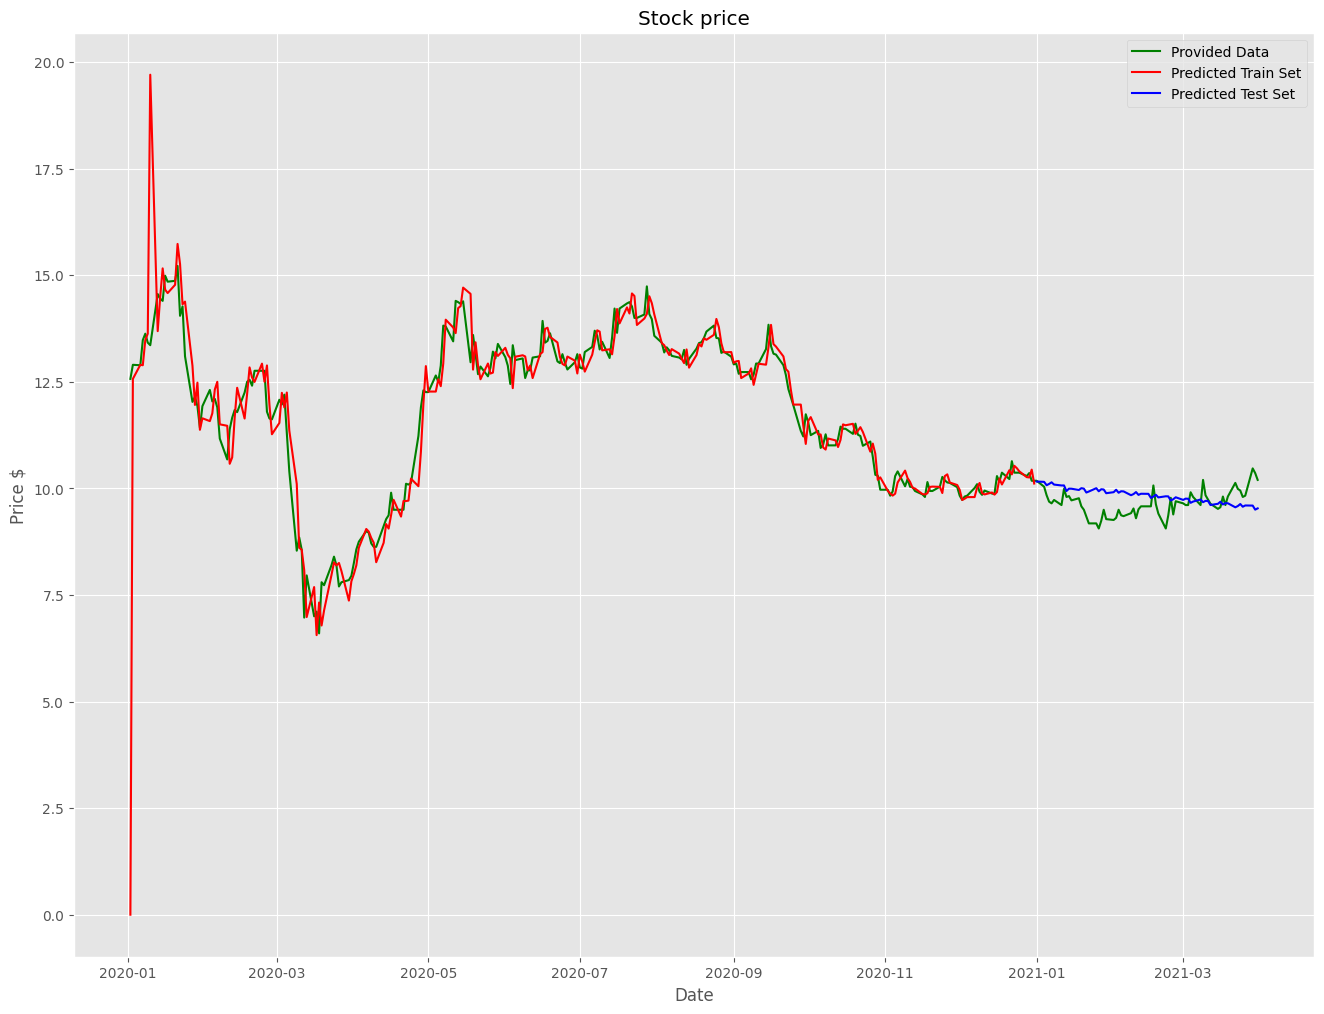

In [ ]:
#plot of showing prediced data Vs. Actual data

mpl.plot(C4, color = 'g', label = 'Provided Data')
mpl.plot(model.predict(), color = 'r', label = 'Predicted Train Set')

C_pred4.index = C_test4.index
mpl.plot(C_pred4, color = 'b', label = 'Predicted Test Set')
mpl.xlabel('Date')
mpl.ylabel('Price $')
mpl.title('Stock price')
mpl.legend()
mpl.show()

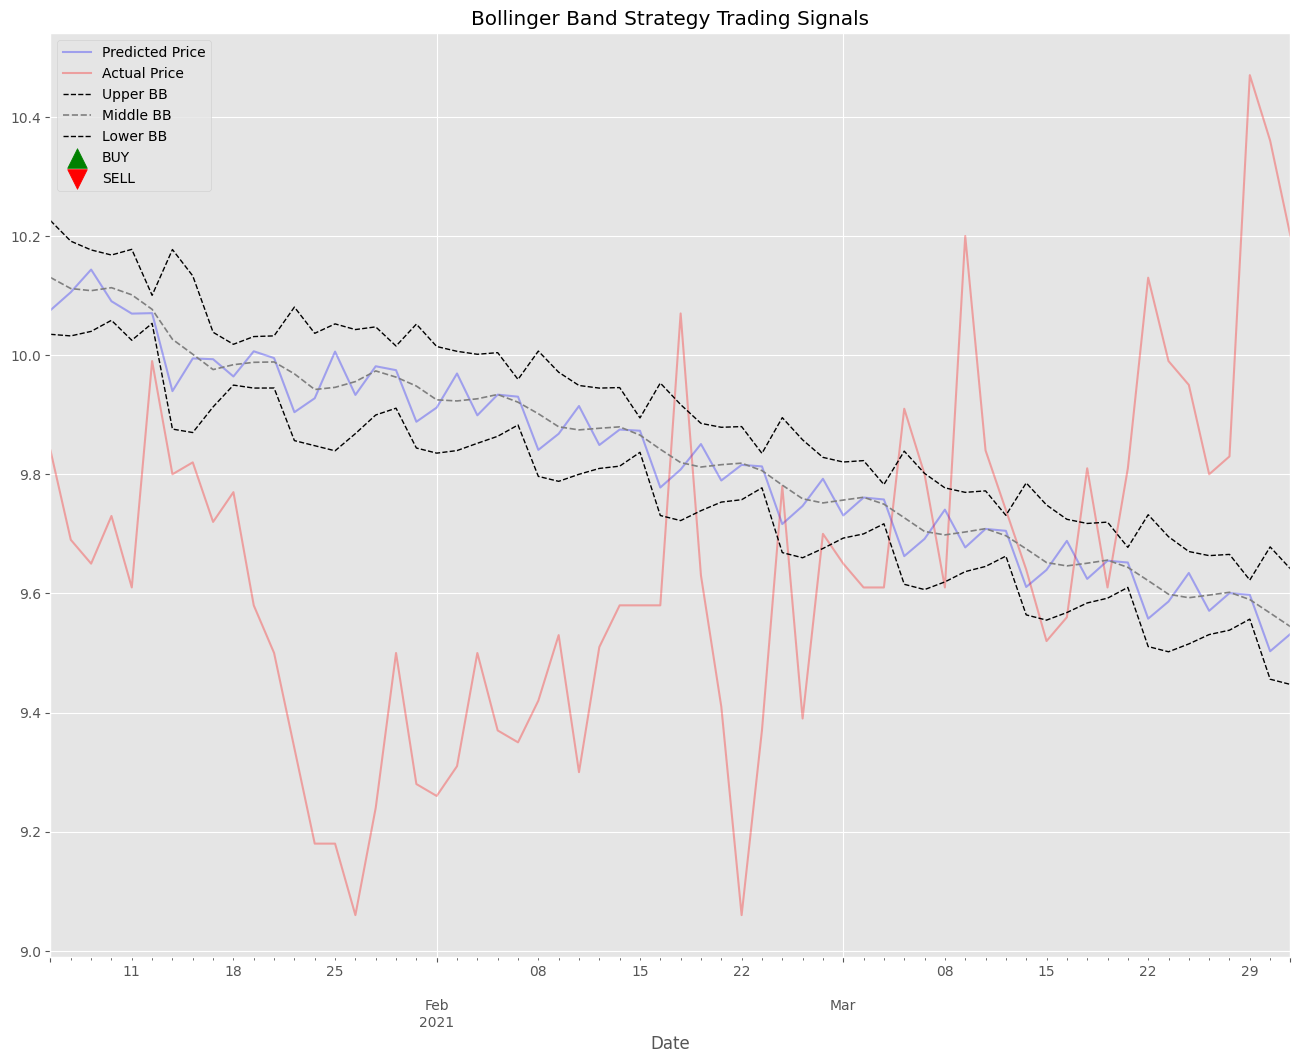

Return using Bollinger Band Strategy is 0%.
Return from do nothing strategy is 0.2%


In [ ]:
df_pred4 = pd.DataFrame({'test_set':C_test4, 'predicted':C_pred4})
df_pred4 = bollinger_bands(df_pred4, 3)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred4['predicted'], df_pred4['lower'], df_pred4['upper'])
plot_bollinger(df_pred4, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test4)

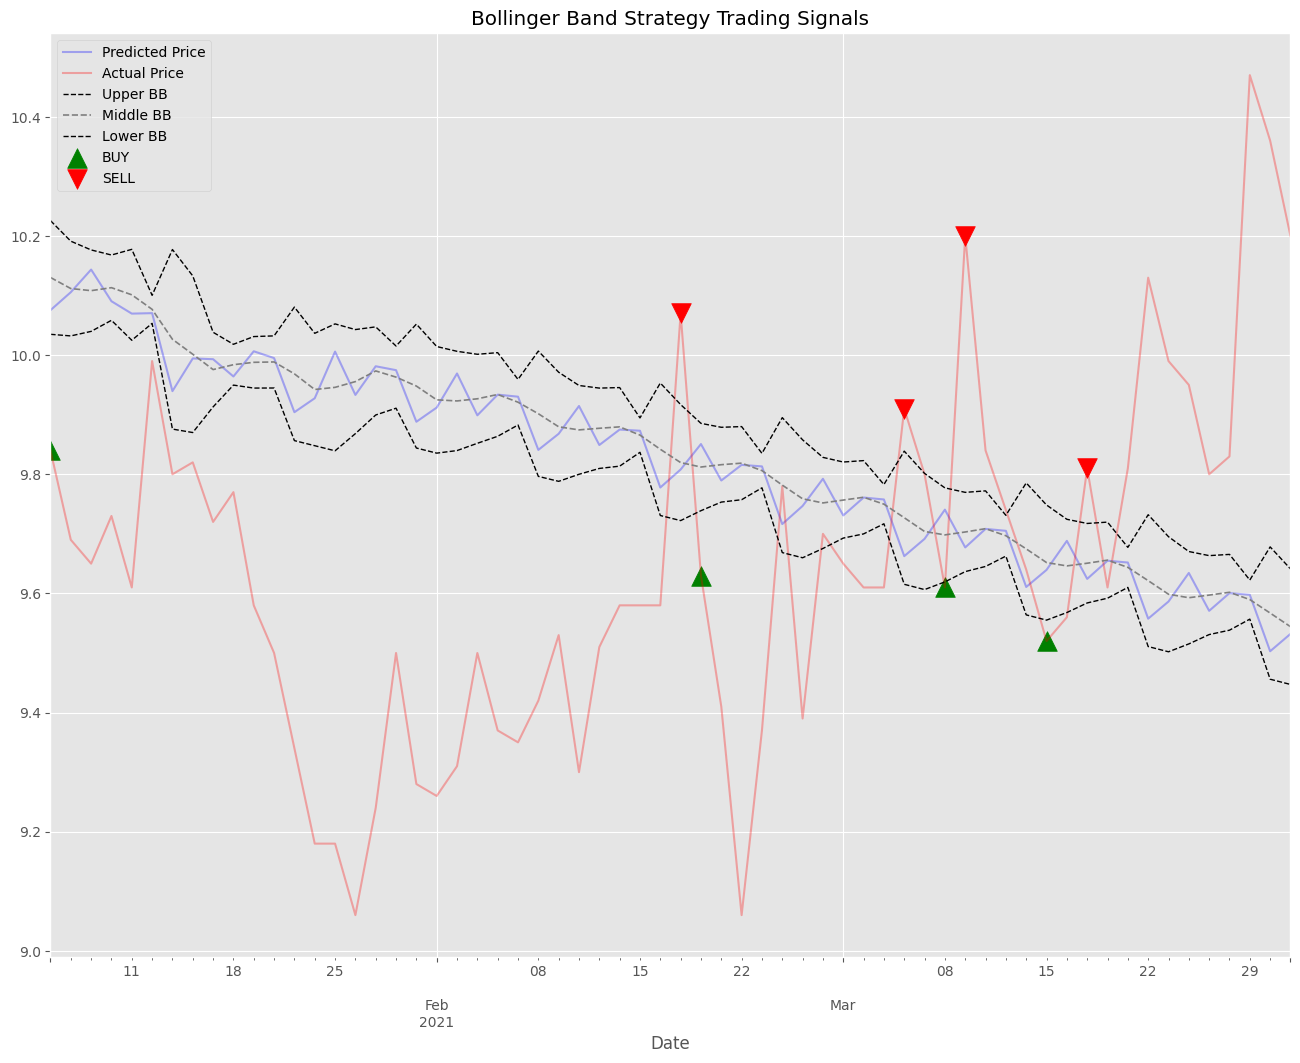

Return using Bollinger Band Strategy is 14.13%.
Return from do nothing strategy is 0.2%


In [ ]:
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred4['test_set'], df_pred4['lower'], df_pred4['upper'])
plot_bollinger(df_pred4, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test4)

# Argentina - Pampa Energia SA (P)

In [ ]:
df5.head(), df5.tail()

(            Price   Open   High    Low     Vol.  Change %
 Date                                                     
 2021-03-31  85.15  86.50  88.10  85.15  564.30K   -0.0110
 2021-03-30  86.10  85.15  86.75  84.60  141.40K    0.0129
 2021-03-29  85.00  80.00  86.00  79.00  371.22K    0.0385
 2021-03-26  81.85  84.00  84.60  80.70  462.55K   -0.0209
 2021-03-25  83.60  85.20  87.30  82.10  389.78K   -0.0313,
             Price   Open   High    Low     Vol.  Change %
 Date                                                     
 2020-01-08  46.50  47.50  47.50  46.00    1.18M   -0.0231
 2020-01-07  47.60  48.35  49.00  46.90  901.95K   -0.0186
 2020-01-06  48.50  48.40  48.70  47.00  719.24K   -0.0061
 2020-01-03  48.80  48.25  49.45  46.50  595.36K    0.0114
 2020-01-02  48.25  49.35  50.20  47.55  878.50K   -0.0292)

In [ ]:
# Apply the conversion function to the 'value' column
df5['Vol.'] = df5['Vol.'].apply(convert_to_numeric)

Argentina - Pampa Energia SA (P


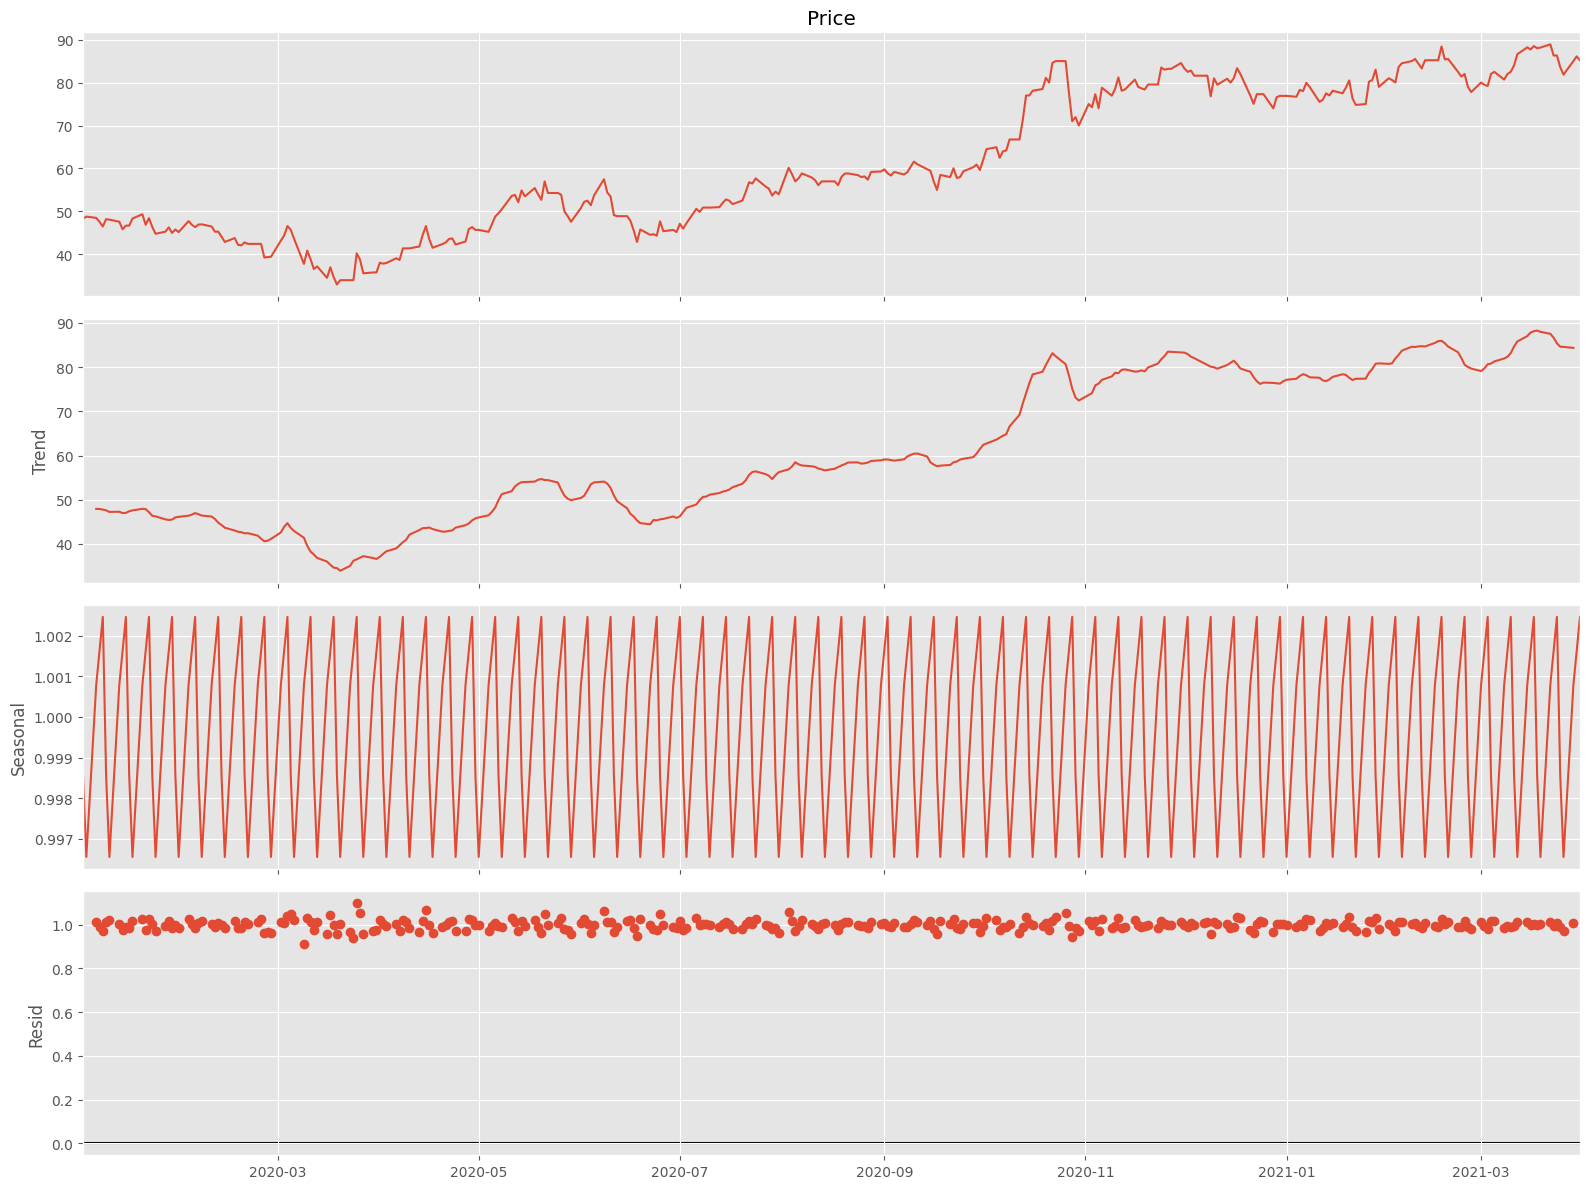

KPSS statistic: 2.59218734672206
p-value: 0.01
# lags : 11
KPSS statistic: 0.1155011175664912
p-value: 0.1
# lags : 9


In [ ]:
company = list(df_f.keys())[4]
print(company)
df5 = df_f[company]

df5 = df5.resample('B').mean()
df5.fillna(method = 'ffill', inplace = True)

decomposition = seasonal_decompose(df5['Price'], model='multiplicative')
decomposition.plot()
mpl.show()
# Set y value
C5 = df5['Price']
# Check for stationarity
get_kpss_stat(C5)

C_d5 = C5.diff(5).dropna()
get_kpss_stat(C_d5)

In [ ]:
train_len5 = (C5.index.year==2020).sum()
C_train5 = C5[:train_len5]
C_test5 = C5[train_len5:]


train_len_d5 = (C_d5.index.year==2020).sum()
C_d_train5 = C_d5[:train_len_d5]
C_d_test5 = C_d5[train_len_d5:]

In [ ]:
pdq_ARIMA = auto_arima(C_d_train5, trace = True)
p,d,q = pdq_ARIMA.order

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1195.958, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1441.009, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1221.933, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1316.279, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1443.875, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1216.708, Time=0.27 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1220.531, Time=0.26 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1208.118, Time=0.42 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.82 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1223.562, Time=0.26 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1200.996, Time=0.44 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1211.170, Time=0.38 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1195.597, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1

In [ ]:
total_len5= C5.shape[0]
train_len5 = (C5.index.year==2020).sum()
model = SARIMAX(C_train5, order = (p,d+1,q), seasonal_order= (p,d+1,q,5))
model = model.fit()
C_pred5 = model.predict(start = train_len5, end = total_len5-1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Price   No. Observations:                  261
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 5)   Log Likelihood                -544.556
Date:                           Tue, 06 Aug 2024   AIC                           1107.112
Time:                                   02:53:57   BIC                           1138.984
Sample:                               01-02-2020   HQIC                          1119.932
                                    - 12-31-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0599      0.556      0.108      0.914      -1.030       1.149
ar.L2          0.5785      0.334      1.732      0.083      -0.076       1.233
ma.L1         -0.1759      0.572     -0.308      0.758      -1.297       0.945
ma.L2         -0.5505      0.358     -1.538      0.124      -1.252       0.151
ar.S.L5       -0.3985      0.468     -0.851      0.395      -1.316       0.519
ar.S.L10      -0.0630      0.103     -0.610      0.542      -0.265       0.139
ma.S.L5       -0.5084      0.539     -0.944      0.345      -1.565       0.548
ma.S.L10      -0.4857      0.511     -0.950      0.342      -1.488       0.516
sigma2         3.8869      1.158      3.357      0.001       1.618       6.156
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                31.51
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.82   Skew:                            -0.15
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

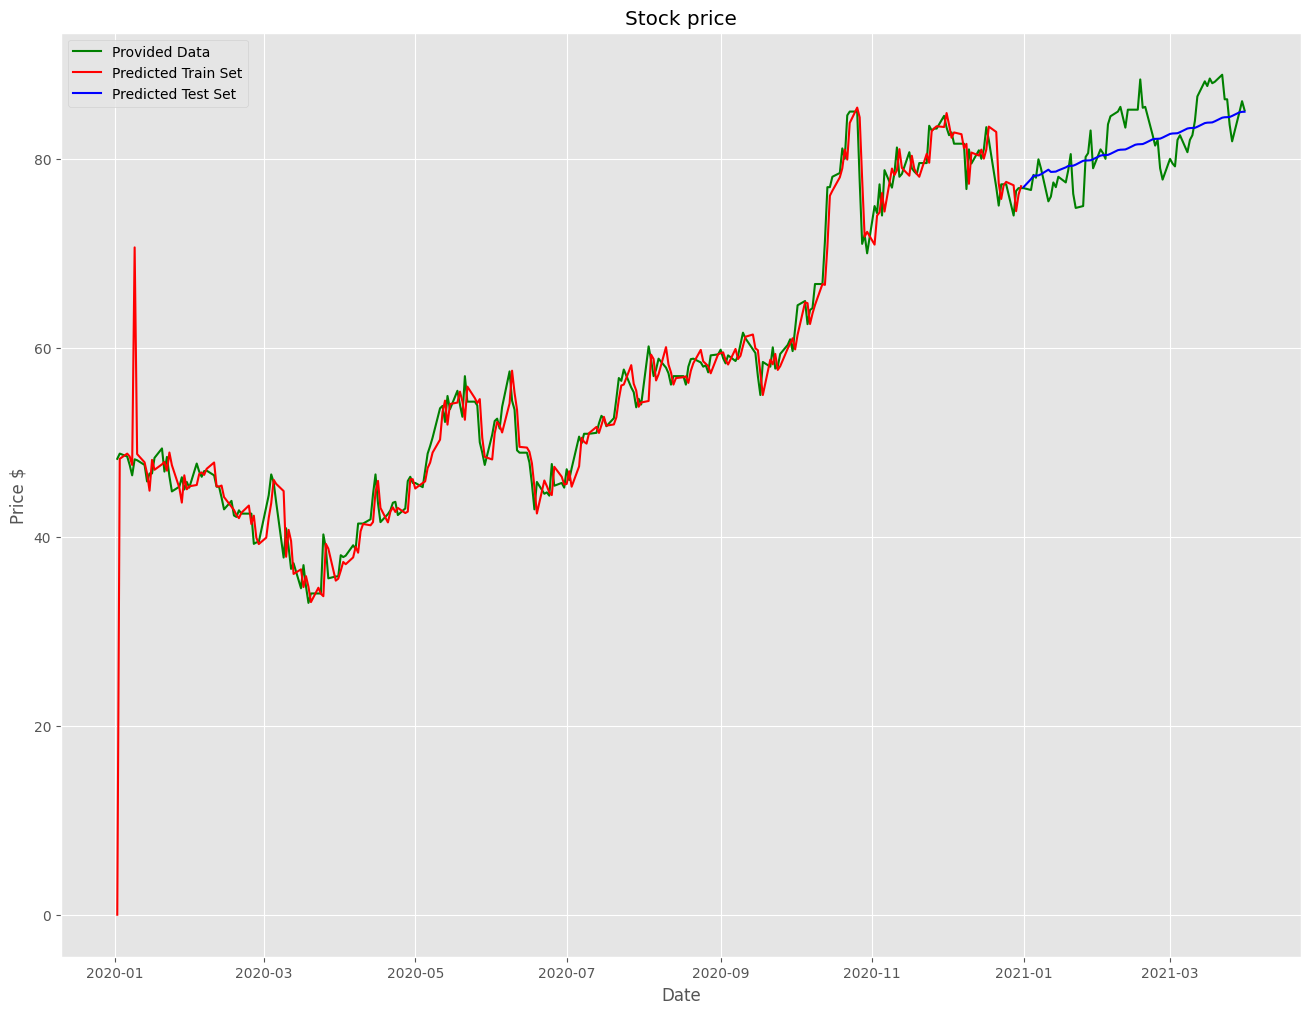

In [ ]:
#plot of showing prediced data Vs. Actual data

mpl.plot(C5, color = 'g', label = 'Provided Data')
mpl.plot(model.predict(), color = 'r', label = 'Predicted Train Set')

C_pred5.index = C_test5.index
mpl.plot(C_pred5, color = 'b', label = 'Predicted Test Set')
mpl.xlabel('Date')
mpl.ylabel('Price $')
mpl.title('Stock price')
mpl.legend()
mpl.show()

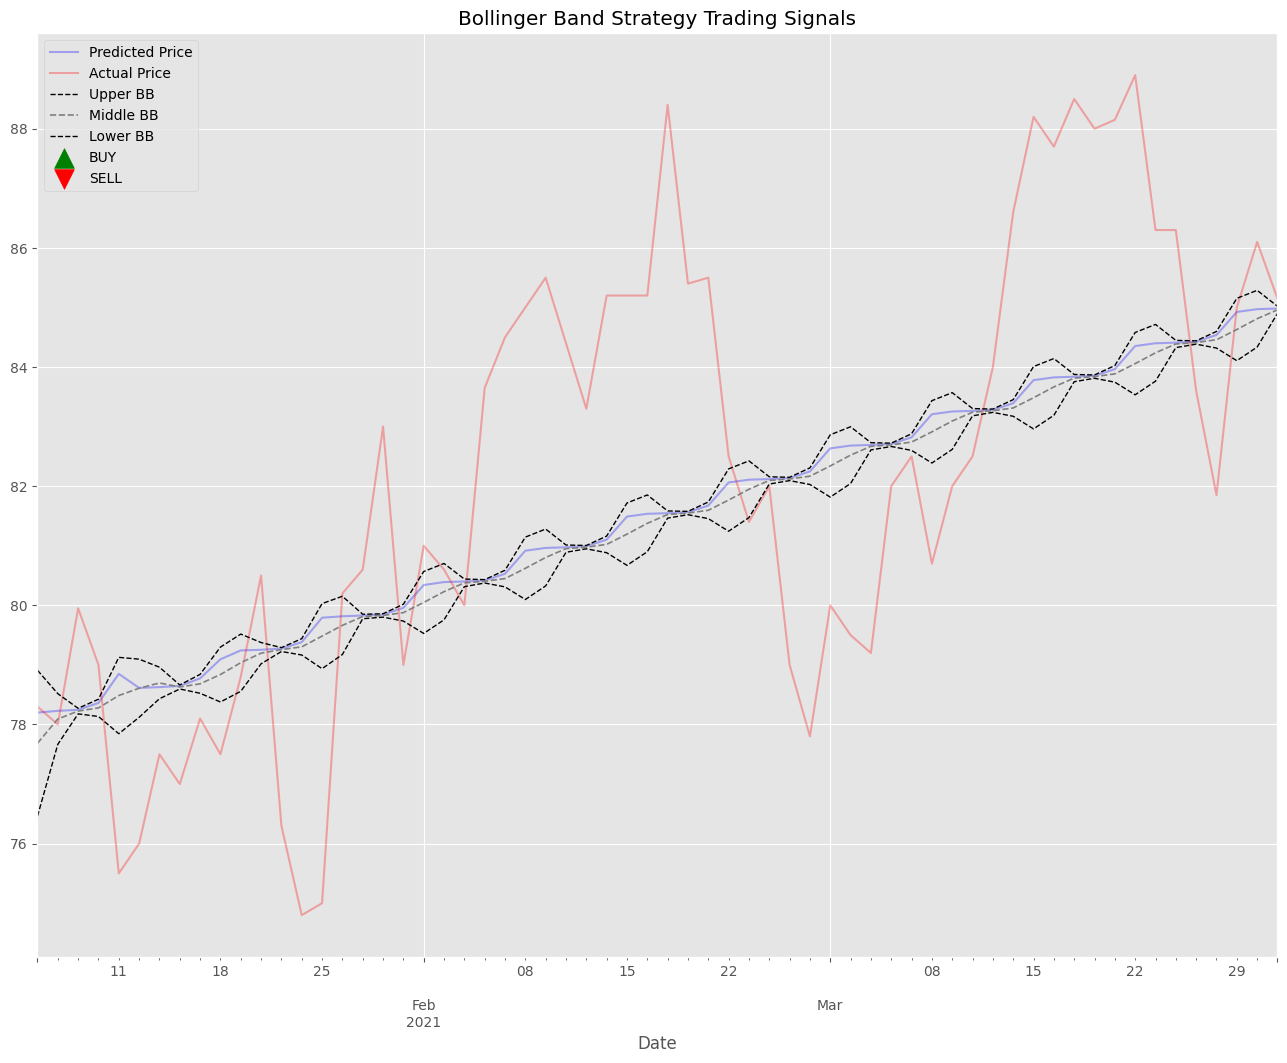

Return using Bollinger Band Strategy is 0%.
Return from do nothing strategy is 10.73%


In [ ]:
df_pred5 = pd.DataFrame({'test_set':C_test5, 'predicted':C_pred5})
df_pred5 = bollinger_bands(df_pred5, 3)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred5['predicted'], df_pred5['lower'], df_pred5['upper'])
plot_bollinger(df_pred5, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test5)

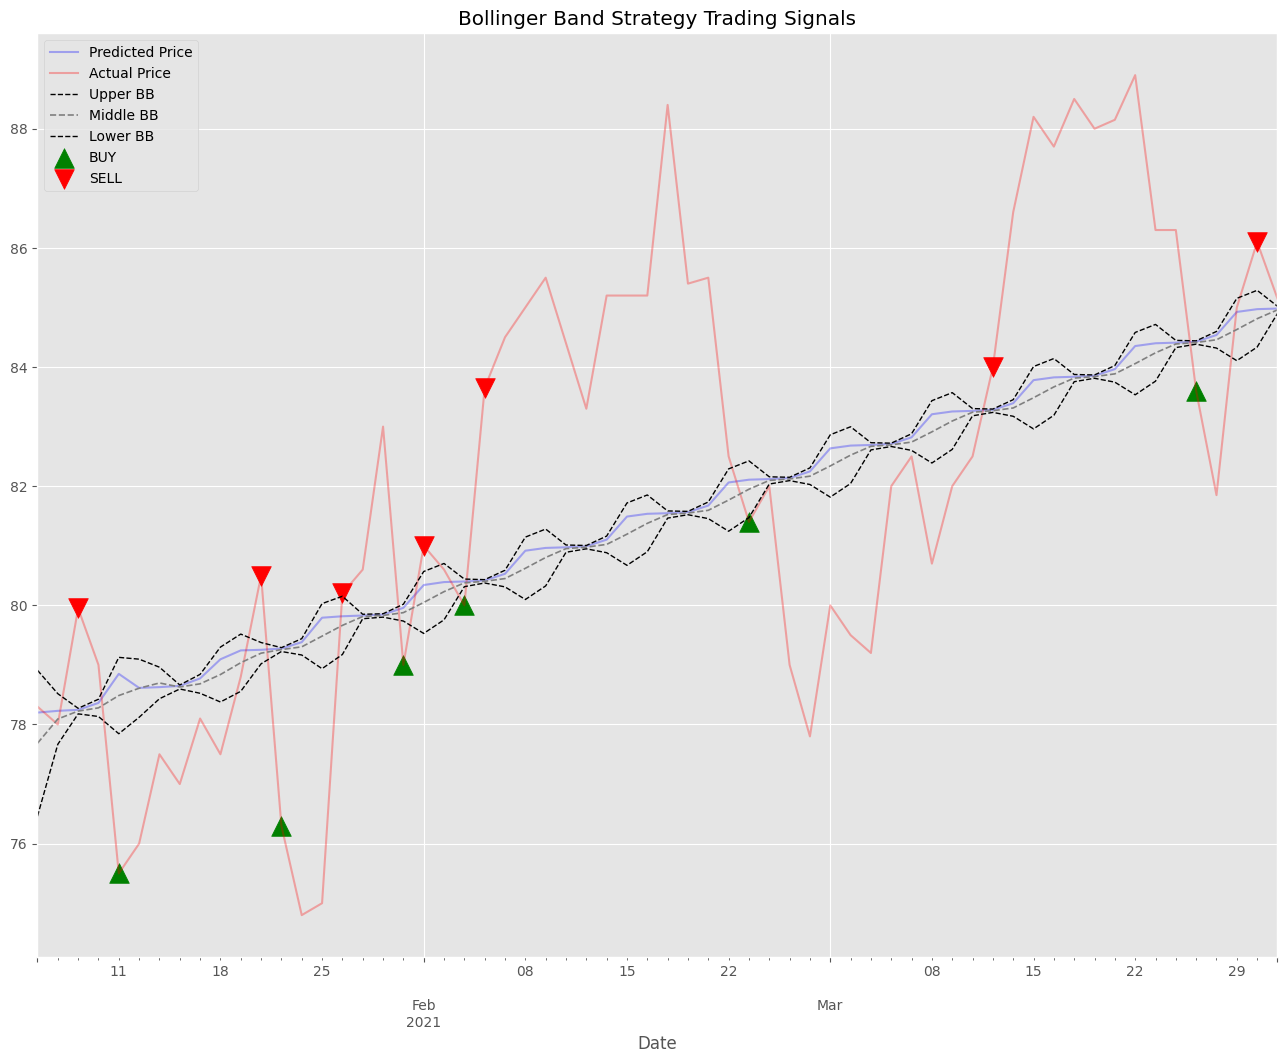

Return using Bollinger Band Strategy is 26.03%.
Return from do nothing strategy is 10.73%


In [ ]:
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred5['test_set'], df_pred5['lower'], df_pred5['upper'])
plot_bollinger(df_pred5, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test5)

# Colombia - Cementos Argos SA (C)

In [ ]:
df6.head(), df6.tail()

(            Price  Open  High   Low     Vol.  Change %
 Date                                                  
 2021-03-31   5150  5100  5170  5100  212.44K    0.0098
 2021-03-30   5100  5010  5100  5010  583.70K    0.0109
 2021-03-29   5045  5020  5045  5015  117.54K    0.0050
 2021-03-26   5020  5085  5085  4980  203.46K   -0.0020
 2021-03-25   5030  5035  5045  4950  317.06K    0.0010,
             Price  Open  High   Low     Vol.  Change %
 Date                                                  
 2020-01-09   6810  6880  6890  6800  262.89K   -0.0102
 2020-01-08   6880  6940  6950  6880   84.93K   -0.0101
 2020-01-07   6950  6950  6950  6850  168.71K   -0.0071
 2020-01-03   7000  7040  7100  6960  470.77K   -0.0169
 2020-01-02   7120  7300  7300  7120  138.96K   -0.0247)

In [ ]:
# Apply the conversion function to the 'value' column
df6['Vol.'] = df6['Vol.'].apply(convert_to_numeric)

Colombia - Cementos Argos SA (C


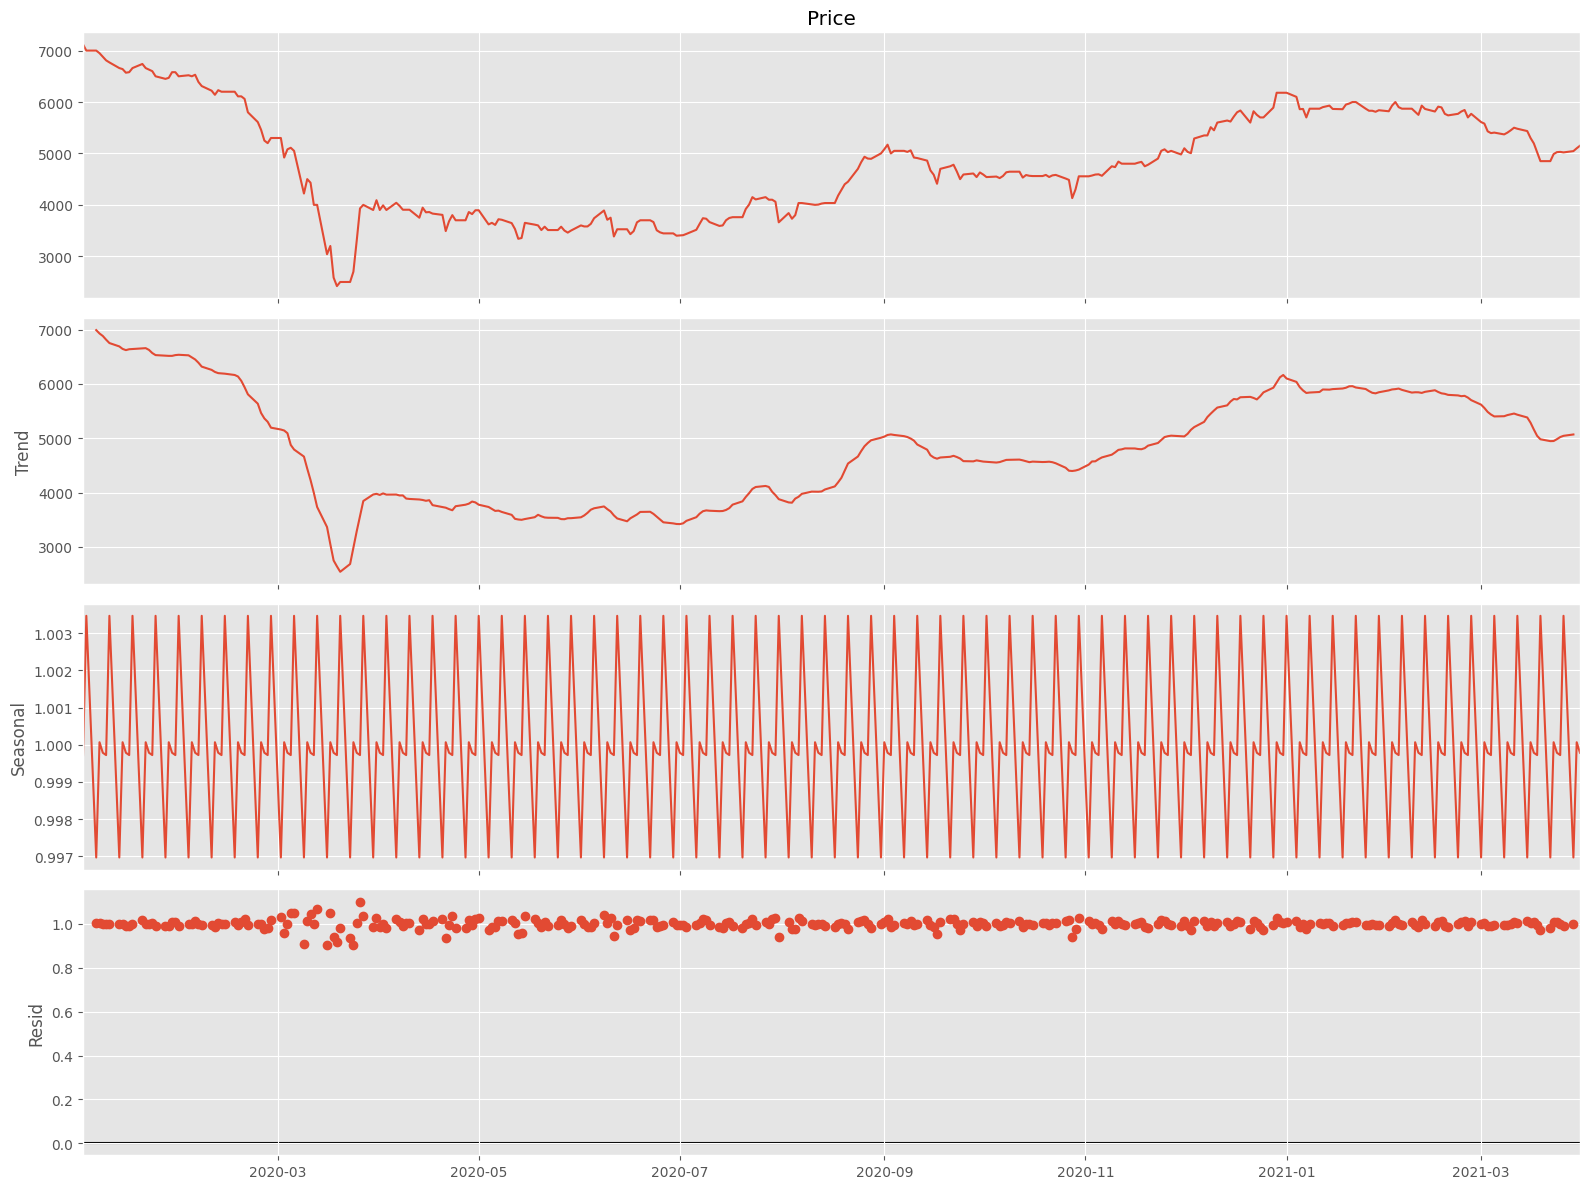

KPSS statistic: 0.611034052877101
p-value: 0.021633267920263544
# lags : 11
KPSS statistic: 0.39313625960726145
p-value: 0.08011368120376662
# lags : 10


In [ ]:
company = list(df_f.keys())[5]
print(company)
df6 = df_f[company]

df6 = df6.resample('B').mean()
df6.fillna(method = 'ffill', inplace = True)

decomposition = seasonal_decompose(df6['Price'], model='multiplicative')
decomposition.plot()
mpl.show()
# Set y value
C6 = df6['Price']
# Check for stationarity
get_kpss_stat(C6)

C_d6 = C6.diff(5).dropna()
get_kpss_stat(C_d6)

In [ ]:
train_len6 = (C6.index.year==2020).sum()
C_train6 = C6[:train_len6]
C_test6 = C6[train_len6:]


train_len_d6 = (C_d6.index.year==2020).sum()
C_d_train6 = C_d6[:train_len_d6]
C_d_test6 = C_d6[train_len_d6:]

pdq_ARIMA = auto_arima(C_d_train6, trace = True)
p,d,q = pdq_ARIMA.order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3453.829, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3454.562, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3454.783, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3451.885, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3455.441, Time=0.34 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.005 seconds


In [ ]:
total_len6= C6.shape[0]
train_len6 = (C6.index.year==2020).sum()
model = SARIMAX(C_train6, order = (p,d+1,q), seasonal_order= (p,d+1,q,5))
model = model.fit()
C_pred6 = model.predict(start = train_len6, end = total_len6-1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Price   No. Observations:                  261
Model:             SARIMAX(0, 2, 0)x(0, 2, 0, 5)   Log Likelihood               -1894.289
Date:                           Tue, 06 Aug 2024   AIC                           3790.578
Time:                                   02:59:44   BIC                           3794.095
Sample:                               01-02-2020   HQIC                          3791.993
                                    - 12-31-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       2.37e+05    1.4e+04     16.916      0.000     2.1e+05    2.64e+05
===================================================================================
Ljung-Box (L1) (Q):                  61.20   Jarque-Bera (JB):                69.73
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

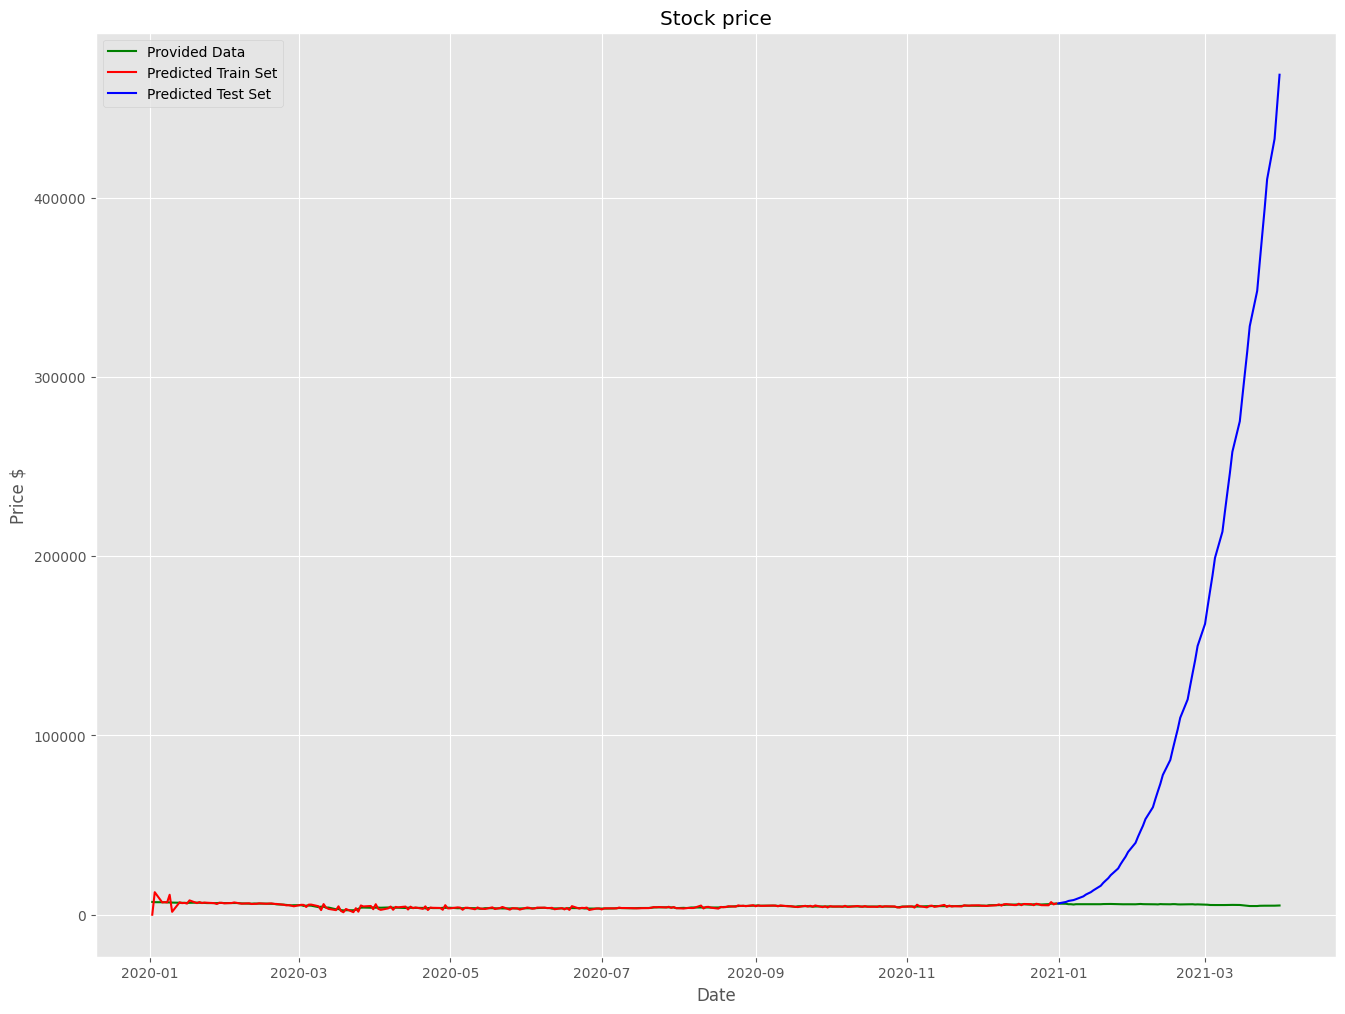

In [ ]:
#plot of showing prediced data Vs. Actual data

mpl.plot(C6, color = 'g', label = 'Provided Data')
mpl.plot(model.predict(), color = 'r', label = 'Predicted Train Set')

C_pred6.index = C_test6.index
mpl.plot(C_pred6, color = 'b', label = 'Predicted Test Set')
mpl.xlabel('Date')
mpl.ylabel('Price $')
mpl.title('Stock price')
mpl.legend()
mpl.show()

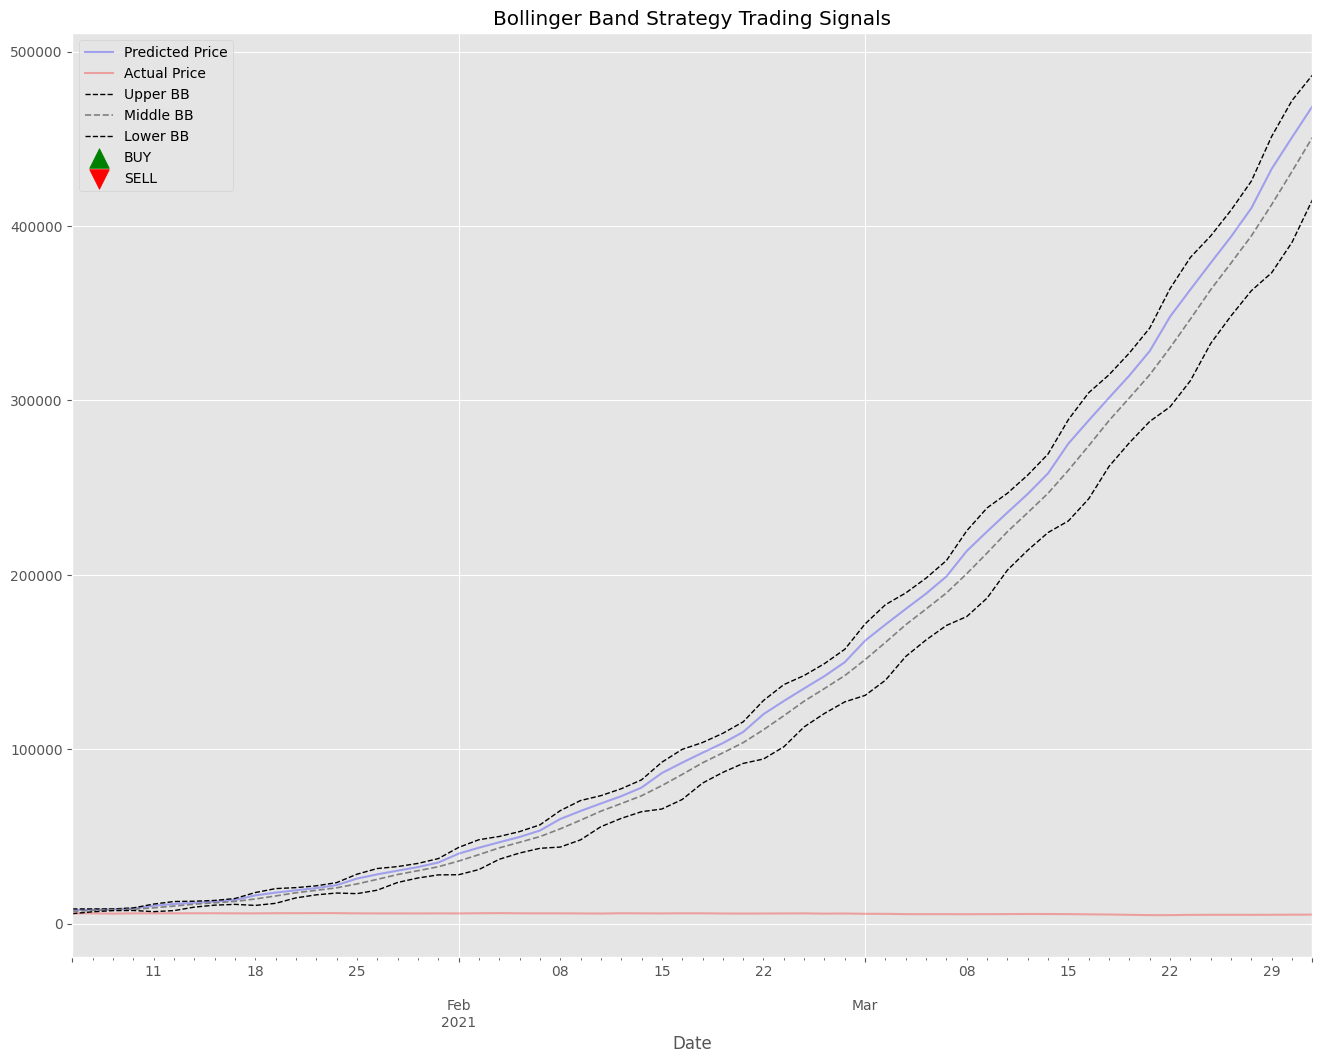

Return using Bollinger Band Strategy is 0%.
Return from do nothing strategy is -16.67%


In [ ]:
df_pred6 = pd.DataFrame({'test_set':C_test6, 'predicted':C_pred6})
df_pred6 = bollinger_bands(df_pred6, 3)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred6['predicted'], df_pred6['lower'], df_pred6['upper'])
plot_bollinger(df_pred6, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test6)

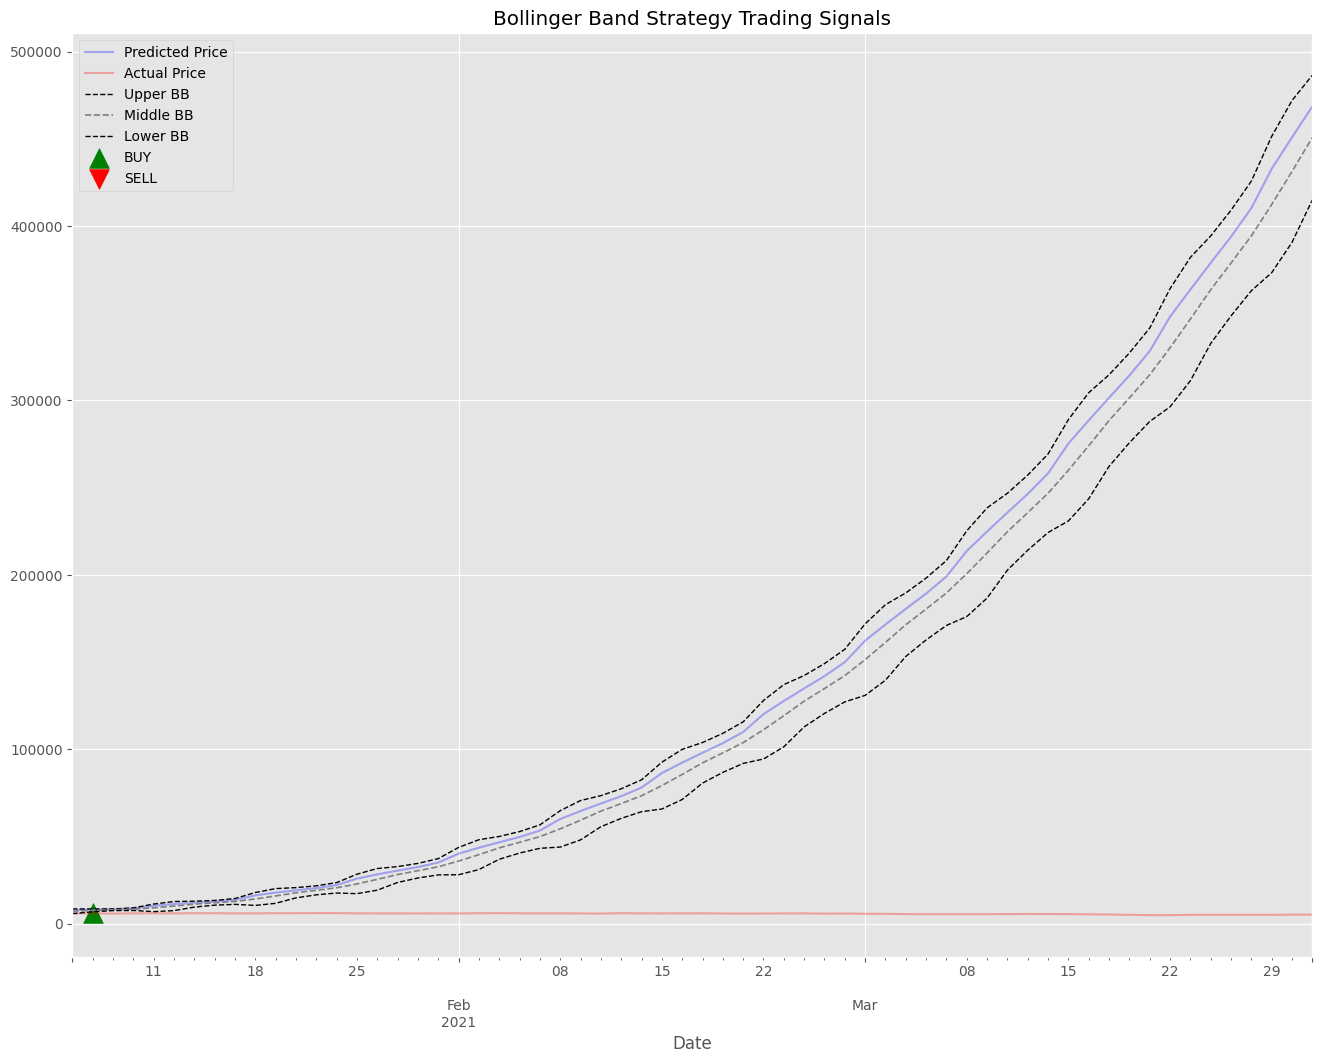

Return using Bollinger Band Strategy is 0.0%.
Return from do nothing strategy is -16.67%


In [ ]:
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred6['test_set'], df_pred6['lower'], df_pred6['upper'])
plot_bollinger(df_pred6, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test6)

# South Africa - Impala Platinum

In [ ]:
df7.head(), df7.tail()

(            Price   Open   High    Low   Vol.  Change %
 Date                                                   
 2021-03-31  27373  26980  27526  26657  2.49M    0.0177
 2021-03-30  26898  26766  27443  26360  3.02M   -0.0030
 2021-03-29  26980  27800  28174  26614  4.44M   -0.0201
 2021-03-26  27533  27083  28006  26728  3.36M    0.0365
 2021-03-25  26564  25954  27128  25954  2.83M    0.0255,
             Price   Open   High    Low   Vol.  Change %
 Date                                                   
 2020-01-08  15290  14775  15465  14468  6.24M    0.0545
 2020-01-07  14500  14688  14688  13940  3.94M   -0.0082
 2020-01-06  14620  14985  15045  14574  2.61M   -0.0150
 2020-01-03  14843  14700  14884  14360  3.19M    0.0358
 2020-01-02  14330  14525  14764  14325  2.01M   -0.0015)

In [ ]:
# Apply the conversion function to the 'value' column
df7['Vol.'] = df7['Vol.'].apply(convert_to_numeric)

South Africa - Impala Platinum 


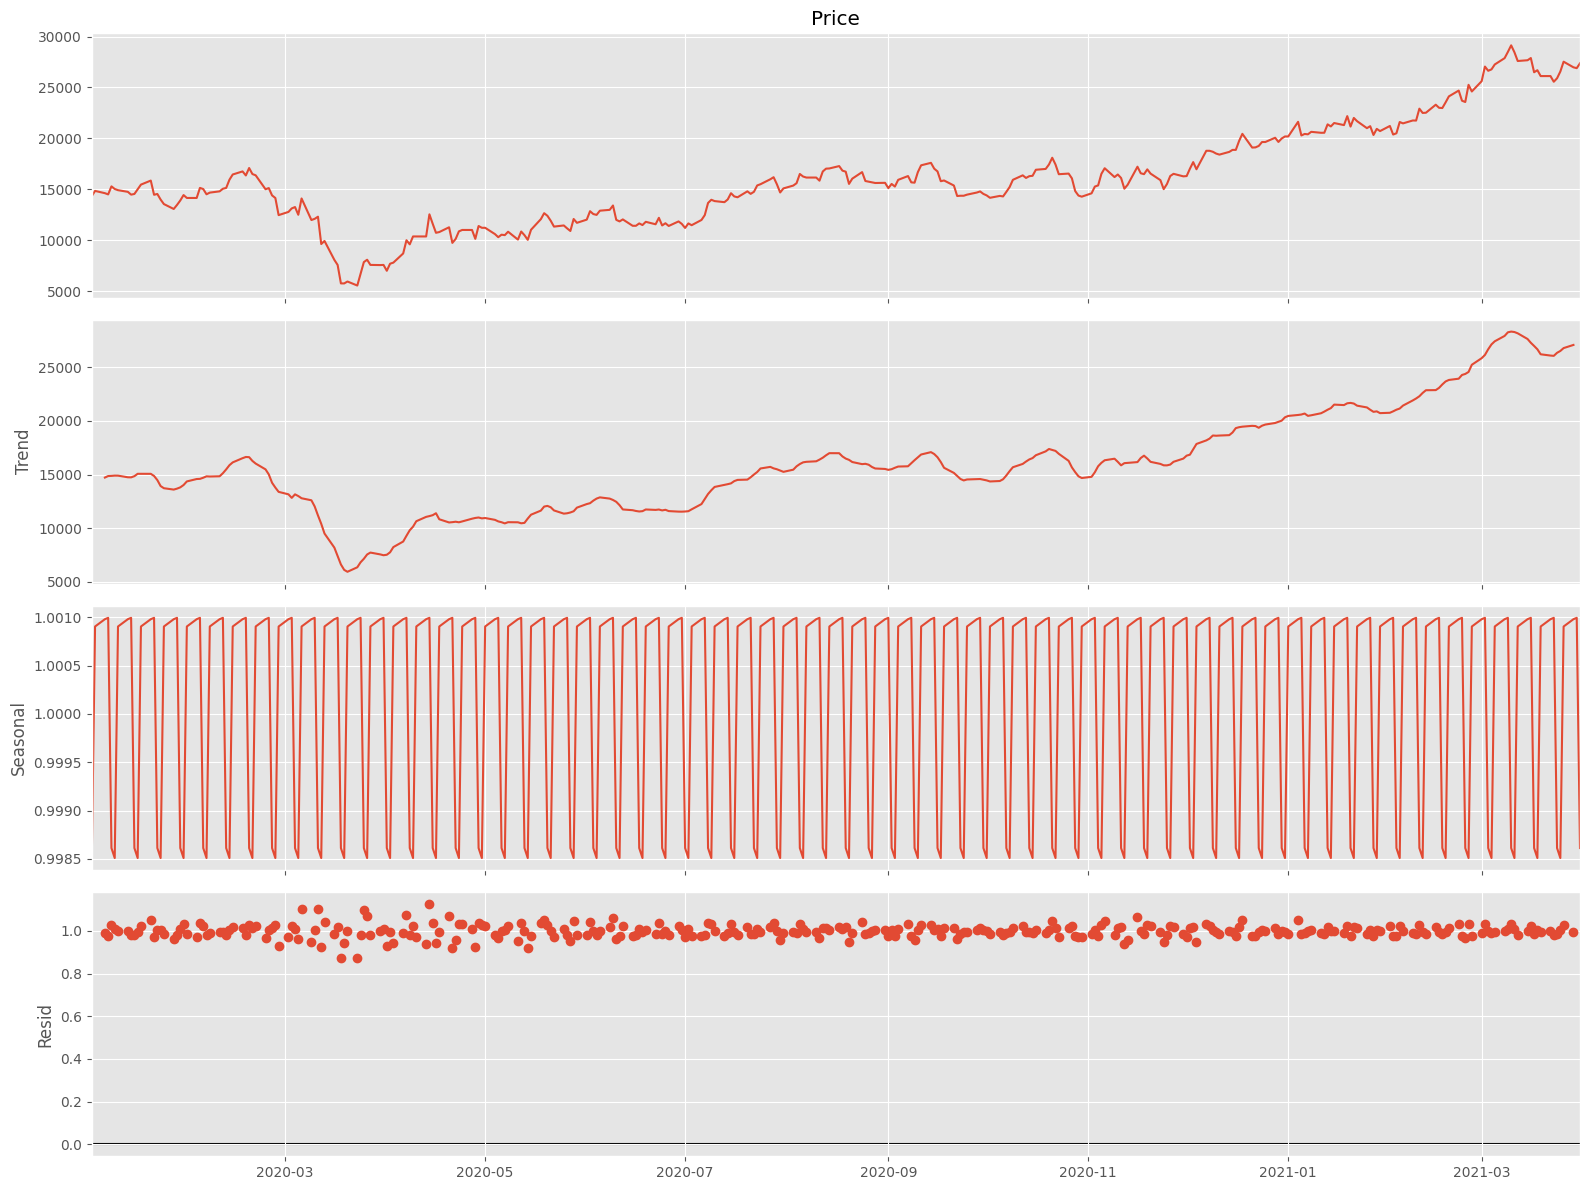

KPSS statistic: 2.034342547523028
p-value: 0.01
# lags : 11
KPSS statistic: 0.30678129670392035
p-value: 0.1
# lags : 9


In [ ]:
company = list(df_f.keys())[6]
print(company)
df7 = df_f[company]

df7 = df7.resample('B').mean()
df7.fillna(method = 'ffill', inplace = True)

decomposition = seasonal_decompose(df7['Price'], model='multiplicative')
decomposition.plot()
mpl.show()
# Set y value
C7 = df7['Price']
# Check for stationarity
get_kpss_stat(C7)

C_d7 = C7.diff(5).dropna()
get_kpss_stat(C_d7)

In [ ]:
train_len7 = (C7.index.year==2020).sum()
C_train7 = C7[:train_len7]
C_test7 = C7[train_len7:]


train_len_d7 = (C_d7.index.year==2020).sum()
C_d_train7 = C_d7[:train_len_d7]
C_d_test7 = C_d7[train_len_d7:]

pdq_ARIMA = auto_arima(C_d_train7, trace = True)
p,d,q = pdq_ARIMA.order

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4462.341, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4211.892, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4307.969, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4461.566, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4210.310, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4210.307, Time=0.19 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=4199.046, Time=0.15 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=4191.708, Time=0.96 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=4175.925, Time=2.39 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=4198.933, Time=0.43 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=4152.858, Time=2.99 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.09 sec
 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.71 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=inf, T

In [ ]:
train_len7 = (C7.index.year==2020).sum()
C_train7 = C7[:train_len7]
C_test7 = C7[train_len7:]


train_len_d7 = (C_d7.index.year==2020).sum()
C_d_train7 = C_d7[:train_len_d7]
C_d_test7 = C_d7[train_len_d7:]

pdq_ARIMA = auto_arima(C_d_train7, trace = True)
p,d,q = pdq_ARIMA.order

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4462.341, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4211.892, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4307.969, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4461.566, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4210.310, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4210.307, Time=0.12 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=4199.046, Time=0.15 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=4191.708, Time=0.19 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=4175.925, Time=0.64 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=4198.933, Time=0.24 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=4152.858, Time=0.70 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.65 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=inf, T

In [ ]:
total_len7= C7.shape[0]
train_len7 = (C7.index.year==2020).sum()
seasonal_p = 0  # Or any value other than 5
seasonal_d = d + 1
seasonal_q = q
seasonal_period = 5  # Your original seasonal period

# Create the SARIMAX model with the adjusted seasonal order
model = SARIMAX(C_train7, order=(p, d + 1, q),
                seasonal_order=(seasonal_p, seasonal_d, seasonal_q, seasonal_period))
model = model.fit()
#model = SARIMAX(C_train7, order = (p,d+1,q), seasonal_order= (p,d+1,q,5))
#model = model.fit()
C_pred7 = model.predict(start = train_len7, end = total_len7-1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Price   No. Observations:                  261
Model:             SARIMAX(5, 1, 2)x(0, 1, 2, 5)   Log Likelihood               -2041.149
Date:                           Tue, 06 Aug 2024   AIC                           4102.299
Time:                                   03:10:15   BIC                           4137.712
Sample:                               01-02-2020   HQIC                          4116.543
                                    - 12-31-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1981      0.241     -0.822      0.411      -0.670       0.274
ar.L2         -0.0338      0.177     -0.191      0.848      -0.381       0.313
ar.L3          0.0849      0.090      0.947      0.344      -0.091       0.261
ar.L4          0.0926      0.083      1.116      0.264      -0.070       0.255
ar.L5          0.4712      0.338      1.394      0.163      -0.191       1.134
ma.L1          0.1697      0.243      0.699      0.485      -0.306       0.646
ma.L2          0.0510      0.198      0.257      0.797      -0.338       0.440
ma.S.L5       -1.3411      0.386     -3.477      0.001      -2.097      -0.585
ma.S.L10       0.3629      0.358      1.015      0.310      -0.338       1.064
sigma2      6.505e+05   7.62e+04      8.540      0.000    5.01e+05       8e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                27.68
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

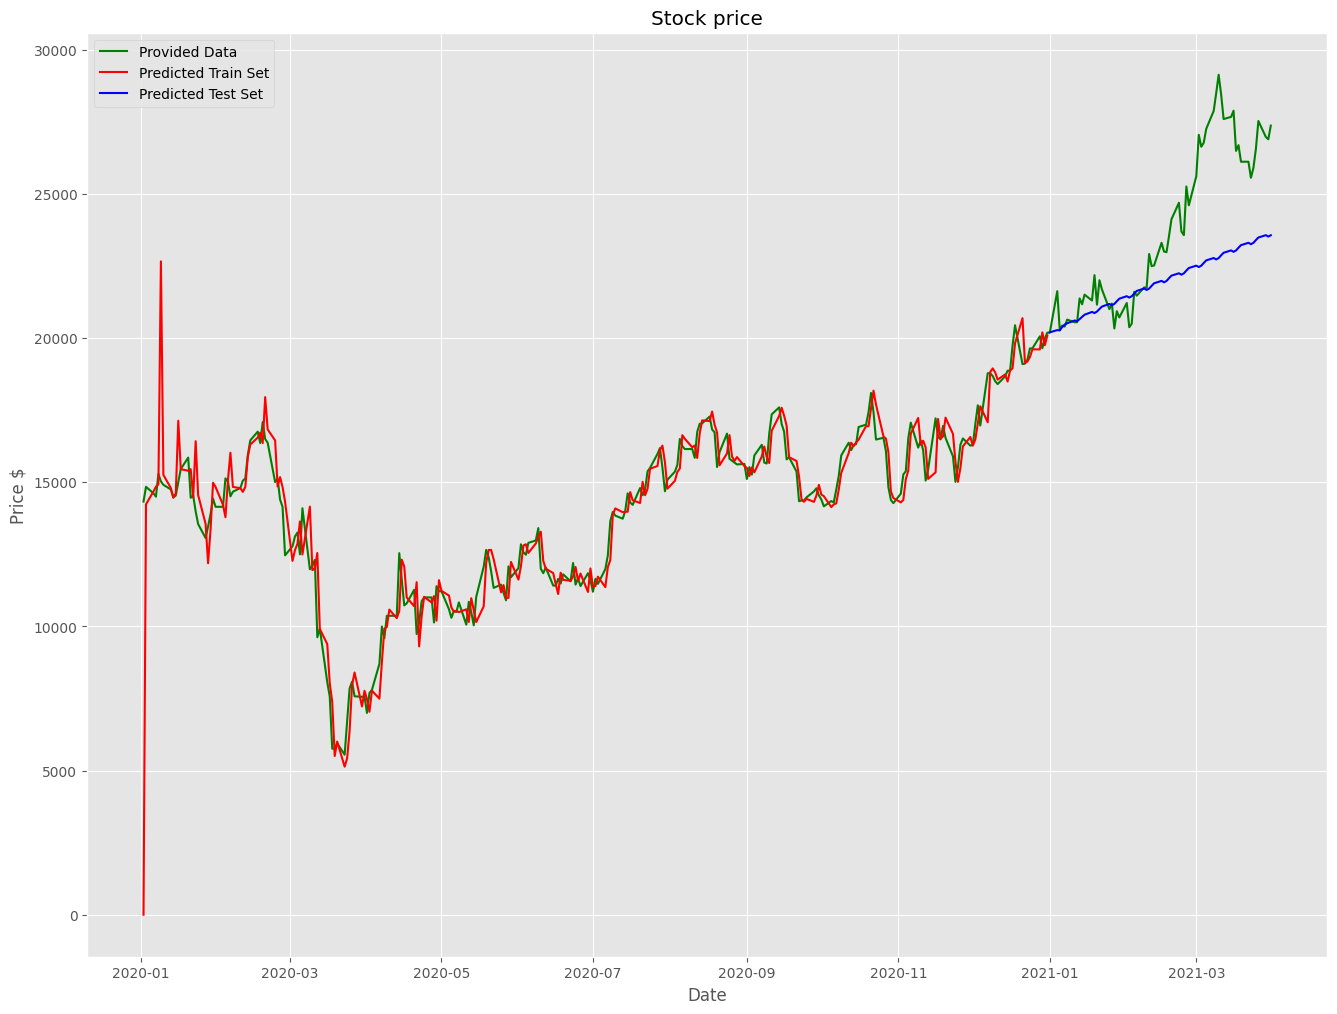

In [ ]:
#plot of showing prediced data Vs. Actual data

mpl.plot(C7, color = 'g', label = 'Provided Data')
mpl.plot(model.predict(), color = 'r', label = 'Predicted Train Set')

C_pred7.index = C_test7.index
mpl.plot(C_pred7, color = 'b', label = 'Predicted Test Set')
mpl.xlabel('Date')
mpl.ylabel('Price $')
mpl.title('Stock price')
mpl.legend()
mpl.show()

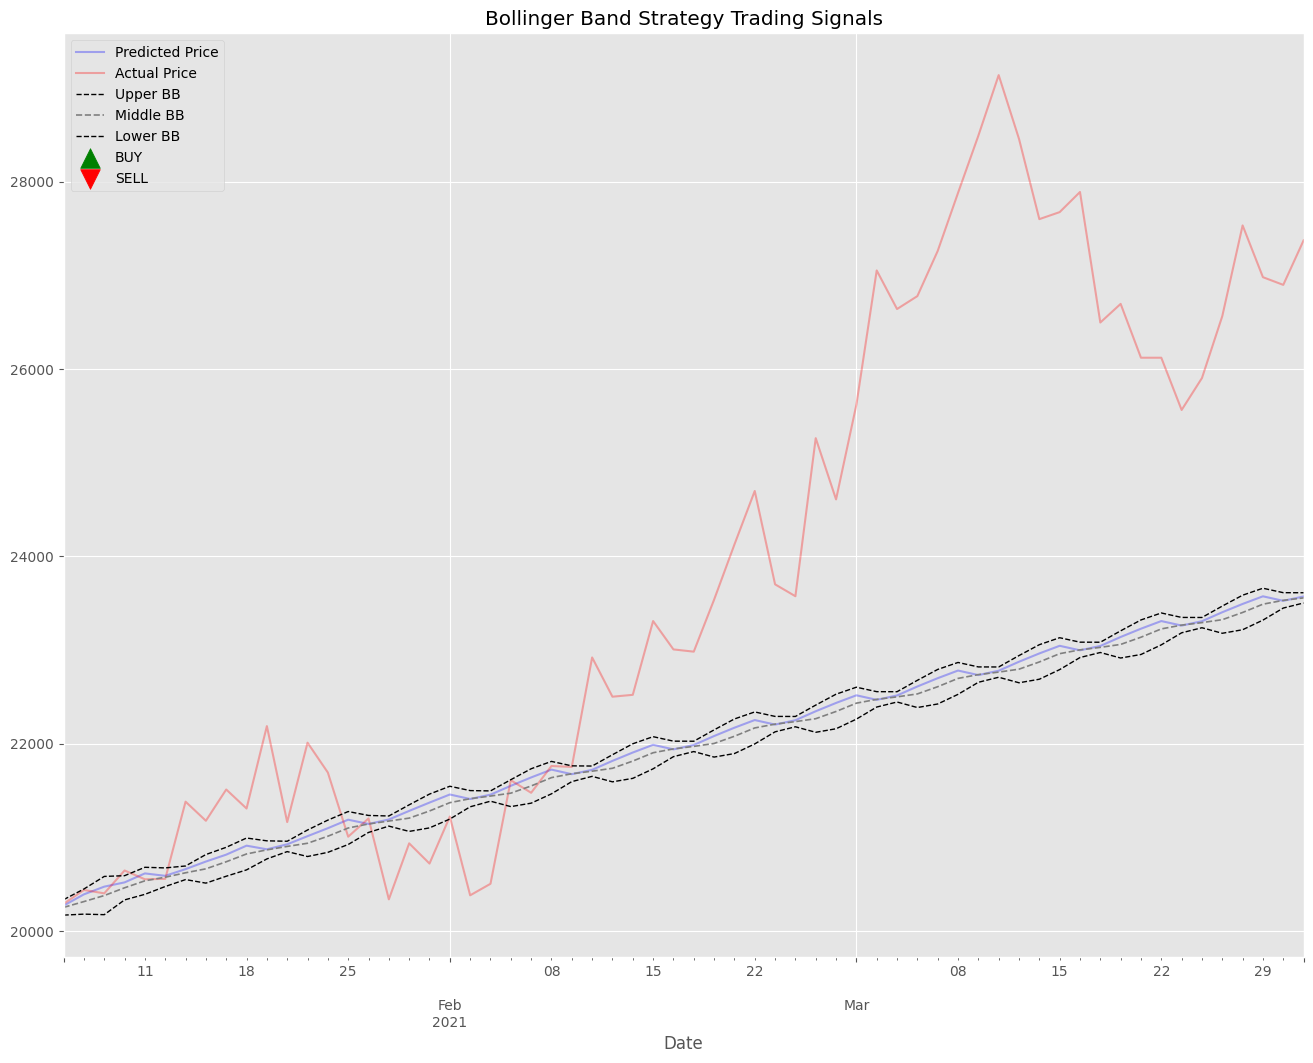

Return using Bollinger Band Strategy is 0%.
Return from do nothing strategy is 35.58%


In [ ]:
df_pred7 = pd.DataFrame({'test_set':C_test7, 'predicted':C_pred7})
df_pred7 = bollinger_bands(df_pred7, 3)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred7['predicted'], df_pred7['lower'], df_pred7['upper'])
plot_bollinger(df_pred7, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test7)

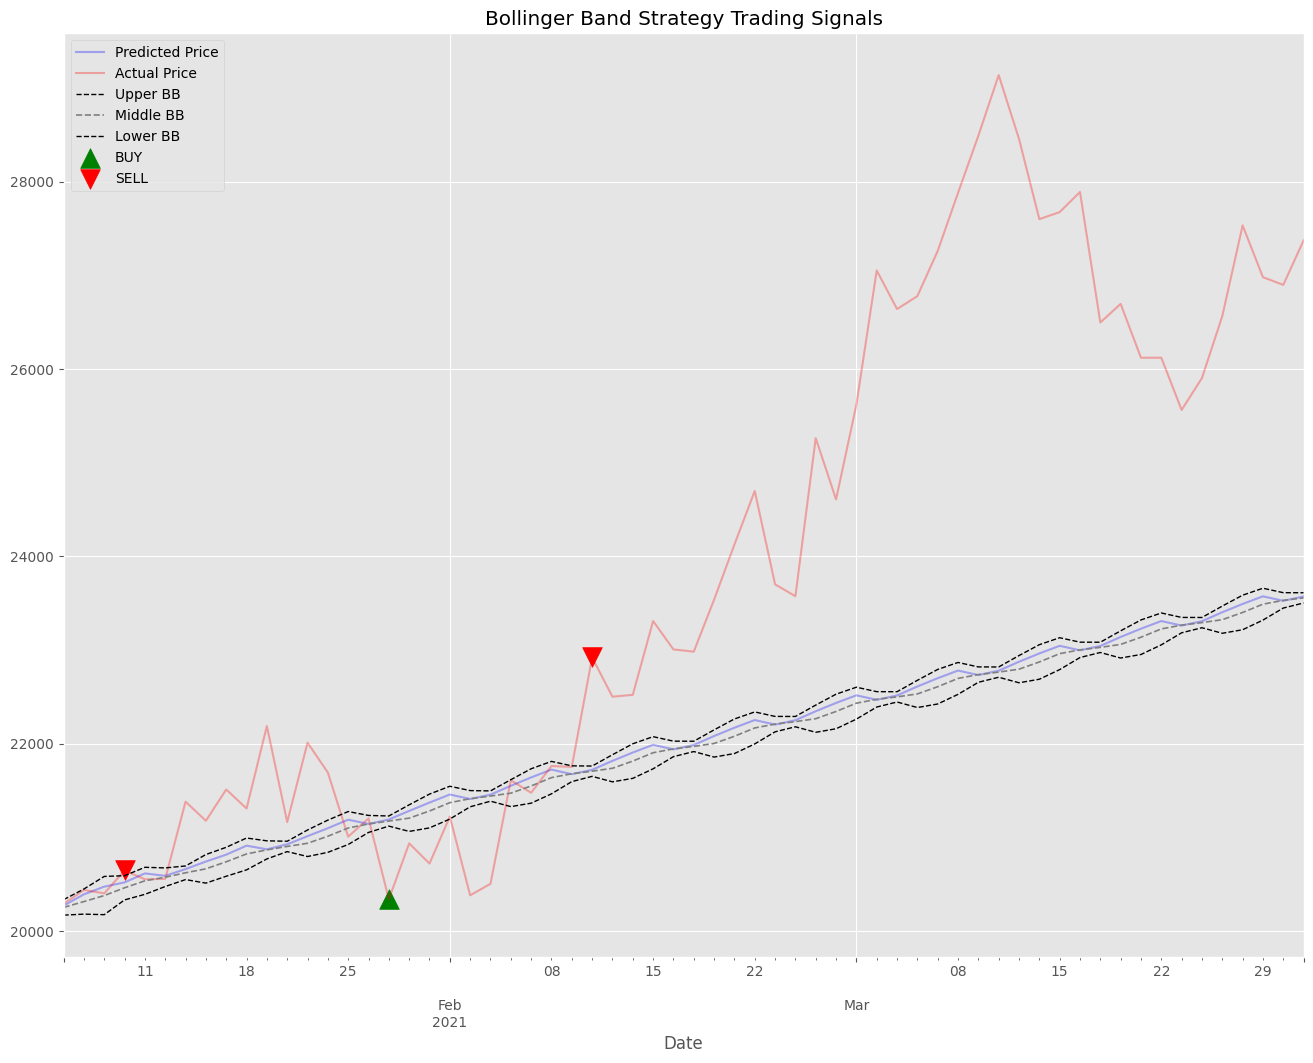

Return using Bollinger Band Strategy is 12.7%.
Return from do nothing strategy is 35.58%


In [ ]:
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred7['test_set'], df_pred7['lower'], df_pred7['upper'])
plot_bollinger(df_pred7, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test7)

# South Korea - Dongkuk Steel Mil

In [ ]:
df8.head(), df8.tail()

(            Price   Open   High    Low   Vol.  Change %
 Date                                                   
 2021-03-31  13650  13700  13750  13450  0.19K    0.0000
 2021-03-30  13650  13850  14200  13050  3.17M    0.0074
 2021-03-29  13550  12500  13800  12500  0.20K    0.1107
 2021-03-28  12200  12200  12200  12200      -    0.0000
 2021-03-26  12200  11500  12300  11350  2.34M    0.0796,
             Price  Open  High   Low     Vol.  Change %
 Date                                                  
 2020-01-08   5430  5640  5640  5390  524.10K   -0.0457
 2020-01-07   5690  5740  5770  5650  303.89K   -0.0070
 2020-01-06   5730  5890  5890  5680  319.88K   -0.0288
 2020-01-03   5900  5870  5920  5830  230.40K    0.0085
 2020-01-02   5850  5930  5980  5820  239.90K   -0.0168)

In [ ]:
# Apply the conversion function to the 'value' column
df8['Vol.'] = df8['Vol.'].apply(convert_to_numeric)

South Korea - Dongkuk Steel Mil


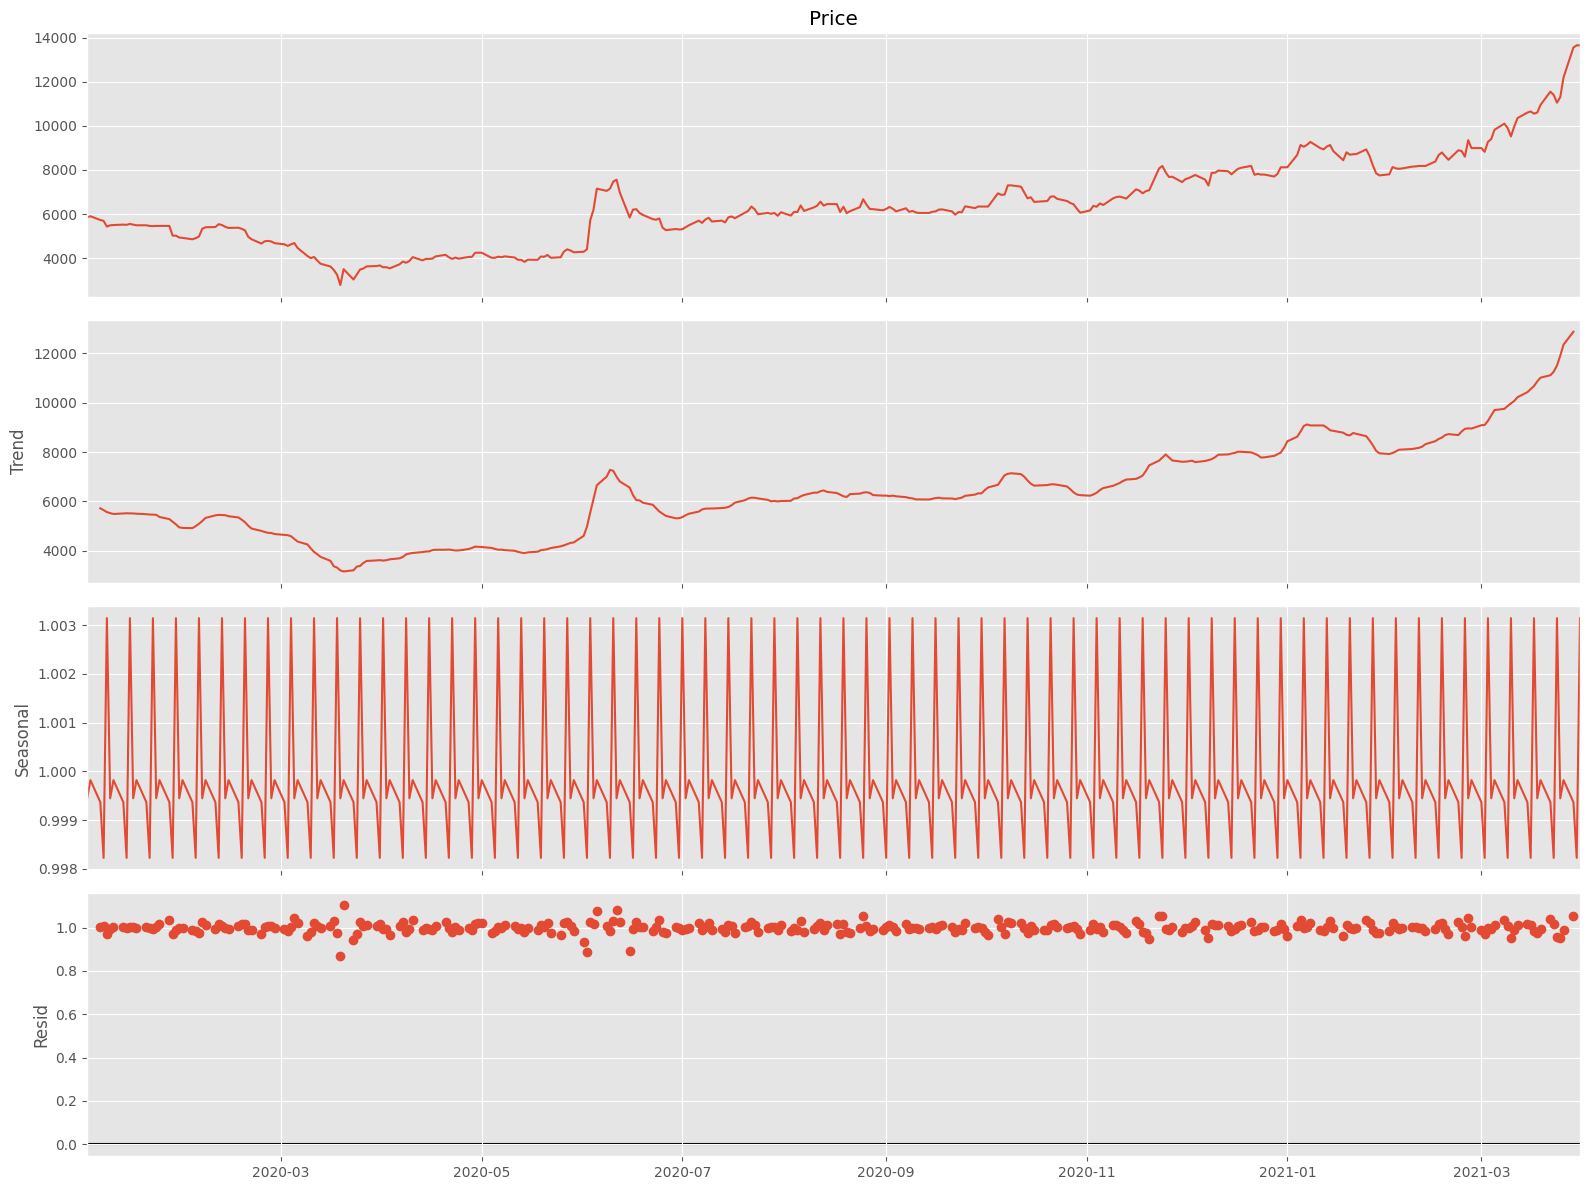

KPSS statistic: 2.31965418196106
p-value: 0.01
# lags : 11
KPSS statistic: 0.4699516067639548
p-value: 0.04843432280091108
# lags : 10


In [ ]:
company = list(df_f.keys())[7]
print(company)
df8 = df_f[company]

df8 = df8.resample('B').mean()
df8.fillna(method = 'ffill', inplace = True)

decomposition = seasonal_decompose(df8['Price'], model='multiplicative')
decomposition.plot()
mpl.show()
# Set y value
C8 = df8['Price']
# Check for stationarity
get_kpss_stat(C8)

C_d8 = C8.diff(6).dropna()
get_kpss_stat(C_d8)


In [ ]:
train_len8 = (C8.index.year==2020).sum()
C_train8 = C8[:train_len8]
C_test8 = C8[train_len8:]


train_len_d8 = (C_d8.index.year==2020).sum()
C_d_train8 = C_d8[:train_len_d8]
C_d_test8 = C_d8[train_len_d8:]

pdq_ARIMA = auto_arima(C_d_train8, trace = True)
p,d,q = pdq_ARIMA.order

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3636.698, Time=2.68 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3981.835, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3653.619, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3785.702, Time=1.59 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3981.802, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3643.624, Time=0.31 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=3629.809, Time=0.73 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=3630.598, Time=0.55 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=3628.017, Time=0.58 s

In [ ]:
total_len8= C8.shape[0]
train_len8 = (C8.index.year==2020).sum()
model = SARIMAX(C_train8, order = (p,d+1,q), seasonal_order= (p,d+1,q,5))
model = model.fit()
C_pred8 = model.predict(start = train_len8, end = total_len8-1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Price   No. Observations:                  261
Model:             SARIMAX(1, 1, 4)x(1, 1, 4, 5)   Log Likelihood               -1741.001
Date:                           Tue, 06 Aug 2024   AIC                           3504.001
Time:                                   03:40:16   BIC                           3542.955
Sample:                               01-02-2020   HQIC                          3519.670
                                    - 12-31-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9701      0.048    -20.297      0.000      -1.064      -0.876
ma.L1          1.0473      0.083     12.584      0.000       0.884       1.210
ma.L2          0.1560      0.052      3.028      0.002       0.055       0.257
ma.L3          0.0406      0.081      0.501      0.616      -0.118       0.200
ma.L4         -0.0626      0.074     -0.849      0.396      -0.207       0.082
ar.S.L5       -0.9823      0.166     -5.914      0.000      -1.308      -0.657
ma.S.L5        0.0680      0.184      0.369      0.712      -0.293       0.429
ma.S.L10      -0.9820      0.201     -4.874      0.000      -1.377      -0.587
ma.S.L15      -0.0438      0.072     -0.605      0.545      -0.186       0.098
ma.S.L20       0.0555      0.099      0.562      0.574      -0.138       0.249
sigma2      4.674e+04   2794.142     16.727      0.000    4.13e+04    5.22e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               556.54
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                             0.84
Prob(H) (two-sided):                  0.04   Kurtosis:                        10.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

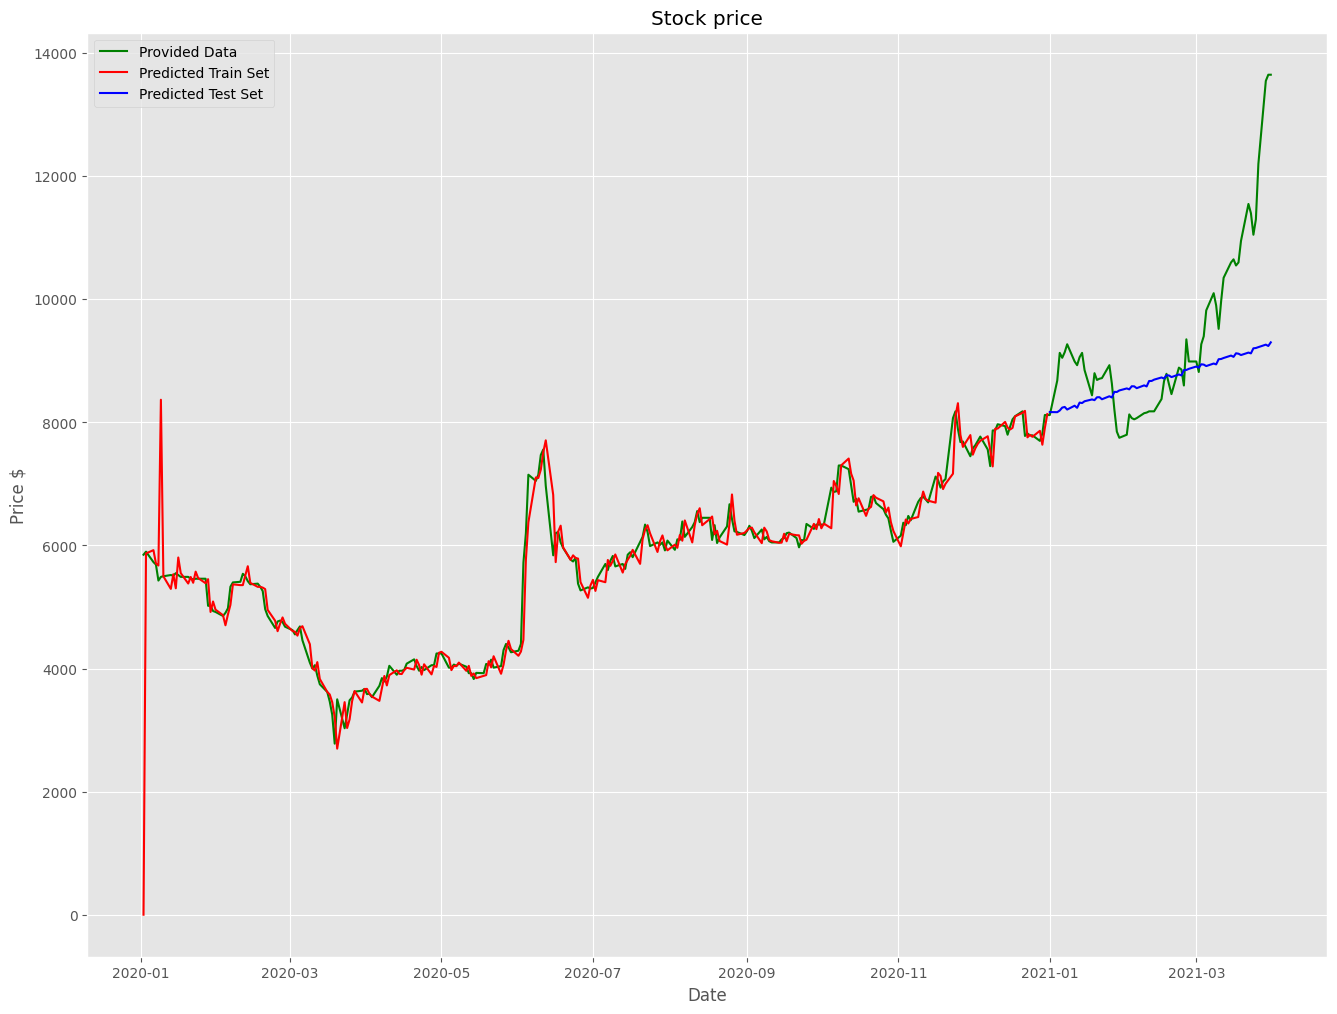

In [ ]:
#plot of showing prediced data Vs. Actual data

mpl.plot(C8, color = 'g', label = 'Provided Data')
mpl.plot(model.predict(), color = 'r', label = 'Predicted Train Set')

C_pred8.index = C_test8.index
mpl.plot(C_pred8, color = 'b', label = 'Predicted Test Set')
mpl.xlabel('Date')
mpl.ylabel('Price $')
mpl.title('Stock price')
mpl.legend()
mpl.show()

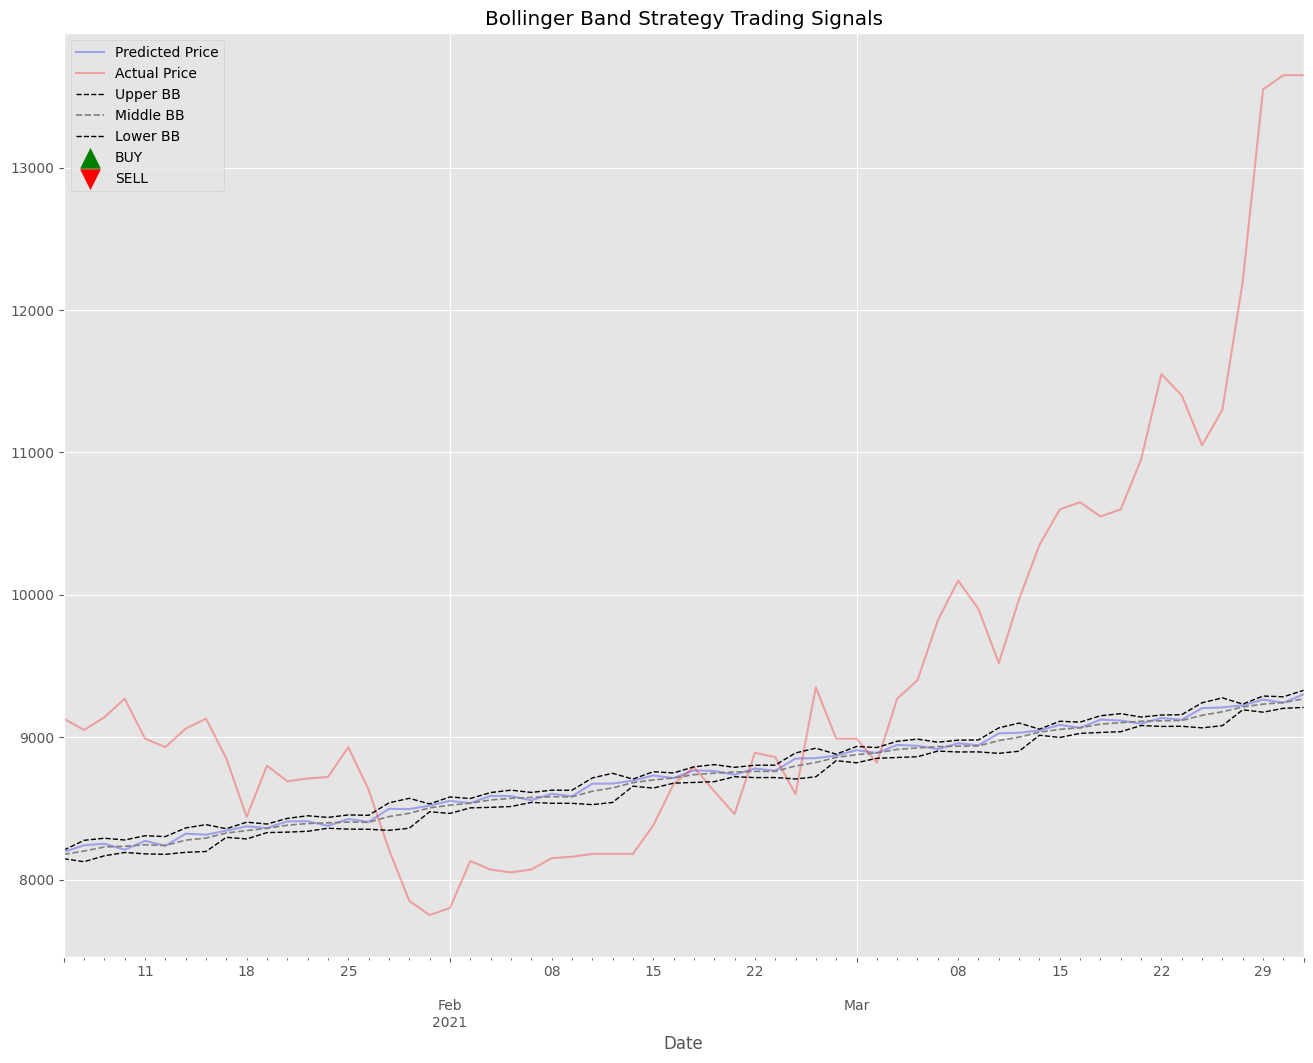

Return using Bollinger Band Strategy is 0%.
Return from do nothing strategy is 68.1%


In [ ]:
df_pred8 = pd.DataFrame({'test_set':C_test8, 'predicted':C_pred8})
df_pred8 = bollinger_bands(df_pred8, 3)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred8['predicted'], df_pred8['lower'], df_pred8['upper'])
plot_bollinger(df_pred8, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test8)

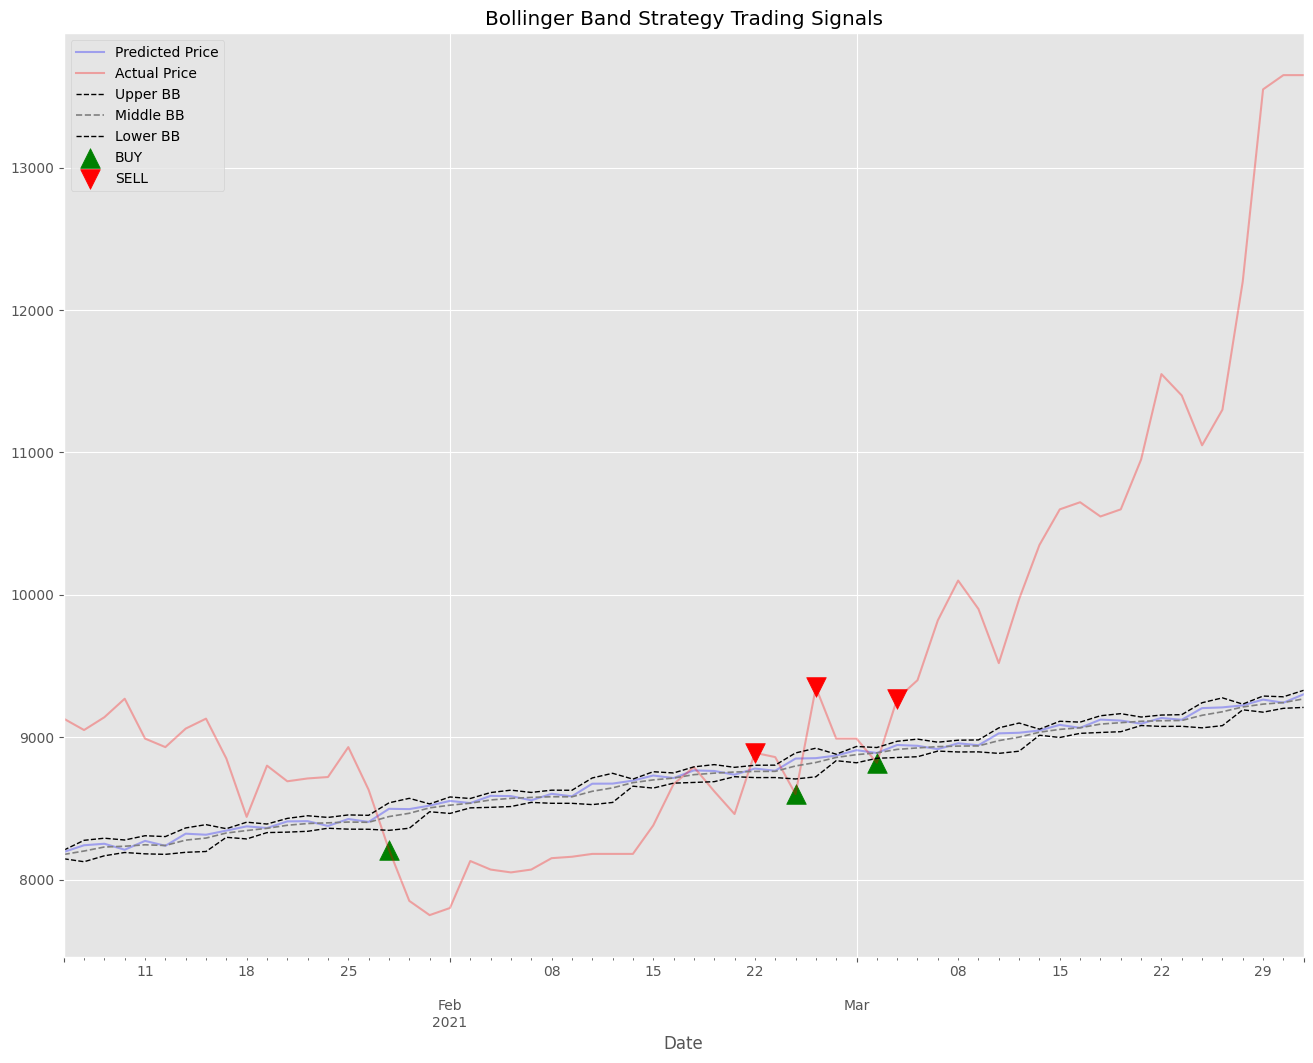

Return using Bollinger Band Strategy is 22.9%.
Return from do nothing strategy is 68.1%


In [ ]:
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred8['test_set'], df_pred8['lower'], df_pred8['upper'])
plot_bollinger(df_pred8, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test8)

# Time Series Forecasting and Bollinger Band Strategy

This project focuses on time series forecasting of stock prices and the application of the Bollinger Band strategy for trading.

## Data

The project uses a dataset of stock prices from various companies, including Sberbank Rossii PAO, Koc Holding AS, Medinet Nasr Housing, and more. The data is preprocessed to handle missing values and ensure consistency.

## Time Series Analysis

* **Decomposition:** Seasonal decomposition is used to analyze the trend, seasonality, and noise components of the time series.
* **Stationarity Testing:** The KPSS test is employed to check for stationarity, and differencing is applied to achieve stationarity if needed.

## Forecasting

* **SARIMAX/ARIMA Models:** These models are used to forecast future stock prices based on historical data.
* **Model Selection:** The `auto_arima` function helps in selecting optimal model parameters (p, d, q).

## Bollinger Band Strategy

* **Bollinger Bands Calculation:** The project calculates Bollinger Bands based on moving averages and standard deviations.
* **Trading Signals:** Buy and sell signals are generated based on price movements relative to the Bollinger Bands.
* **Return Calculation:** The return from the Bollinger Band strategy is compared to a buy-and-hold strategy.

## Conclusion

The project demonstrates the application of time series forecasting and the Bollinger Band strategy for stock trading. The results show the potential of this approach in generating trading signals and achieving favorable returns.

# Time Series Forecasting and Bollinger Band Strategy

This project delves into the realm of time series analysis and forecasting, with a specific focus on stock price prediction. We leverage advanced statistical models like SARIMAX and ARIMA to capture the underlying patterns in historical stock data and generate future price projections. Further, we implement the renowned Bollinger Band strategy, a technical trading tool, to identify potential buy and sell signals based on the forecasted prices.

## Data

Our analysis is grounded in a rich dataset comprising stock prices of diverse companies, spanning various sectors and geographical regions. Examples include:

* **Sberbank Rossii PAO (s):** A leading Russian banking and financial services company.
* **Koc Holding AS:** A prominent Turkish conglomerate with interests in energy, automotive, and consumer durables.
* **Medinet Nasr Housing (M):** An Egyptian real estate development company.
* **Minerva SABrazil (BEEF):** A major Brazilian meat processing and export company.
* **And many more...**

The data is meticulously preprocessed to address missing values, ensure consistency, and prepare it for modeling.

## Time Series Analysis

To gain a deeper understanding of the stock price dynamics, we perform a comprehensive time series analysis, encompassing:

* **Decomposition:** We decompose the time series into its constituent components - trend, seasonality, and noise - to discern the underlying patterns and isolate the cyclical fluctuations.
* **Stationarity Testing:** We employ the KPSS test to assess the stationarity of the time series, a crucial assumption for many forecasting models. If non-stationarity is detected, we apply differencing techniques to transform the data into a stationary form.

## Forecasting

Armed with the insights from the time series analysis, we proceed to forecast future stock prices using sophisticated statistical models:

* **SARIMAX/ARIMA Models:** These models are capable of capturing both autoregressive (AR) and moving average (MA) components of the time series, along with seasonal patterns.
* **Model Selection:** We leverage the `auto_arima` function to automatically determine the optimal model parameters (p, d, q) based on the data, ensuring the best possible fit.

## Bollinger Band Strategy

The forecasted prices serve as the foundation for implementing the Bollinger Band strategy, a widely used technical analysis tool:

* **Bollinger Bands Calculation:** We calculate the upper and lower Bollinger Bands by adding and subtracting a multiple of the standard deviation from the moving average of the forecasted prices.
* **Trading Signals:** When the price crosses below the lower band, it generates a buy signal, indicating potential undervaluation. Conversely, a cross above the upper band triggers a sell signal, suggesting potential overvaluation.
* **Return Calculation:** We rigorously evaluate the performance of the Bollinger Band strategy by calculating the return it generates and comparing it against a simple buy-and-hold strategy.

## Conclusion

This project showcases the power of time series forecasting and the Bollinger Band strategy in the context of stock trading. Our findings underscore the potential of this approach to identify profitable trading opportunities and outperform passive investment strategies.

Feel free to explore the code and experiment with different stocks and parameters to deepen your understanding of time series analysis and trading strategies.

# Conclusion
For this project, time series forecasting dataset was decomposed to analyze. SARIMAX and ARIMA model was used on each individual stocks. The model was trianed with training assigned dataset ( Q1-Q4 in 2020) amd predicted with Q1 2021 dataset.

The prediction was tested by applying bollinger band strategy, ML strategy was used to get return higher in comparison to buy,sell and hold strategy

Capture.JPG